In [312]:
%pip install pandas matplotlib scipy seaborn mpld3 pip install ipympl

  Using cached install-1.3.5-py3-none-any.whl (3.2 kB)
     |████████████████████████████████| 508 kB 2.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import argparse
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import seaborn as sns
import glob
from scipy import stats
from dateutil import tz
import itertools
from matplotlib import pyplot, dates
import matplotlib.ticker as ticker
import pytz

In [2]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

In [3]:
from scipy.signal import savgol_filter

from common import combine_csvs
import common
from common import N_STARLINK
from common import N_STARLINK_REMOTE
from common import N_HOME
from common import N_HAMPTON
from common import N_MOTION

REG_ORDER = common.REGION_ORDER.copy()
REG_ORDER.remove('N. Virginia')

In [5]:
MEGAb_TO_b = 1e6
N_TCP = 'TCP'
N_UDP = 'UDP'
N_DOWN = 'Download'
N_UP = 'Upload'

COL_TRANSF_DIR = 'Transfer Direction'
COL_PROT_TYPE = 'Protocol and Type'

TCP_DOWN = 'TCP Down'
TCP_DOWN_SEND = 'TCP Down Send'
UDP_DOWN = 'UDP Down'
TCP_UP = 'TCP Up'
TCP_UP_SEND = 'TCP Up Send'
UDP_UP = 'UDP Up'
PROTOCOLS_MAP = {TCP_DOWN: "*down.*.csv", UDP_DOWN: "*down*udp*.csv", 
                 TCP_UP: "*receive*.*[!p].csv", UDP_UP: "*receive*.udp.csv",
                 TCP_DOWN_SEND: "*send*.*[!p].csv",
                TCP_UP_SEND: "*up.*[!p].csv"}

PROTOCOLS_SEP_MAP = {TCP_DOWN: [N_TCP, N_DOWN], UDP_DOWN: [N_UDP, N_DOWN], 
                 TCP_UP: [N_TCP, N_UP], UDP_UP: [N_UDP, N_UP],
                    TCP_DOWN_SEND: [N_TCP, N_DOWN], TCP_UP_SEND: [N_TCP, N_UP]}

PROT_TYPE_ORDER = [f'{N_TCP} {N_HOME}', f'{N_TCP} {N_STARLINK}', f'{N_UDP} {N_HOME}', f'{N_UDP} {N_STARLINK}']

TEMP='Temp (°C)'
PRECIP='Precip. Amount (mm)'

JITTER = 'jitter_ms'
BANDWIDTH = 'bandwidth'
COL_PARAID = 'parallel ID'

N_REGIONS = 'Regions'
N_TIMESTAMP = 'Timestamp'
N_TYPE = 'Type'
N_PROTOCOL = 'Protocol'
N_POWER_WATTS = 'Power Consumption (Watts)'

OUTPUT_FOLDER = 'output/throughput'
N_LOST_PERCENT = 'lost_percent'

In [6]:
plot_params = common.plot_params
plot_params['figure.figsize'] = (7.16, 4)
plot_params['figure.dpi'] = 300
#matplotlib.rcParams.update(plot_params)

sns_params = common.sns_params
sns_params['figure.figsize'] = (7.16, 4)
sns_params['figure.dpi'] = 300
sns.set_theme("paper", style='whitegrid', color_codes=True, rc=sns_params, palette='bright')
#sns.set_context("paper", )
#sns.set(rc=sns_params)

In [7]:
def convert_to_mb(df):
    # Converts to Megabits per second
    df.bits_per_second /= MEGAb_TO_b
    df.rename(columns={'bits_per_second': 'bandwidth'}, inplace=True)

In [8]:
def concat_df(src, pattern, keep=['bandwidth']):
    files = glob.glob(f"{src}/**/{pattern}", recursive=True)
    if not files:
        return pd.DataFrame()
    combined_df = combine_csvs(files)
    
    combined_df.index = pd.to_datetime(combined_df.index, unit='s')
    if keep == ['bandwidth'] or keep == 'all':
        convert_to_mb(combined_df)
    if keep != 'all':
        combined_df = combined_df[keep]
    return combined_df

In [9]:
def remove_first_measures(df, first=3):
    if first == 0:
        return df
    # Remove first {first} datapoints for each measurement
    # Take into account of software tool overhead
    diff_time = (df.index - df.reset_index().timestamp.shift())
    # Choose entries where previous time is less than an hour
    first_measure_map = diff_time < pd.Timedelta(5, unit='m')
    # Propagate to first three datapoints
    for i in range(1, first):
        first_measure_map = first_measure_map.eq(first_measure_map.shift(i))

    df_map = pd.DataFrame(columns=df.columns)
    for i, _ in enumerate(df.columns):
        df_map.iloc[:, i] = first_measure_map
    df_map['timestamp'] = df.index
    df_map.set_index('timestamp', inplace=True)
    filtered_df = df.where(df_map, -1) # Set to -1

    return filtered_df

In [10]:
def combine_reg(src, pattern, keep=['bandwidth'], first=3):
    regions_df = pd.DataFrame()
    for region in glob.glob(f"{src}/*"):
        combined_df = concat_df(region, pattern, keep)
        if combined_df.empty:
            return pd.DataFrame()
        combined_df = combined_df.sort_values('timestamp')
        reg_name = os.path.basename(region)
        combined_df = remove_first_measures(combined_df, first)
        combined_df[N_REGIONS] = common.region_mapping[reg_name]

        if regions_df.empty:
            regions_df = combined_df
        else:
            regions_df = pd.concat([regions_df, combined_df])

    return regions_df


In [58]:
src_dirs = []
for folder in glob.glob('data/starlink-data/Iperf_csv_updated_with_cwnd/*'):
    src_dirs.append((N_STARLINK, folder))
for folder in glob.glob('data/Home_network_data/Iperf_csv_updated_with_cwnd/*'):
    src_dirs.append((N_HOME, folder))
    
#src_dirs = [(N_HAMPTON, 'data/starlink-data/Iperf_csv_07-22/2022-07-16_mann_starlink_iperf3/')]

#src_dirs = [(N_STARLINK, 'data/starlink-data/Iperf_csv_07-22/motion_starlink_iperf3/')]
#src_dirs += [(N_STARLINK, 'data/starlink-data/Iperf_csv_07-22/mmotion_starlink_iperf3/')]

#src_dirs = [(N_STARLINK, 'data/starlink-data/Iperf_csv_07-22/motion_starlink_iperf3/')]
#src_dirs += [(N_STARLINK, 'data/starlink-data/Iperf_csv_07-22/mmotion_starlink_iperf3/')]

#src_dirs = [(N_STARLINK, 'data/starlink-data/Iperf_extra_csv/peer-to-peer_2022-07-24/')]

#src_dirs = [('Starlink', 'data/starlink-data/Iperf_csv/2022-01-23_starlink_iperf_tcp')]

#src_dirs = [(N_STARLINK_REMOTE, 'data/Koeye/2022-05-20_koeye_starlink_csv_iperf3/')]
#src_dirs += [(N_STARLINK_REMOTE, 'data/Koeye/2022-05-21_koeye_starlink_csv_iperf3/')]

# Packet Loss
#src_dirs = [(N_STARLINK, 'data/starlink-data/Iperf_csv_extra/low_packet_loss_2022-07-30_starlink_iperf3_csv/')]
#src_dirs = [(N_STARLINK, 'data/starlink-data/Iperf_extra_csv/low_packet_loss_onefifth_2022-07-30_starlink_iperf3_csv/')]
src_dirs = [(N_STARLINK, 'data/starlink-data/Iperf_extra_csv/low_packet_loss_true_onefifth_2022-07-31_starlink_iperf3/')]
src_dirs

[('Starlink',
  'data/starlink-data/Iperf_extra_csv/low_packet_loss_true_onefifth_2022-07-31_starlink_iperf3/')]

In [38]:
pd.DataFrame(src_dirs).to_csv('out.csv')

In [59]:
import traceback
df = pd.DataFrame()
for type_name, folder in src_dirs:
    max_fail = len(PROTOCOLS_MAP)
    count = 0
    for (protocol, pattern) in PROTOCOLS_MAP.items():
        #df = concat_df(args.src_folder, UDP_UP, [JITTER])
        #df_temp = combine_reg(folder, pattern, first=1, keep='all')
        df_temp = combine_reg(folder, pattern, first=3, keep='all')
        
        prot_dir = PROTOCOLS_SEP_MAP[protocol]
        df_temp[N_PROTOCOL] = prot_dir[0]
        df_temp[COL_TRANSF_DIR] = prot_dir[1]
        df_temp[N_TYPE] = type_name
        df_temp[COL_PROT_TYPE] = prot_dir[0] + ' ' + type_name
        if not df.empty:
            #df = df.merge(df_temp, how='outer', left_index=True, right_index=True)
            df = pd.concat([df, df_temp])
        else:
            df = df_temp
    if count >= max_fail:
        raise ValueError('MAJOR error')
        
df = df.reset_index().rename({'index': N_TIMESTAMP}, axis=1)
df[N_TIMESTAMP] = df[N_TIMESTAMP].dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
df

Timestamp  bandwidth  jitter_ms  lost_packets  \
0              2022-07-31 04:43:37-07:00  -1.000000  -1.000000          -1.0   
1    2022-07-31 04:43:38.000182272-07:00  -1.000000  -1.000000          -1.0   
2    2022-07-31 04:43:39.000183040-07:00  -1.000000  -1.000000          -1.0   
3    2022-07-31 04:43:40.000161280-07:00  -1.000000  -1.000000          -1.0   
4    2022-07-31 04:43:41.000177152-07:00  39.942832   1.727504           0.0   
...                                  ...        ...        ...           ...   
996  2022-07-31 04:50:03.000083968-07:00   2.131496  15.230011           0.0   
997  2022-07-31 04:50:04.000065024-07:00   2.085106  14.547247           0.0   
998  2022-07-31 04:50:05.000071936-07:00   2.038770  15.122504           0.0   
999  2022-07-31 04:50:06.000078848-07:00   2.085118  14.648204           0.0   
1000 2022-07-31 04:50:07.000080128-07:00   2.697350  14.785666           0.0   

      packets  lost_percent  snd_cwnd  rtt  rttvar  retransmits  parallel ID  \
0        -1.0          -1.0      -1.0 -1.0    -1.0         -1.0         -1.0   
1        -1.0          -1.0      -1.0 -1.0    -1.0         -1.0         -1.0   
2        -1.0          -1.0      -1.0 -1.0    -1.0         -1.0         -1.0   
3        -1.0          -1.0      -1.0 -1.0    -1.0         -1.0         -1.0   
4      3448.0           0.0       NaN  NaN     NaN          NaN          NaN   
...       ...           ...       ...  ...     ...          ...          ...   
996     184.0           0.0       NaN  NaN     NaN          NaN          NaN   
997     180.0           0.0       NaN  NaN     NaN          NaN          NaN   
998     176.0           0.0       NaN  NaN     NaN          NaN          NaN   
999     180.0           0.0       NaN  NaN     NaN          NaN          NaN   
1000     15.0           0.0       NaN  NaN     NaN          NaN          NaN   

            Regions Protocol Transfer Direction      Type Protocol and Type  
0     N. California      TCP           Download  Starlink      TCP Starlink  
1     N. California      TCP           Download  Starlink      TCP Starlink  
2     N. California      TCP           Download  Starlink      TCP Starlink  
3     N. California      TCP           Download  Starlink      TCP Starlink  
4     N. California      TCP           Download  Starlink      TCP Starlink  
...             ...      ...                ...       ...               ...  
996   N. California      UDP             Upload  Starlink      UDP Starlink  
997   N. California      UDP             Upload  Starlink      UDP Starlink  
998   N. California      UDP             Upload  Starlink      UDP Starlink  
999   N. California      UDP             Upload  Starlink      UDP Starlink  
1000  N. California      UDP             Upload  Starlink      UDP Starlink  

[1001 rows x 16 columns]

In [61]:
df_regs = df.replace(-1, np.nan)
#df_regs = df_regs.where(df_regs.notnull(), None)
df_regs = df_regs.dropna(subset='bandwidth')
df_regs = df_regs.sort_values('bandwidth')
df_regs = df_regs.reset_index(drop=True)
#df = concat_df(args.src_folder, UDP_DOWN).sort_values('timestamp')

print(df_regs.dtypes)
df_regs.sort_values(N_TIMESTAMP)

Timestamp             datetime64[ns, US/Pacific]
bandwidth                                float64
jitter_ms                                float64
lost_packets                             float64
packets                                  float64
lost_percent                             float64
snd_cwnd                                 float64
rtt                                      float64
rttvar                                   float64
retransmits                              float64
parallel ID                              float64
Regions                                   object
Protocol                                  object
Transfer Direction                        object
Type                                      object
Protocol and Type                         object
dtype: object


Timestamp  bandwidth  jitter_ms  lost_packets  \
118 2022-07-31 04:43:41.000067840-07:00   2.038778  12.732637           0.0   
390 2022-07-31 04:43:41.000177152-07:00  39.942832   1.727504           0.0   
389 2022-07-31 04:43:41.000177152-07:00  39.942832   1.727504           0.0   
38  2022-07-31 04:43:42.000071168-07:00   1.946099  10.207877          16.0   
941 2022-07-31 04:43:42.000147200-07:00  40.542666   1.432663           0.0   
..                                  ...        ...        ...           ...   
572 2022-07-31 04:50:05.000195072-07:00  40.231031   1.399957           0.0   
228 2022-07-31 04:50:06.000078848-07:00   2.085118  14.648204           0.0   
851 2022-07-31 04:50:06.000199936-07:00  40.402854   1.299291           0.0   
852 2022-07-31 04:50:06.000199936-07:00  40.402854   1.299291           0.0   
343 2022-07-31 04:50:07.000080128-07:00   2.697350  14.785666           0.0   

     packets  lost_percent  snd_cwnd  rtt  rttvar  retransmits  parallel ID  \
118    176.0      0.000000       NaN  NaN     NaN          NaN          NaN   
390   3448.0      0.000000       NaN  NaN     NaN          NaN          NaN   
389   3448.0      0.000000       NaN  NaN     NaN          NaN          NaN   
38     184.0      8.695652       NaN  NaN     NaN          NaN          NaN   
941   3500.0      0.000000       NaN  NaN     NaN          NaN          NaN   
..       ...           ...       ...  ...     ...          ...          ...   
572   3473.0      0.000000       NaN  NaN     NaN          NaN          NaN   
228    180.0      0.000000       NaN  NaN     NaN          NaN          NaN   
851   3488.0      0.000000       NaN  NaN     NaN          NaN          NaN   
852   3488.0      0.000000       NaN  NaN     NaN          NaN          NaN   
343     15.0      0.000000       NaN  NaN     NaN          NaN          NaN   

           Regions Protocol Transfer Direction      Type Protocol and Type  
118  N. California      UDP             Upload  Starlink      UDP Starlink  
390  N. California      UDP           Download  Starlink      UDP Starlink  
389  N. California      TCP           Download  Starlink      TCP Starlink  
38   N. California      UDP             Upload  Starlink      UDP Starlink  
941  N. California      UDP           Download  Starlink      UDP Starlink  
..             ...      ...                ...       ...               ...  
572  N. California      TCP           Download  Starlink      TCP Starlink  
228  N. California      UDP             Upload  Starlink      UDP Starlink  
851  N. California      UDP           Download  Starlink      UDP Starlink  
852  N. California      TCP           Download  Starlink      TCP Starlink  
343  N. California      UDP             Upload  Starlink      UDP Starlink  

[989 rows x 16 columns]

In [118]:
df = df.rename({'timestamp': N_TIMESTAMP}, axis=1)

In [126]:
print(33.866 / 79.71)
print(12.58 / 7.13)
print(83.809916 / 204.21)
print(7.623936 / 10.51)

0.42486513611842935
1.7643758765778401
0.41041044023309337
0.7253982873453854


In [67]:
df_regs[df_regs[N_REGIONS] != 'N. California'].pivot_table(index=COL_TRANSF_DIR, columns=[N_TYPE, N_PROTOCOL], values='jitter_ms', aggfunc='max')

Type                  Starlink   Terrestrial
Protocol                   UDP           UDP
Transfer Direction                          
Download            709.103476  1.049688e+00
Upload              474.236550  5.902264e+10

In [71]:
df_regs[(df_regs[N_TYPE] == N_HOME) & (df_regs[COL_TRANSF_DIR] == N_UP)]['jitter_ms'].dropna()

116020    0.000000
116021    0.000000
116062    0.000000
116063    0.000000
116064    0.000000
            ...   
941065    0.501845
941154    0.521628
941269    0.595363
941990    1.319339
953614    0.544025
Name: jitter_ms, Length: 31858, dtype: float64

In [12]:
#df_regs_old = pd.read_csv(f'{OUTPUT_FOLDER}/2022-06-05_end_all_starlink_iperf3.csv', index_col=None)
df_regs_old = pd.read_csv(f'{OUTPUT_FOLDER}/2022-07-07_end_all_starlink_iperf3.csv', index_col=None)
df_regs_old[N_TIMESTAMP] = pd.to_datetime(df_regs_old[N_TIMESTAMP], utc=True)
print(df_regs_old.dtypes)
df_regs_old

Timestamp             datetime64[ns, UTC]
bandwidth                         float64
jitter_ms                         float64
lost_packets                      float64
packets                           float64
lost_percent                      float64
snd_cwnd                          float64
rtt                               float64
rttvar                            float64
retransmits                       float64
parallel ID                       float64
Regions                            object
Protocol                           object
Transfer Direction                 object
Type                               object
Protocol and Type                  object
dtype: object


Timestamp   bandwidth  jitter_ms  \
0       2022-01-26 03:50:55.000403968+00:00    0.000000        NaN   
1       2022-01-26 22:06:22.000380160+00:00    0.000000        NaN   
2       2022-01-26 22:06:23.000103936+00:00    0.000000        NaN   
3       2022-01-26 22:06:23.000103936+00:00    0.000000        NaN   
4       2022-01-26 22:06:24.000879104+00:00    0.000000        NaN   
...                                     ...         ...        ...   
1336856 2022-05-28 10:01:02.000055040+00:00  838.443014   0.055429   
1336857 2022-07-05 11:06:45.000055040+00:00  841.135643   0.018978   
1336858 2022-05-30 17:09:39.000015104+00:00  842.372040        NaN   
1336859 2022-05-28 23:09:43.000055040+00:00  844.888201        NaN   
1336860 2022-07-06 19:08:52.000093952+00:00  849.113524        NaN   

         lost_packets  packets  lost_percent  snd_cwnd       rtt   rttvar  \
0                 NaN      NaN           NaN   18824.0  244901.0   6501.0   
1                 NaN      NaN           NaN   43440.0  226666.0   6452.0   
2                 NaN      NaN           NaN   21720.0  278851.0  40207.0   
3                 NaN      NaN           NaN   30408.0  268488.0  29151.0   
4                 NaN      NaN           NaN   26064.0  246343.0   9022.0   
...               ...      ...           ...       ...       ...      ...   
1336856         793.0  73169.0      1.083792       NaN       NaN      NaN   
1336857        2995.0  75603.0      3.961483       NaN       NaN      NaN   
1336858           NaN      NaN           NaN       NaN       NaN      NaN   
1336859           NaN      NaN           NaN       NaN       NaN      NaN   
1336860           NaN      NaN           NaN       NaN       NaN      NaN   

         retransmits  parallel ID        Regions Protocol Transfer Direction  \
0                0.0          2.0         Sydney      TCP             Upload   
1                0.0          3.0         Sydney      TCP             Upload   
2                0.0          0.0         Sydney      TCP             Upload   
3                0.0          1.0         Sydney      TCP             Upload   
4                0.0          0.0         Sydney      TCP             Upload   
...              ...          ...            ...      ...                ...   
1336856          NaN          NaN         Sydney      UDP           Download   
1336857          NaN          NaN        Bahrain      UDP           Download   
1336858          NaN          NaN  N. California      TCP           Download   
1336859          NaN          NaN  N. California      TCP           Download   
1336860          NaN          NaN  N. California      TCP           Download   

                Type Protocol and Type  
0           Starlink      TCP Starlink  
1           Starlink      TCP Starlink  
2           Starlink      TCP Starlink  
3           Starlink      TCP Starlink  
4           Starlink      TCP Starlink  
...              ...               ...  
1336856  Terrestrial   UDP Terrestrial  
1336857  Terrestrial   UDP Terrestrial  
1336858  Terrestrial   TCP Terrestrial  
1336859  Terrestrial   TCP Terrestrial  
1336860  Terrestrial   TCP Terrestrial  

[1336861 rows x 16 columns]

In [43]:
# Every drastic change, record the timestamp
thresh = 10
ts = []
prev_freq = None
for _, row in df_interv.iterrows():
    lat = row[N_LATENCY]
    if prev_freq:
        if np.abs(prev_freq - lat) > thresh:
            ts.append(row[N_TIMESTAMP])
        
    prev_freq = lat
    
ts

[Timestamp('2022-06-16 23:00:12'),
 Timestamp('2022-06-16 23:00:13'),
 Timestamp('2022-06-16 23:00:16'),
 Timestamp('2022-06-16 23:00:17'),
 Timestamp('2022-06-16 23:00:20'),
 Timestamp('2022-06-16 23:00:21'),
 Timestamp('2022-06-16 23:00:22'),
 Timestamp('2022-06-16 23:00:26'),
 Timestamp('2022-06-16 23:00:42'),
 Timestamp('2022-06-16 23:00:44'),
 Timestamp('2022-06-16 23:00:49'),
 Timestamp('2022-06-16 23:01:34'),
 Timestamp('2022-06-16 23:01:36'),
 Timestamp('2022-06-16 23:01:38'),
 Timestamp('2022-06-16 23:01:46'),
 Timestamp('2022-06-16 23:02:12'),
 Timestamp('2022-06-16 23:02:13'),
 Timestamp('2022-06-16 23:02:16'),
 Timestamp('2022-06-16 23:02:28'),
 Timestamp('2022-06-16 23:02:29'),
 Timestamp('2022-06-16 23:02:33'),
 Timestamp('2022-06-16 23:02:36'),
 Timestamp('2022-06-16 23:02:37'),
 Timestamp('2022-06-16 23:02:39'),
 Timestamp('2022-06-16 23:02:40'),
 Timestamp('2022-06-16 23:02:41'),
 Timestamp('2022-06-16 23:02:42'),
 Timestamp('2022-06-16 23:02:43'),
 Timestamp('2022-06-

In [142]:
from astropy.table import Table
tab = Table.read('out.tex').to_pandas()

In [128]:
df_loss = df_regs[(df_regs[COL_PARAID].isnull())].pivot_table(
    #index=N_REGIONS,
    index=[N_TYPE, COL_TRANSF_DIR], 
    values='jitter_ms',
    #aggfunc=lambda x: np.percentile(x, 20),
    aggfunc='median',
)
df_loss

jitter_ms
Type     Transfer Direction           
Starlink Download             1.499474
         Upload              11.513344

In [147]:
df_loss[N_STARLINK][N_DOWN]

Regions
Bahrain          25.610158
Cape Town        39.186067
London           23.485369
Mumbai           25.042477
N. California    24.552294
Sao Paulo        23.515269
Singapore        23.107194
Sydney           25.466564
Tokyo            22.833897
Name: Download, dtype: float64

In [163]:
#tab = tab.set_index('col0')
tab['Loss'] = df_loss[N_HOME][N_DOWN]

In [162]:
tab

Download  Upload  Download_1       Loss  Upload_1  Download_2  \
col0                                                                           
N. California    798.89   64.21      804.97  24.552294    104.42      107.77   
Tokyo            647.55   42.69      807.79  22.833897     99.96       87.28   
London           644.71   43.98      806.91  23.485369    103.49       78.51   
Sydney           238.38   37.66      804.55  25.466564     98.67       70.72   
Singapore        475.39   43.25      805.45  23.107194    101.02       78.11   
Sao Paulo        481.63   47.68      807.84  23.515269    103.21       73.83   
Bahrain          398.05   54.07      810.59  25.610158    103.20       74.49   
Mumbai           346.69   51.35      803.79  25.042477    101.65       66.43   
Cape Town        318.90   55.62      816.03  39.186067    105.58       68.51   

               Upload_2  Download_3  Upload_3  
col0                                           
N. California      6.26      201.42     10.41  
Tokyo              6.24      205.72     11.18  
London             6.08      203.56     10.16  
Sydney             7.16      200.08     10.10  
Singapore          6.33      202.50     10.56  
Sao Paulo          6.13      205.39     10.49  
Bahrain            6.14      194.27      9.90  
Mumbai             6.29      196.20     10.33  
Cape Town          6.34      193.67     10.07

In [166]:
tab.insert(9, column='Loss_Up2', value=df_loss[N_STARLINK][N_UP])

In [167]:
tab

Download  Upload  Download_1      Loss  Upload_1   Loss_Up1  \
col0                                                                         
N. California    798.89   64.21      804.97  3.117749    104.42  19.173329   
Tokyo            647.55   42.69      807.79  2.737937     99.96  21.960190   
London           644.71   43.98      806.91  2.826487    103.49  19.446216   
Sydney           238.38   37.66      804.55  3.137317     98.67  22.817485   
Singapore        475.39   43.25      805.45  2.976171    101.02  21.001604   
Sao Paulo        481.63   47.68      807.84  2.733896    103.21  19.994980   
Bahrain          398.05   54.07      810.59  2.887987    103.20  19.562235   
Mumbai           346.69   51.35      803.79  3.160315    101.65  20.918852   
Cape Town        318.90   55.62      816.03  2.783213    105.58  18.431939   

               Download_2  Loss_Down2  Upload_2   Loss_Up2  Download_3  \
col0                                                                     
N. California      107.77   24.552294      6.26  63.871390      201.42   
Tokyo               87.28   22.833897      6.24  64.789563      205.72   
London              78.51   23.485369      6.08  63.726312      203.56   
Sydney              70.72   25.466564      7.16  65.803875      200.08   
Singapore           78.11   23.107194      6.33  62.992215      202.50   
Sao Paulo           73.83   23.515269      6.13  64.823728      205.39   
Bahrain             74.49   25.610158      6.14  66.008450      194.27   
Mumbai              66.43   25.042477      6.29  64.784164      196.20   
Cape Town           68.51   39.186067      6.34  45.511959      193.67   

               Upload_3  
col0                     
N. California     10.41  
Tokyo             11.18  
London            10.16  
Sydney            10.10  
Singapore         10.56  
Sao Paulo         10.49  
Bahrain            9.90  
Mumbai            10.33  
Cape Town         10.07

In [168]:
tab.columns.tolist()

['Download',
 'Upload',
 'Download_1',
 'Loss',
 'Upload_1',
 'Loss_Up1',
 'Download_2',
 'Loss_Down2',
 'Upload_2',
 'Loss_Up2',
 'Download_3',
 'Upload_3']

In [170]:
tab = tab[['Download',
 'Upload',
 'Download_1',
 'Loss',
 'Upload_1',
 'Loss_Up1',
 'Download_2',
 'Upload_2',
 'Download_3',
 'Loss_Down2',
 'Upload_3',
 'Loss_Up2',
          ]]

In [171]:
tab

Download  Upload  Download_1      Loss  Upload_1   Loss_Up1  \
col0                                                                         
N. California    798.89   64.21      804.97  3.117749    104.42  19.173329   
Tokyo            647.55   42.69      807.79  2.737937     99.96  21.960190   
London           644.71   43.98      806.91  2.826487    103.49  19.446216   
Sydney           238.38   37.66      804.55  3.137317     98.67  22.817485   
Singapore        475.39   43.25      805.45  2.976171    101.02  21.001604   
Sao Paulo        481.63   47.68      807.84  2.733896    103.21  19.994980   
Bahrain          398.05   54.07      810.59  2.887987    103.20  19.562235   
Mumbai           346.69   51.35      803.79  3.160315    101.65  20.918852   
Cape Town        318.90   55.62      816.03  2.783213    105.58  18.431939   

               Download_2  Upload_2  Download_3  Loss_Down2  Upload_3  \
col0                                                                    
N. California      107.77      6.26      201.42   24.552294     10.41   
Tokyo               87.28      6.24      205.72   22.833897     11.18   
London              78.51      6.08      203.56   23.485369     10.16   
Sydney              70.72      7.16      200.08   25.466564     10.10   
Singapore           78.11      6.33      202.50   23.107194     10.56   
Sao Paulo           73.83      6.13      205.39   23.515269     10.49   
Bahrain             74.49      6.14      194.27   25.610158      9.90   
Mumbai              66.43      6.29      196.20   25.042477     10.33   
Cape Town           68.51      6.34      193.67   39.186067     10.07   

                Loss_Up2  
col0                      
N. California  63.871390  
Tokyo          64.789563  
London         63.726312  
Sydney         65.803875  
Singapore      62.992215  
Sao Paulo      64.823728  
Bahrain        66.008450  
Mumbai         64.784164  
Cape Town      45.511959

In [159]:
cols

['Download',
 'Upload',
 'Loss',
 'Download_1',
 'Upload_1',
 'Download_2',
 'Upload_2',
 'Download_3',
 'Upload_3']

In [65]:
df_sample.pivot_table(index=COL_TRANSF_DIR, values=N_LOST_PERCENT)

lost_percent
Transfer Direction              
Download                0.534847
Upload                  1.495345

In [106]:
df_temp = df_sample[(df_sample[N_LOST_PERCENT] < 20)]
print(df_temp.pivot_table(index=COL_TRANSF_DIR, values=N_LOST_PERCENT, aggfunc=['min', 'max', 'mean', 'median', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 95), 'count']))
#df_temp
df_temp.set_index(N_TIMESTAMP).groupby([COL_TRANSF_DIR, pd.Grouper(freq='60S')]).count().pivot_table(index=COL_TRANSF_DIR, values=N_LOST_PERCENT, aggfunc='median')

                            min          max         mean       median  \
                   lost_percent lost_percent lost_percent lost_percent   
Transfer Direction                                                       
Download                    0.0     9.270386     0.113319          0.0   
Upload                      0.0    10.869565     1.239816          0.0   

                       <lambda>                     count  
                   lost_percent lost_percent lost_percent  
Transfer Direction                                         
Download                    0.0     0.086207          648  
Upload                      0.0     5.277778          336  


lost_percent
Transfer Direction              
Download                      96
Upload                        50

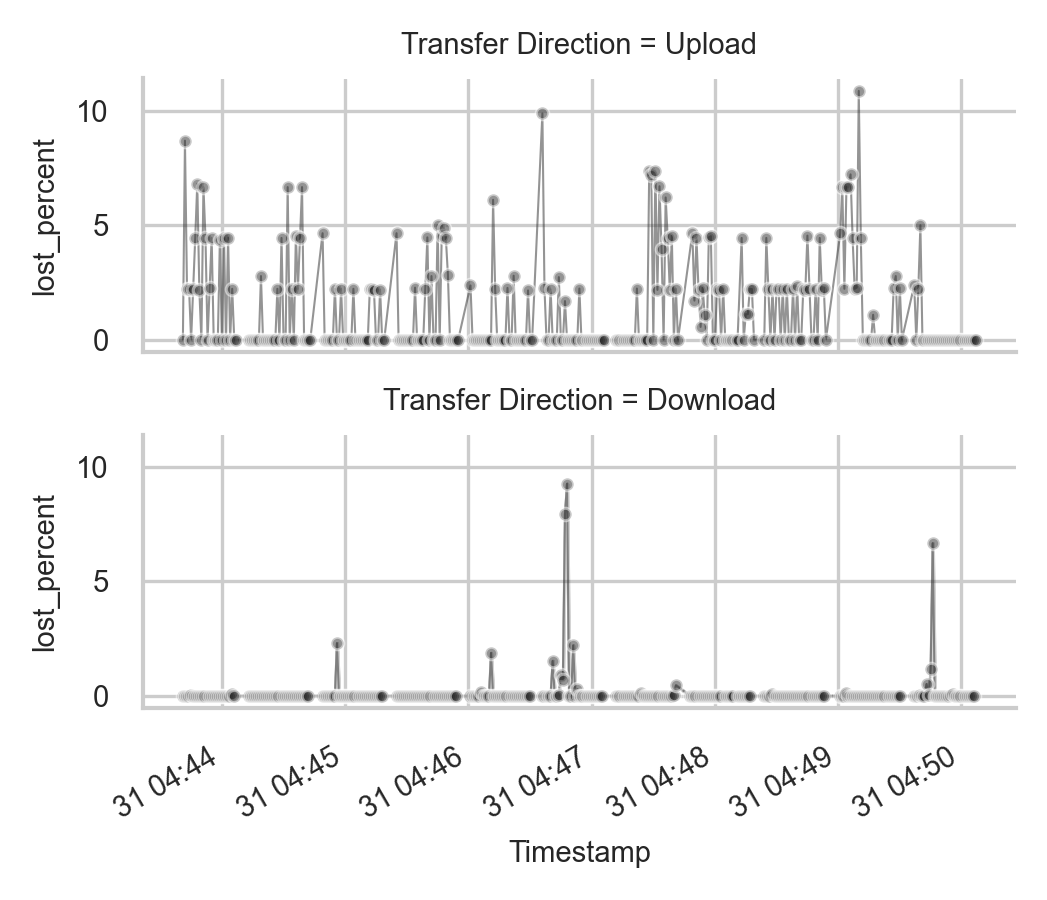

In [105]:
#sns.set(rc={'figure.dpi':96})
df_sample = df_regs
df_sample = df_sample[(df_sample[COL_PARAID].isnull()) & 
                     (df_sample[N_TYPE] == N_STARLINK) &
                     (df_sample[N_REGIONS] == 'N. California') & 
                      (df_sample[N_LOST_PERCENT] < 20)
                        ]
#df_sample = df_sample.groupby([COL_TRANSF_DIR]).resample('3H', on=N_TIMESTAMP).mean().reset_index()
h = 1.5
aspect = common.WIDTH_HALF / h

sns.set_palette('Greys_r')
g_packet_loss = sns.relplot(data=df_sample,
                            #hue=N_REGIONS, hue_order=REG_ORDER,
                            row=COL_TRANSF_DIR,
                            #style=N_TYPE,
                            kind='line', marker='o',
                            height=h,
                            aspect=aspect,
                            palette=['C0', 'C3'],
                            markersize=3,
                            x=N_TIMESTAMP, y=N_LOST_PERCENT,
                           alpha=0.5,
                           )

axes = g_packet_loss.axes.flatten()
g_packet_loss.figure.autofmt_xdate()
g_packet_loss.tight_layout()
plt.show()

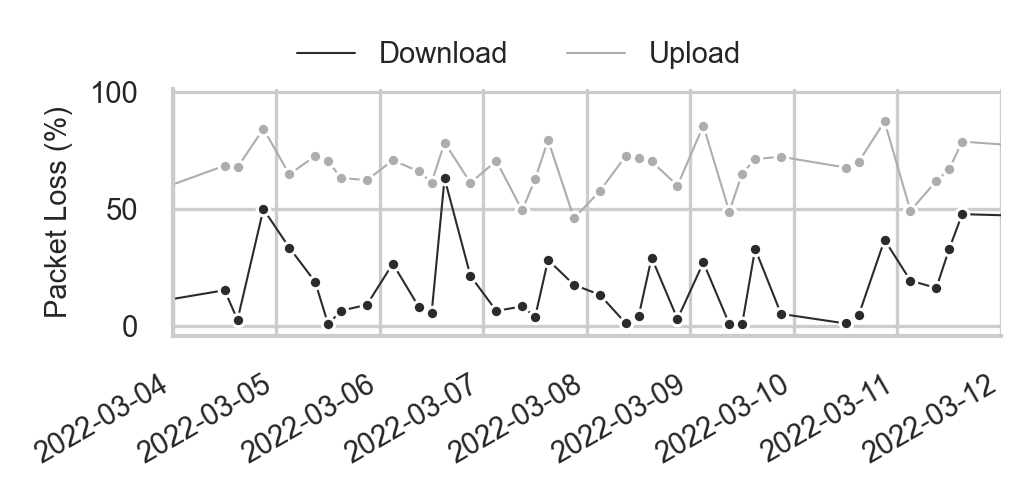

In [86]:
g_packet_loss.set(xlim=(pd.to_datetime('2022-03-04 00:00'), pd.to_datetime('2022-03-12 00:00')))
sns.move_legend(g_packet_loss, loc='lower center', bbox_to_anchor=(0,0.9,0.8,0),
               ncol=2, 
               #mode='expand',
               #fancybox=True, 
                title=None,
               frameon=False,
              )
g_packet_loss.set(ylabel='Packet Loss (%)', xlabel='')
g_packet_loss.tight_layout()
g_packet_loss.figure

In [80]:
g_packet_loss.savefig(os.path.join(OUTPUT_FOLDER, '2022-03-04_packet_loss_3h.pdf'), bbox_inches='tight')

In [ ]:
df_regs_old

In [62]:
timeofday = ['night', 'morning', 'afternoon', 'evening']
df_regs_old['tod'] = pd.cut(df_regs_old[N_TIMESTAMP].dt.hour,
       bins=[0, 6, 12, 18, 24],
       labels=timeofday,
       right=False,
       include_lowest=True)

In [63]:
#df_regs_old.pivot_table(index=[N_TYPE, N_REGIONS, N_PROTOCOL], values='bandwidth', aggfunc='std')
df_temp = df_regs_old[df_regs_old[COL_PARAID].isnull()]
a = df_temp[(df_temp[N_TYPE] == N_STARLINK)].pivot_table(index=[COL_TRANSF_DIR, N_PROTOCOL], values='bandwidth', aggfunc=lambda x: np.percentile(x, 75))
b = df_temp[(df_temp[N_TYPE] == N_HOME)].pivot_table(index=[COL_TRANSF_DIR, N_PROTOCOL], values='bandwidth', aggfunc=lambda x: np.percentile(x, 75))
a_avg = df_temp[(df_temp[N_TYPE] == N_STARLINK) & (df_temp['tod'] == 'night')].pivot_table(index=[COL_TRANSF_DIR, N_PROTOCOL], values='bandwidth')
b_avg = df_temp[(df_temp[N_TYPE] == N_HOME) & (df_temp['tod'] == 'night')].pivot_table(index=[COL_TRANSF_DIR, N_PROTOCOL], values='bandwidth')

#   lambda x: np.percentile(x, 75)

print(a_avg)
print(b_avg)
#std_ratio = ((a / a_avg) / (b / b_avg))
#std_ratio

                              bandwidth
Transfer Direction Protocol            
Download           TCP        50.176351
                   UDP       193.427547
Upload             TCP         7.259658
                   UDP         9.658673
                              bandwidth
Transfer Direction Protocol            
Download           TCP       435.715544
                   UDP       805.317040
Upload             TCP        58.276980
                   UDP       106.045564


In [55]:
pd.concat([a, a_avg, b, b_avg], axis=1)

bandwidth   bandwidth   bandwidth   bandwidth
Transfer Direction Protocol                                               
Download           TCP       48.693656   81.135601  216.438170  402.893366
                   UDP       58.610258  209.562525   62.964875  807.507164
Upload             TCP        4.944755    7.578495   27.417528   48.380701
                   UDP        5.035022   10.155889   19.998395  102.192395

In [21]:
std_ratio.mean().mean()

0.2811569728396874

In [13]:
df_regs_old[df_regs_old[N_TYPE] == N_STARLINK].count()

Timestamp             951838
bandwidth             951838
jitter_ms              79534
lost_packets           79534
packets                79534
lost_percent           79534
snd_cwnd              704486
rtt                   704486
rttvar                704486
retransmits           704486
parallel ID           704486
Regions               951838
Protocol              951838
Transfer Direction    951838
Type                  951838
Protocol and Type     951838
dtype: int64

In [14]:
df_regs_old[(df_regs_old['jitter_ms'] > 30)]

Timestamp  bandwidth     jitter_ms  \
201942         2022-07-04 11:15:23-07:00   0.004119  7.091035e+02   
201943         2022-06-03 13:04:51-07:00   0.007365  4.017913e+02   
201944         2022-05-12 15:33:50-07:00   0.007879  3.780664e+02   
201945         2022-07-04 11:00:35-07:00   0.008982  3.311172e+02   
202099         2022-06-03 12:23:10-07:00   0.022844  1.376512e+02   
202249  2022-03-02 01:12:46.000157-08:00   0.034755  7.122361e+01   
202299         2022-06-03 23:12:17-07:00   0.038919  7.626211e+01   
202301         2022-07-04 11:12:24-07:00   0.042725  7.615051e+01   
202784  2022-03-23 12:46:09.000143-07:00   0.127428  3.903473e+01   
204266  2022-03-23 12:46:10.000109-07:00   0.352874  5.154746e+01   
205019  2022-07-06 04:10:10.000163-07:00   0.440234  4.742365e+02   
205050         2022-06-04 00:30:15-07:00   0.451745  5.902264e+10   
214013  2022-03-23 19:16:03.000279-07:00   0.521385  3.583891e+01   
215926  2022-06-03 11:06:10.001029-07:00   0.533379  4.065428e+01   
218065  2022-03-10 14:08:07.000064-08:00   0.641760  4.304083e+01   
218488  2022-03-06 09:13:41.000570-08:00   0.660589  6.007671e+01   
219422  2022-03-14 09:05:51.000080-07:00   0.718210  3.220080e+01   
219906  2022-03-10 14:15:00.000153-08:00   0.729850  3.386776e+01   
220381  2022-03-23 19:16:04.000079-07:00   0.751249  4.611574e+01   
221692  2022-03-10 14:15:01.000073-08:00   0.826612  3.573301e+01   
221822  2022-03-14 09:05:52.000078-07:00   0.836430  3.220980e+01   
222264  2022-03-10 14:08:06.000062-08:00   0.915135  3.109078e+01   
575888         2022-06-03 21:04:32-07:00   4.297398  2.783778e+08   
687257         2022-06-04 00:12:25-07:00   8.560300  7.579628e+05   
771693         2022-06-03 20:56:13-07:00  12.602548  2.668571e+03   
885450         2022-06-04 00:34:23-07:00  30.209171  5.769966e+01   

        lost_packets  packets  lost_percent  snd_cwnd  rtt  rttvar  \
201942           0.0      4.0      0.000000       NaN  NaN     NaN   
201943           0.0      4.0      0.000000       NaN  NaN     NaN   
201944           0.0      4.0      0.000000       NaN  NaN     NaN   
201945           0.0      4.0      0.000000       NaN  NaN     NaN   
202099           0.0      4.0      0.000000       NaN  NaN     NaN   
202249        6030.0   6033.0     99.950273       NaN  NaN     NaN   
202299           0.0      4.0      0.000000       NaN  NaN     NaN   
202301           0.0      4.0      0.000000       NaN  NaN     NaN   
202784        1480.0   1491.0     99.262240       NaN  NaN     NaN   
204266         168.0    182.0     92.307692       NaN  NaN     NaN   
205019       10549.0  10587.0     99.641069       NaN  NaN     NaN   
205050         145.0    184.0     78.804348       NaN  NaN     NaN   
214013        7348.0   7393.0     99.391316       NaN  NaN     NaN   
215926        3704.0   3750.0     98.773333       NaN  NaN     NaN   
218065         151.0    180.0     83.888889       NaN  NaN     NaN   
218488        6977.0   7034.0     99.189650       NaN  NaN     NaN   
219422        1121.0   1183.0     94.759087       NaN  NaN     NaN   
219906         603.0    666.0     90.540541       NaN  NaN     NaN   
220381         209.0    246.0     84.959350       NaN  NaN     NaN   
221692         103.0    120.0     85.833333       NaN  NaN     NaN   
221822          18.0     21.0     85.714286       NaN  NaN     NaN   
222264         662.0    741.0     89.338731       NaN  NaN     NaN   
575888         486.0    857.0     56.709452       NaN  NaN     NaN   
687257         520.0   1259.0     41.302621       NaN  NaN     NaN   
771693          40.0   1128.0      3.546099       NaN  NaN     NaN   
885450        2489.0   5097.0     48.832647       NaN  NaN     NaN   

        retransmits  parallel ID        Regions Protocol Transfer Direction  \
201942          NaN          NaN      Sao Paulo      UDP           Download   
201943          NaN          NaN         Mumbai      UDP           Download   
201944          NaN          NaN       

In [92]:
df_regs_old[def_regs_old[COL_PARAID].isnull()].pivot_table(columns=[N_REGIONS, N_TYPE], values='bandwidth', aggfunc='count')

NameError: name 'def_regs_old' is not defined

In [148]:
# 98569 1Sec
#df_power = pd.read_csv('data/Power/2022-07-26_dishA_power_data.csv')
#df_power = pd.read_csv('data/Power/2022-07-26_dishA_power_15MIN_data.csv')
df_power = pd.read_csv('data/Power/2022-07-26_dishA_power_1HOUR_data.csv')
df_power

Timestamp  Juuden1_1 (kWhs)
0     05/01/2022 00:00:00            0.0496
1     05/01/2022 01:00:00            0.0496
2     05/01/2022 02:00:00            0.0502
3     05/01/2022 03:00:00            0.0498
4     05/01/2022 04:00:00            0.0492
...                   ...               ...
4572  06/13/2022 17:00:00            0.0091
4573  07/05/2022 09:00:00            0.0200
4574  07/26/2022 08:00:00            0.0178
4575  07/08/2022 23:00:00            0.0056
4576  06/13/2022 11:00:00            0.0316

[4577 rows x 2 columns]

In [124]:
df_power.max()

Timestamp           07/26/2022 09:00:00
Juuden1_1 (kWhs)                 0.1445
dtype: object

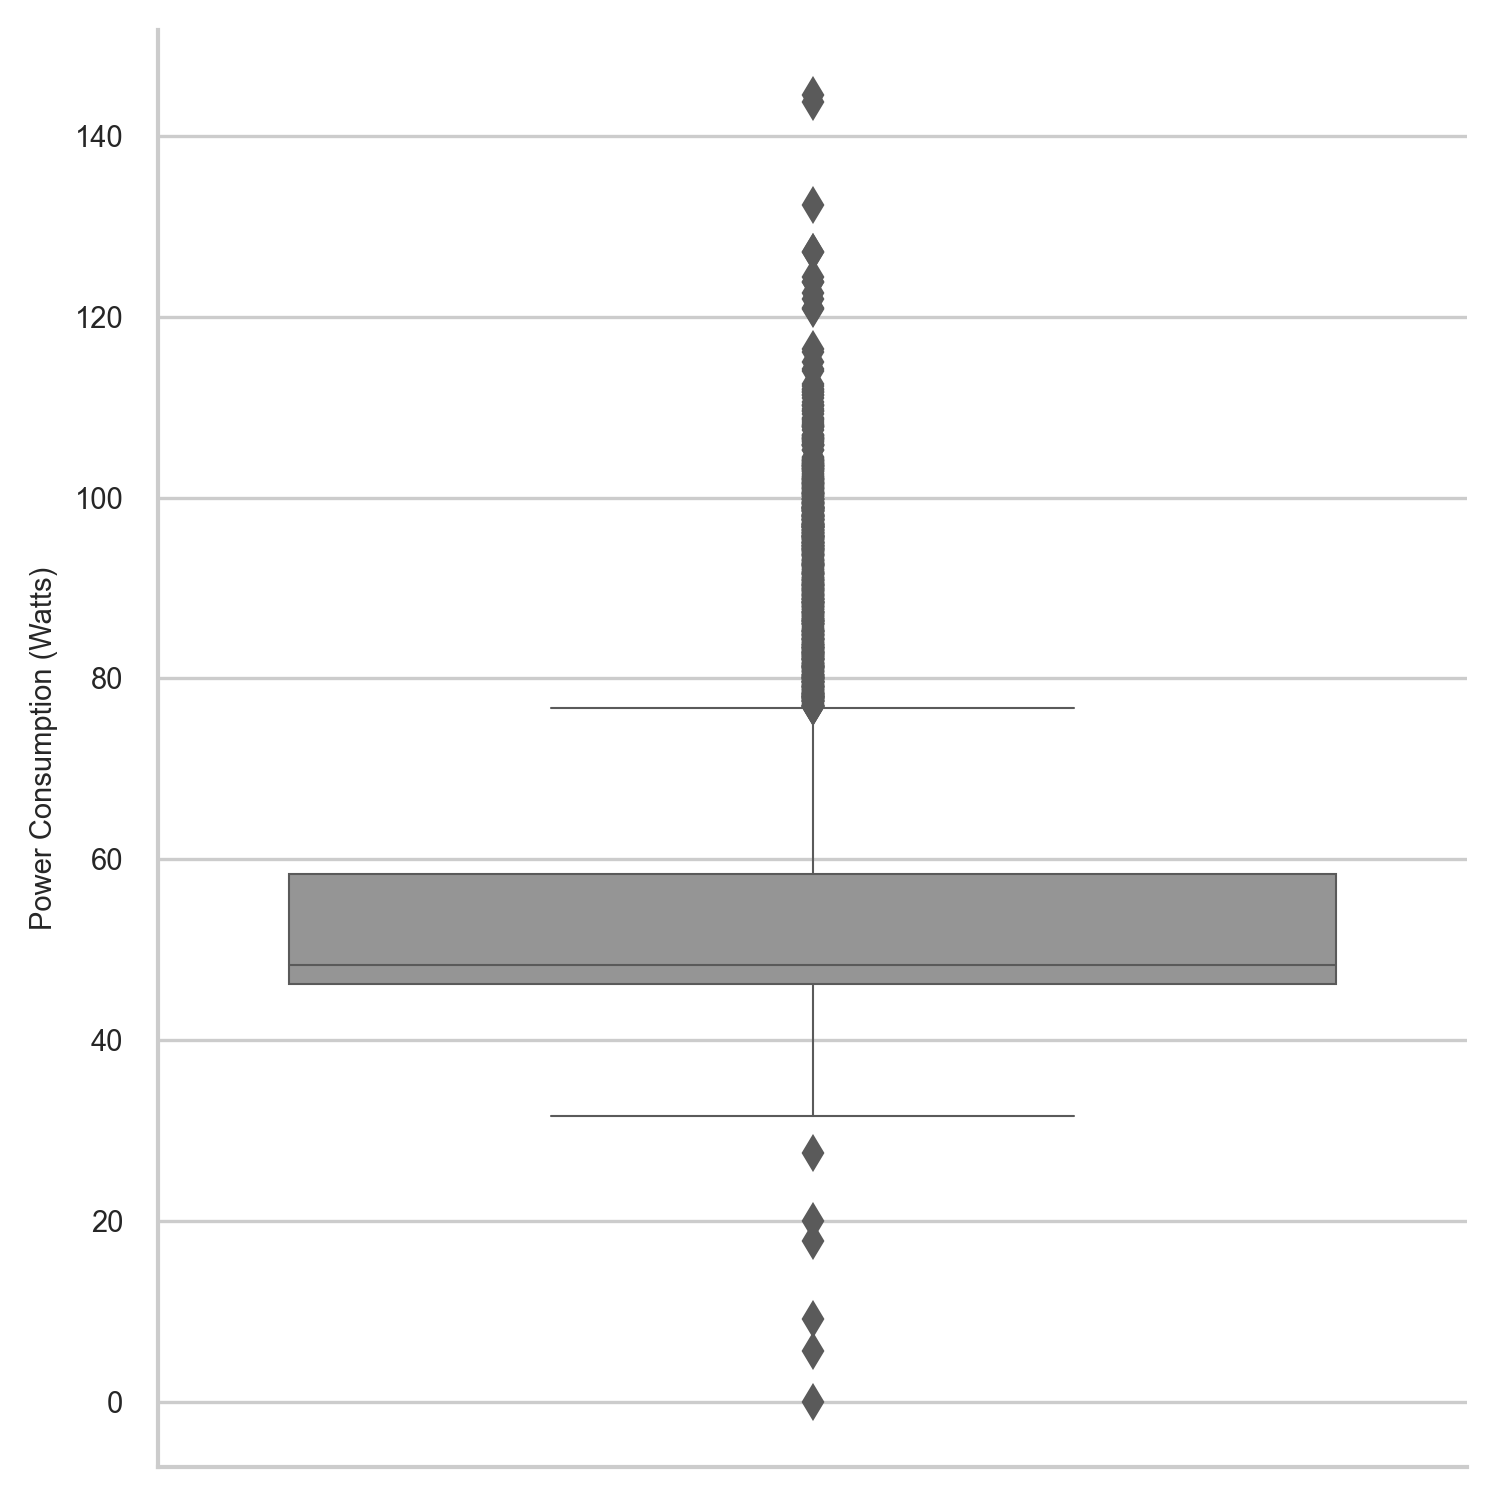

In [472]:
tmp = df_power
#tmp[N_POWER_WATTS] = tmp['Juuden1_1 (kWatts)'] * 1000
tmp[N_POWER_WATTS] = tmp['Juuden1_1 (kWhs)'] * 1000
sns.catplot(data=tmp, y=N_POWER_WATTS, kind='box', palette='Greys')

In [10]:
df_satsv1 = combine_csvs(glob.glob('data/sami_starlink_satellites/*v1.0*'), index=False)
df_satsv1p5 = combine_csvs(glob.glob('data/sami_starlink_satellites/*v1.5*'), index=False)

In [11]:
df_satsv1 = df_satsv1.rename(columns={'timestamp':N_TIMESTAMP})
df_satsv1p5 = df_satsv1p5.rename(columns={'timestamp':N_TIMESTAMP})

In [12]:
df_satsv1[N_TIMESTAMP]

Satellite
STARLINK-1119    1.653024e+12
STARLINK-1083    1.653024e+12
STARLINK-1107    1.653024e+12
STARLINK-1231    1.653024e+12
STARLINK-1235    1.653024e+12
                     ...     
STARLINK-1793    1.658103e+12
STARLINK-2347    1.658103e+12
STARLINK-2258    1.658103e+12
STARLINK-2291    1.658103e+12
STARLINK-2685    1.658103e+12
Name: Timestamp, Length: 67041607, dtype: float64

In [13]:
df_satsv1[N_TIMESTAMP] = pd.to_datetime(df_satsv1[N_TIMESTAMP], unit='ms', origin='unix').dt.tz_localize('UTC').dt.floor('s')
df_satsv1p5[N_TIMESTAMP] = pd.to_datetime(df_satsv1p5[N_TIMESTAMP], unit='ms', origin='unix').dt.tz_localize('UTC').dt.floor('s')

In [15]:
df_sats_cat = pd.concat([df_satsv1, df_satsv1p5])

In [16]:
df_sats_cat.sort_values(N_TIMESTAMP)

LATENCY     Az    El  Link                 Timestamp  \
Satellite                                                             
STARLINK-1100      NaN   94.0  28.0   FOV 2022-05-20 05:11:21+00:00   
STARLINK-2605     5.35  307.0  31.0  SERV 2022-05-20 05:11:21+00:00   
STARLINK-2641     6.02   52.0  31.0  SERV 2022-05-20 05:11:21+00:00   
STARLINK-2591     5.04  302.0  49.0  SERV 2022-05-20 05:11:21+00:00   
STARLINK-2299     4.85   53.0  46.0  SERV 2022-05-20 05:11:21+00:00   
...                ...    ...   ...   ...                       ...   
STARLINK-3174     5.15  277.0  48.0  SERV 2022-07-19 01:24:12+00:00   
STARLINK-3387      NaN   91.0  28.0   FOV 2022-07-19 01:24:12+00:00   
NaN                NaN    NaN   NaN   NaN                       NaT   
NaN                NaN    NaN   NaN   NaN                       NaT   
STARLINK-3449      NaN    NaN   NaN   NaN                       NaT   

               connectable_sats  
Satellite                        
STARLINK-1100              10.0  
STARLINK-2605              10.0  
STARLINK-2641              10.0  
STARLINK-2591              10.0  
STARLINK-2299              10.0  
...                         ...  
STARLINK-3174               4.0  
STARLINK-3387               4.0  
NaN                         NaN  
NaN                         NaN  
STARLINK-3449               NaN  

[86918545 rows x 6 columns]

In [17]:
df_sats_cat.to_csv('data/sami_starlink_satellites_all_2022-07-19.csv')

In [23]:
df_regs.to_csv(f'{OUTPUT_FOLDER}/2022-07-07_end_all_starlink_iperf3.csv', index=False)

In [19]:
df_regs.sort_values('timestamp')

timestamp  bandwidth  ...      Type  Protocol and Type
3870 2022-07-17 02:01:26.000464896   4.947466  ...  Remote H       TCP Remote H
2618 2022-07-17 02:01:26.000464896   2.688082  ...  Remote H       TCP Remote H
3121 2022-07-17 02:01:26.000464896   3.325375  ...  Remote H       TCP Remote H
2675 2022-07-17 02:01:26.000464896   3.093615  ...  Remote H       TCP Remote H
1977 2022-07-17 02:01:27.000243968   2.085033  ...  Remote H       TCP Remote H
...                            ...        ...  ...       ...                ...
4793 2022-07-17 04:15:08.000111104   7.355524  ...  Remote H       TCP Remote H
2769 2022-07-17 04:15:08.000150016   3.127467  ...  Remote H       TCP Remote H
3756 2022-07-17 04:15:08.000150016   4.691201  ...  Remote H       TCP Remote H
3497 2022-07-17 04:15:08.000150016   4.170056  ...  Remote H       TCP Remote H
2764 2022-07-17 04:15:08.000150016   3.127442  ...  Remote H       TCP Remote H

[8561 rows x 16 columns]

In [296]:
df_regs[df_regs['parallel ID'].isnull()]

Timestamp  ...  Protocol and Type
5753  2022-07-25 03:18:58.001041920-07:00  ...       TCP Starlink
5754  2022-07-25 03:18:55.000890112-07:00  ...       TCP Starlink
5755  2022-07-25 03:18:53.001574912-07:00  ...       TCP Starlink
5756  2022-07-25 03:18:52.000788224-07:00  ...       TCP Starlink
5757  2022-07-25 03:18:50.000907264-07:00  ...       TCP Starlink
...                                   ...  ...                ...
10042 2022-07-25 03:31:14.000361216-07:00  ...       TCP Starlink
10043 2022-07-25 03:22:18.000392192-07:00  ...       TCP Starlink
10044 2022-07-25 03:24:25.000748032-07:00  ...       TCP Starlink
10045 2022-07-25 03:22:24.000314112-07:00  ...       TCP Starlink
10046 2022-07-25 03:24:22.000907776-07:00  ...       TCP Starlink

[2063 rows x 15 columns]

In [305]:
df_regs[(df_regs['bandwidth'] == 0) & (df_regs['parallel ID'].isnull())].pivot_table(index=COL_TRANSF_DIR, values='bandwidth', aggfunc='count')

bandwidth
Transfer Direction           
Download                  271
Upload                    295

In [310]:
df_regs[(df_regs['parallel ID'].isnull())].pivot_table(index=COL_TRANSF_DIR, values='bandwidth', aggfunc='count')

bandwidth
Transfer Direction           
Download                  997
Upload                   1066

In [110]:
df_regs[(df_regs['parallel ID'].isnull())].pivot_table(index=COL_TRANSF_DIR, columns=[N_TYPE, N_PROTOCOL], values='bandwidth', aggfunc='max')

Type                  Starlink             Terrestrial            
Protocol                   TCP         UDP         TCP         UDP
Transfer Direction                                                
Download            346.095263  362.619742  849.113524  841.135643
Upload               37.787612   63.986151  143.215739  118.482285

In [23]:
df_regs.pivot_table(columns=[N_PROTOCOL, COL_TRANSF_DIR])

Protocol                      TCP                          UDP             
Transfer Direction       Download         Upload      Download       Upload
bandwidth               13.386783       4.097664    105.891006    12.762187
jitter_ms                     NaN            NaN      0.145146     1.209390
lost_packets                  NaN            NaN  21244.816156  3350.905797
lost_percent                  NaN            NaN     69.922212    59.299818
packets                       NaN            NaN  30385.963788  4430.856280
parallel ID              1.500000       1.500000           NaN          NaN
retransmits             14.793860       2.316641           NaN          NaN
rtt                 279427.500877  282562.109399           NaN          NaN
rttvar               12964.766959   17323.810092           NaN          NaN
snd_cwnd            312786.205848   87471.805855           NaN          NaN

In [24]:
df_regs.pivot_table(columns=[N_PROTOCOL, COL_TRANSF_DIR], aggfunc='max')

Protocol                                      TCP  ...                            UDP
Transfer Direction                       Download  ...                         Upload
Protocol and Type                    TCP Remote H  ...                   UDP Remote H
Regions                                     Tokyo  ...                          Tokyo
Type                                     Remote H  ...                       Remote H
bandwidth                              149.924189  ...                      46.108102
jitter_ms                                     NaN  ...                      14.247953
lost_packets                                  NaN  ...                        67965.0
lost_percent                                  NaN  ...                      99.446657
packets                                       NaN  ...                        70155.0
parallel ID                                   3.0  ...                            NaN
retransmits                                 643.0  ...                            NaN
rtt                                     1058689.0  ...                            NaN
rttvar                                   997290.0  ...                            NaN
snd_cwnd                                2112632.0  ...                            NaN
timestamp           2022-07-17 04:15:08.000111104  ...  2022-07-17 03:06:43.000068864

[14 rows x 4 columns]

In [69]:
df_regs = df_regs[df_regs['timestamp'] < '2022-07-17 03:15']
df_regs.sort_values('timestamp')

timestamp  bandwidth  ...      Type  Protocol and Type
3870 2022-07-17 02:01:26.000464896   4.947466  ...  Remote H       TCP Remote H
2618 2022-07-17 02:01:26.000464896   2.688082  ...  Remote H       TCP Remote H
2675 2022-07-17 02:01:26.000464896   3.093615  ...  Remote H       TCP Remote H
3121 2022-07-17 02:01:26.000464896   3.325375  ...  Remote H       TCP Remote H
1976 2022-07-17 02:01:27.000243968   2.085033  ...  Remote H       TCP Remote H
...                            ...        ...  ...       ...                ...
4787 2022-07-17 03:07:33.000108032   7.330129  ...  Remote H       TCP Remote H
114  2022-07-17 03:07:33.000151040   0.000000  ...  Remote H       TCP Remote H
3198 2022-07-17 03:07:33.000151040   3.648362  ...  Remote H       TCP Remote H
1465 2022-07-17 03:07:33.000151040   1.563552  ...  Remote H       TCP Remote H
1462 2022-07-17 03:07:33.000151040   1.563549  ...  Remote H       TCP Remote H

[8288 rows x 16 columns]

In [78]:
df_regs_old[(df_regs_old['jitter_ms'] > 20)].sort_values(N_TIMESTAMP)

Timestamp  bandwidth     jitter_ms  \
202249 2022-03-02 09:12:46.000157952+00:00   0.034755  7.122361e+01   
218488 2022-03-06 17:13:41.000570112+00:00   0.660589  6.007671e+01   
221363 2022-03-06 17:13:42.000114176+00:00   0.799328  2.153662e+01   
282753 2022-03-06 17:13:48.000089856+00:00   1.424849  2.010279e+01   
219079 2022-03-07 17:10:06.000071168+00:00   0.706502  2.285901e+01   
220515 2022-03-07 22:17:20.000078080+00:00   0.757528  2.359241e+01   
335501 2022-03-08 04:05:42.000081920+00:00   1.711743  2.152637e+01   
548152 2022-03-08 09:12:40.000065024+00:00   4.042804  2.101065e+01   
280375 2022-03-08 09:12:41.000067840+00:00   1.300957  2.754319e+01   
222264 2022-03-10 22:08:06.000062976+00:00   0.915135  3.109078e+01   
218065    2022-03-10 22:08:07.000064+00:00   0.641760  4.304083e+01   
219906 2022-03-10 22:15:00.000153088+00:00   0.729850  3.386776e+01   
221692 2022-03-10 22:15:01.000073984+00:00   0.826612  3.573301e+01   
219422 2022-03-14 16:05:51.000080896+00:00   0.718210  3.220080e+01   
221822 2022-03-14 16:05:52.000078080+00:00   0.836430  3.220980e+01   
222202 2022-03-14 16:15:43.000075776+00:00   0.903555  2.881862e+01   
280390 2022-03-14 16:15:44.000072960+00:00   1.304112  2.845970e+01   
222921 2022-03-21 10:22:26.000105984+00:00   0.973075  2.651810e+01   
281455 2022-03-21 10:22:27.000087040+00:00   1.350351  2.723508e+01   
204447 2022-03-23 19:45:58.000123136+00:00   0.370687  2.036381e+01   
202784 2022-03-23 19:46:09.000143104+00:00   0.127428  3.903473e+01   
204266 2022-03-23 19:46:10.000109056+00:00   0.352874  5.154746e+01   
214013 2022-03-24 02:16:03.000279808+00:00   0.521385  3.583891e+01   
220381 2022-03-24 02:16:04.000079104+00:00   0.751249  4.611574e+01   
281668 2022-03-28 16:10:39.000068864+00:00   1.361334  2.125733e+01   
333995 2022-03-31 03:07:06.000100864+00:00   1.621801  2.383607e+01   
281828 2022-03-31 03:07:07.000075776+00:00   1.376914  2.452289e+01   
201944           2022-05-12 22:33:50+00:00   0.007879  3.780664e+02   
204801 2022-05-12 22:35:52.000123136+00:00   0.416995  2.511370e+01   
215926 2022-06-03 18:06:10.001029120+00:00   0.533379  4.065428e+01   
202099           2022-06-03 19:23:10+00:00   0.022844  1.376512e+02   
201943           2022-06-03 20:04:51+00:00   0.007365  4.017913e+02   
339218 2022-06-03 21:10:34.000076032+00:00   1.992548  2.131990e+01   
338263 2022-06-03 21:10:35.000026112+00:00   1.926926  2.045228e+01   
202896 2022-06-03 22:12:38.000415744+00:00   0.150628  2.957518e+01   
201955 2022-06-03 22:12:39.000178688+00:00   0.011576  2.907975e+01   
124293 2022-06-03 22:12:40.000907776+00:00   0.000000  2.907975e+01   
771693           2022-06-04 03:56:13+00:00  12.602548  2.668571e+03   
575888           2022-06-04 04:04:32+00:00   4.297398  2.783778e+08   
202299           2022-06-04 06:12:17+00:00   0.038919  7.626211e+01   
687257           2022-06-04 07:12:25+00:00   8.560300  7.579628e+05   
205050           2022-06-04 07:30:15+00:00   0.451745  5.902264e+10   
885450           2022-06-04 07:34:23+00:00  30.209171  5.769966e+01   
201945           2022-07-04 18:00:35+00:00   0.008982  3.311172e+02   
202301           2022-07-04 18:12:24+00:00   0.042725  7.615051e+01   
201942           2022-07-04 18:15:23+00:00   0.004119  7.091035e+02   
286528 2022-07-04 23:02:27.000073984+00:00   1.529079  2.835418e+01   
144809 2022-07-04 23:02:28.000080128+00:00   0.000000  2.835418e+01   
205019 2022-07-06 11:10:10.000163072+00:00   0.440234  4.742365e+02   

        lost_packets  packets  lost_percent  snd_cwnd  rtt  rttvar  \
202249        6030.0   6033.0     99.950273       NaN  NaN     NaN   
218488        6977.0   7034.0     99.189650       NaN  NaN     NaN   
221363        2418.0   2487.0     97.225573       NaN  NaN     NaN   
282753         685.0    808.0     84.777228       NaN  NaN     NaN   
219079         931.0    992.0     93.850806       NaN  NaN     NaN   
220515         663.0    716.0     92.597765       NaN  NaN    

In [362]:
df_regs_old.sort_values('timestamp')

timestamp  ...           Timestamp
294623 2022-01-19 01:55:24.000022016  ... 2022-01-19 01:55:24
295939 2022-01-19 01:55:25.000065024  ... 2022-01-19 01:55:25
302568 2022-01-19 01:55:26.000061952  ... 2022-01-19 01:55:26
299166 2022-01-19 01:55:27.000076032  ... 2022-01-19 01:55:27
294959 2022-01-19 01:55:28.000128000  ... 2022-01-19 01:55:28
...                              ...  ...                 ...
130878 2022-06-05 05:15:04.000073984  ... 2022-06-05 05:15:04
281461 2022-06-05 05:15:04.000165888  ... 2022-06-05 05:15:04
216796 2022-06-05 05:15:05.000022016  ... 2022-06-05 05:15:05
127481 2022-06-05 05:15:05.000070144  ... 2022-06-05 05:15:05
123474 2022-06-05 05:15:06.000071936  ... 2022-06-05 05:15:06

[361850 rows x 12 columns]

In [281]:
df_regs_all  = df_regs
#df_regs_all[N_TYPE] = df_regs[N_TYPE].map({N_STARLINK: N_STARLINK_KOEYE})
df_regs_all = pd.concat([df_regs_all, df_regs_old])
df_regs_all

timestamp   bandwidth        Regions Protocol  \
0      2022-05-22 14:22:11.000772864    0.000000  N. California      UDP   
1      2022-05-23 11:10:11.001047040    0.000000         Sydney      TCP   
2      2022-05-23 11:10:10.001053184    0.000000         Sydney      TCP   
3      2022-05-23 11:10:09.001121024    0.000000         Sydney      TCP   
4      2022-05-23 11:10:08.001053952    0.000000         Sydney      TCP   
...                              ...         ...            ...      ...   
361845 2022-05-28 22:09:51.000088832  836.142764  N. California      TCP   
361846 2022-05-29 14:10:28.000004096  838.120572  N. California      UDP   
361847 2022-05-28 10:01:02.000055040  838.443014         Sydney      UDP   
361848 2022-05-30 17:09:39.000015104  842.372040  N. California      TCP   
361849 2022-05-28 23:09:43.000055040  844.888201  N. California      TCP   

       Transfer Direction             Type    Protocol and Type  jitter_ms  \
0                  Upload  Starlink Remote  UDP Starlink Remote   0.000000   
1                Download  Starlink Remote  TCP Starlink Remote        NaN   
2                Download  Starlink Remote  TCP Starlink Remote        NaN   
3                Download  Starlink Remote  TCP Starlink Remote        NaN   
4                Download  Starlink Remote  TCP Starlink Remote        NaN   
...                   ...              ...                  ...        ...   
361845           Download             Home             TCP Home        NaN   
361846           Download             Home             UDP Home   0.070071   
361847           Download             Home             UDP Home   0.055429   
361848           Download             Home             TCP Home        NaN   
361849           Download             Home             TCP Home        NaN   

        lost_packets  packets  lost_percent  
0                0.0      0.0      0.000000  
1                NaN      NaN           NaN  
2                NaN      NaN           NaN  
3                NaN      NaN           NaN  
4                NaN      NaN           NaN  
...              ...      ...           ...  
361845           NaN      NaN           NaN  
361846         617.0  72969.0      0.845565  
361847         793.0  73169.0      1.083792  
361848           NaN      NaN           NaN  
361849           NaN      NaN           NaN  

[407341 rows x 11 columns]

In [13]:
# Differentiate outliers
N_THROUGHPUT_OUTLIERS = 'Throughput Outliers'
df_outliers = df_regs_old.copy()
#zscore = np.abs(stats.zscore(df_outliers['bandwidth'], nan_policy='omit'))
zscore = np.abs(df_outliers.groupby([
    N_TYPE, COL_TRANSF_DIR, N_PROTOCOL, N_REGIONS])['bandwidth'].transform(
    lambda x : stats.zscore(x, ddof=1, nan_policy='omit')
))
df_outliers[N_THROUGHPUT_OUTLIERS] = zscore >= 3
df_outliers = df_outliers.sort_values('bandwidth')
df_outliers

Timestamp   bandwidth  jitter_ms  \
0       2022-01-26 03:50:55.000403968+00:00    0.000000        NaN   
134623  2022-02-05 22:27:14.000396032+00:00    0.000000        NaN   
134624  2022-02-05 22:27:16.000547072+00:00    0.000000        NaN   
134625  2022-06-04 23:05:05.000243968+00:00    0.000000        NaN   
134626  2022-06-04 23:05:05.000243968+00:00    0.000000        NaN   
...                                     ...         ...        ...   
1336856 2022-05-28 10:01:02.000055040+00:00  838.443014   0.055429   
1336857 2022-07-05 11:06:45.000055040+00:00  841.135643   0.018978   
1336858 2022-05-30 17:09:39.000015104+00:00  842.372040        NaN   
1336859 2022-05-28 23:09:43.000055040+00:00  844.888201        NaN   
1336860 2022-07-06 19:08:52.000093952+00:00  849.113524        NaN   

         lost_packets  packets  lost_percent  snd_cwnd       rtt   rttvar  \
0                 NaN      NaN           NaN   18824.0  244901.0   6501.0   
134623            NaN      NaN           NaN   57920.0  223947.0   3796.0   
134624            NaN      NaN           NaN   57920.0  227622.0  17663.0   
134625            NaN      NaN           NaN  792056.0  299073.0   9855.0   
134626            NaN      NaN           NaN  192584.0  299773.0  13054.0   
...               ...      ...           ...       ...       ...      ...   
1336856         793.0  73169.0      1.083792       NaN       NaN      NaN   
1336857        2995.0  75603.0      3.961483       NaN       NaN      NaN   
1336858           NaN      NaN           NaN       NaN       NaN      NaN   
1336859           NaN      NaN           NaN       NaN       NaN      NaN   
1336860           NaN      NaN           NaN       NaN       NaN      NaN   

         retransmits  parallel ID        Regions Protocol Transfer Direction  \
0                0.0          2.0         Sydney      TCP             Upload   
134623           0.0          3.0      Singapore      TCP             Upload   
134624           0.0          3.0      Singapore      TCP             Upload   
134625           0.0          2.0         Mumbai      TCP           Download   
134626           0.0          3.0         Mumbai      TCP           Download   
...              ...          ...            ...      ...                ...   
1336856          NaN          NaN         Sydney      UDP           Download   
1336857          NaN          NaN        Bahrain      UDP           Download   
1336858          NaN          NaN  N. California      TCP           Download   
1336859          NaN          NaN  N. California      TCP           Download   
1336860          NaN          NaN  N. California      TCP           Download   

                Type Protocol and Type  Throughput Outliers  
0           Starlink      TCP Starlink                False  
134623      Starlink      TCP Starlink                False  
134624      Starlink      TCP Starlink                False  
134625      Starlink      TCP Starlink                False  
134626      Starlink      TCP Starlink                False  
...              ...               ...                  ...  
1336856  Terrestrial   UDP Terrestrial                False  
1336857  Terrestrial   UDP Terrestrial                False  
1336858  Terrestrial   TCP Terrestrial                False  
1336859  Terrestrial   TCP Terrestrial                False  
1336860  Terrestrial   TCP Terrestrial                False  

[1336861 rows x 17 columns]

In [343]:
df_outliers.sort_values('timestamp')

timestamp   bandwidth  jitter_ms  lost_packets  \
994492  2022-01-19 01:55:24.000022016  148.455179        NaN           NaN   
996040  2022-01-19 01:55:25.000065024  150.932930        NaN           NaN   
1013454 2022-01-19 01:55:26.000061952  159.103829        NaN           NaN   
999604  2022-01-19 01:55:27.000076032  155.471983        NaN           NaN   
994876  2022-01-19 01:55:28.000128000  148.963180        NaN           NaN   
...                               ...         ...        ...           ...   
1054129 2022-07-08 03:18:03.000161792  213.182237   0.110901       11973.0   
555680  2022-07-08 03:18:04.000071168    7.101021   0.943322        4974.0   
1057207 2022-07-08 03:18:04.000098816  229.594838   0.161055       10400.0   
581333  2022-07-08 03:18:05.000067072    8.942731   0.902654        4015.0   
555743  2022-07-08 03:18:06.000080128    7.112618   5.722875        1882.0   

         packets  lost_percent  snd_cwnd  rtt  rttvar  retransmits  \
994492       NaN           NaN       NaN  NaN     NaN          NaN   
996040       NaN           NaN       NaN  NaN     NaN          NaN   
1013454      NaN           NaN       NaN  NaN     NaN          NaN   
999604       NaN           NaN       NaN  NaN     NaN          NaN   
994876       NaN           NaN       NaN  NaN     NaN          NaN   
...          ...           ...       ...  ...     ...          ...   
1054129  30375.0     39.417284       NaN  NaN     NaN          NaN   
555680    5587.0     89.028101       NaN  NaN     NaN          NaN   
1057207  30222.0     34.412018       NaN  NaN     NaN          NaN   
581333    4787.0     83.872989       NaN  NaN     NaN          NaN   
555743    2496.0     75.400641       NaN  NaN     NaN          NaN   

         parallel ID    Regions Protocol Transfer Direction         Type  \
994492           NaN     Sydney      TCP           Download  Terrestrial   
996040           NaN     Sydney      TCP           Download  Terrestrial   
1013454          NaN     Sydney      TCP           Download  Terrestrial   
999604           NaN     Sydney      TCP           Download  Terrestrial   
994876           NaN     Sydney      TCP           Download  Terrestrial   
...              ...        ...      ...                ...          ...   
1054129          NaN  Cape Town      UDP           Download     Starlink   
555680           NaN  Cape Town      UDP             Upload     Starlink   
1057207          NaN  Cape Town      UDP           Download     Starlink   
581333           NaN  Cape Town      UDP             Upload     Starlink   
555743           NaN  Cape Town      UDP             Upload     Starlink   

        Protocol and Type  Throughput Outliers  
994492    TCP Terrestrial                False  
996040    TCP Terrestrial                False  
1013454   TCP Terrestrial                False  
999604    TCP Terrestrial                False  
994876    TCP Terrestrial                False  
...                   ...                  ...  
1054129      UDP Starlink                False  
555680       UDP Starlink                False  
1057207      UDP Starlink                False  
581333       UDP Starlink                False  
555743       UDP Starlink                False  

[1119031 rows x 17 columns]

In [320]:
df_outliers[df_outliers[N_THROUGHPUT_OUTLIERS] == True]

timestamp   bandwidth  jitter_ms  lost_packets  \
124192  2022-07-04 23:10:08.001369088    0.000000   0.084238           0.0   
124193  2022-07-04 23:10:07.000189184    0.000000   0.084238           0.0   
124194  2022-07-04 23:10:06.001327104    0.000000   0.084238           0.0   
124195  2022-07-04 23:10:05.000171776    0.000000   0.084238           0.0   
124196  2022-07-04 23:10:04.000732928    0.000000   0.084238           0.0   
...                               ...         ...        ...           ...   
1093087 2022-05-31 02:11:45.000013056  774.420538   0.017145        4914.0   
1093090 2022-05-31 05:11:49.000055040  774.576634   0.022424        4966.0   
1093157 2022-06-05 03:10:43.000053760  777.690509   0.019192        4698.0   
1093197 2022-07-06 03:10:24.000006912  779.035584   0.023045        6982.0   
1093211 2022-05-31 05:11:36.000008192  779.520532   0.035124        4466.0   

         packets  lost_percent  snd_cwnd  rtt  rttvar  retransmits  \
124192       0.0      0.000000       NaN  NaN     NaN          NaN   
124193       0.0      0.000000       NaN  NaN     NaN          NaN   
124194       0.0      0.000000       NaN  NaN     NaN          NaN   
124195       0.0      0.000000       NaN  NaN     NaN          NaN   
124196       0.0      0.000000       NaN  NaN     NaN          NaN   
...          ...           ...       ...  ...     ...          ...   
1093087  71766.0      6.847254       NaN  NaN     NaN          NaN   
1093090  71829.0      6.913642       NaN  NaN     NaN          NaN   
1093157  71830.0      6.540443       NaN  NaN     NaN          NaN   
1093197  74233.0      9.405520       NaN  NaN     NaN          NaN   
1093211  71759.0      6.223610       NaN  NaN     NaN          NaN   

         parallel ID    Regions Protocol Transfer Direction      Type  \
124192           NaN  Sao Paulo      UDP           Download  Starlink   
124193           NaN  Sao Paulo      UDP           Download  Starlink   
124194           NaN  Sao Paulo      UDP           Download  Starlink   
124195           NaN  Sao Paulo      UDP           Download  Starlink   
124196           NaN  Sao Paulo      UDP           Download  Starlink   
...              ...        ...      ...                ...       ...   
1093087          NaN  Cape Town      UDP           Download      Home   
1093090          NaN  Cape Town      UDP           Download      Home   
1093157          NaN  Cape Town      UDP           Download      Home   
1093197          NaN  Cape Town      UDP           Download      Home   
1093211          NaN  Cape Town      UDP           Download      Home   

        Protocol and Type  Throughput Outliers  
124192       UDP Starlink                 True  
124193       UDP Starlink                 True  
124194       UDP Starlink                 True  
124195       UDP Starlink                 True  
124196       UDP Starlink                 True  
...                   ...                  ...  
1093087          UDP Home                 True  
1093090          UDP Home                 True  
1093157          UDP Home                 True  
1093197          UDP Home                 True  
1093211          UDP Home                 True  

[14731 rows x 17 columns]

In [344]:
#df_outliers.to_csv(f'{OUTPUT_FOLDER}/2022-07-08_koeye_starlink_iperf3.csv')

In [18]:
# Get nighttime
hours = df_regs.timestamp.dt.hour
mask = (hours >= 22) | (hours <= 5)
df_regs[mask]

timestamp   bandwidth    Regions Protocol  \
0     2022-05-23 03:04:15.001032960    0.000000  Singapore      UDP   
21    2022-05-23 04:22:17.000372992    0.000000  Cape Town      TCP   
22    2022-05-23 04:22:15.000132864    0.000000  Cape Town      TCP   
24    2022-05-23 02:22:34.001027840    0.000000  Sao Paulo      UDP   
25    2022-05-23 02:22:35.001026816    0.000000  Sao Paulo      UDP   
...                             ...         ...        ...      ...   
23033 2022-05-23 02:22:40.000085760  107.117350  Sao Paulo      UDP   
23038 2022-05-23 03:37:00.000086016  107.696448  Cape Town      UDP   
23041 2022-05-23 03:36:59.000086016  107.893376  Cape Town      UDP   
23042 2022-05-23 02:22:39.000087040  107.905089  Sao Paulo      UDP   
23045 2022-05-23 00:06:56.812720128  123.032775      Tokyo      UDP   

      Transfer Direction             Type    Protocol and Type  jitter_ms  \
0                 Upload  Starlink Remote  UDP Starlink Remote   0.000000   
21                Upload  Starlink Remote  TCP Starlink Remote        NaN   
22                Upload  Starlink Remote  TCP Starlink Remote        NaN   
24                Upload  Starlink Remote  UDP Starlink Remote   0.000000   
25                Upload  Starlink Remote  UDP Starlink Remote   0.000000   
...                  ...              ...                  ...        ...   
23033           Download  Starlink Remote  UDP Starlink Remote   0.589082   
23038           Download  Starlink Remote  UDP Starlink Remote   0.268433   
23041           Download  Starlink Remote  UDP Starlink Remote   0.342688   
23042           Download  Starlink Remote  UDP Starlink Remote   1.899351   
23045           Download  Starlink Remote  UDP Starlink Remote   0.273012   

       lost_packets  packets  lost_percent  
0               0.0      0.0      0.000000  
21              NaN      NaN           NaN  
22              NaN      NaN           NaN  
24              0.0      0.0      0.000000  
25              0.0      0.0      0.000000  
...             ...      ...           ...  
23033       17134.0  26381.0     64.948258  
23038       13285.0  22582.0     58.830042  
23041       16088.0  25402.0     63.333596  
23042       19160.0  28475.0     67.287094  
23045       30817.0  32807.0     93.934221  

[8955 rows x 11 columns]

In [185]:
df_outage = df_regs[df_regs['parallel ID'].isnull()].fillna(-1)
df_outage = df_outage[df_outage['bandwidth'] == 0].dropna(how='all')
df_outage

timestamp  bandwidth  ...      Type  Protocol and Type
165  2022-07-22 03:58:05.001059072        0.0  ...  Starlink       TCP Starlink
166  2022-07-22 03:58:04.000209920        0.0  ...  Starlink       TCP Starlink
170  2022-07-22 03:51:53.001067264        0.0  ...  Starlink       TCP Starlink
171  2022-07-22 03:51:52.001067264        0.0  ...  Starlink       TCP Starlink
172  2022-07-22 03:58:06.001058048        0.0  ...  Starlink       TCP Starlink
...                            ...        ...  ...       ...                ...
2301 2022-07-22 03:58:09.001060096        0.0  ...  Starlink       TCP Starlink
2305 2022-07-22 03:58:08.001063168        0.0  ...  Starlink       TCP Starlink
2306 2022-07-22 03:58:07.001095168        0.0  ...  Starlink       TCP Starlink
2307 2022-07-22 03:58:06.001058048        0.0  ...  Starlink       TCP Starlink
2316 2022-07-22 03:58:05.001059072        0.0  ...  Starlink       TCP Starlink

[254 rows x 16 columns]

In [19]:
df_outliers.dtypes

Timestamp               object
bandwidth              float64
jitter_ms              float64
lost_packets           float64
packets                float64
lost_percent           float64
snd_cwnd               float64
rtt                    float64
rttvar                 float64
retransmits            float64
parallel ID            float64
Regions                 object
Protocol                object
Transfer Direction      object
Type                    object
Protocol and Type       object
Throughput Outliers       bool
dtype: object

In [15]:
# Aggreagation options
#df_regs = df_regs.loc['2022-06':]
#df = df.loc['2022-03-01 04:07:30':'2022-03-01 04:08:40']
#df = df.loc['2022-03-01':'2022-03-02']
df_regs_interp = df_outliers
#df_regs_interp = df_regs_interp[df_regs_interp['timestamp'] > '2022-06-01']
df_regs_interp = df_regs_interp.groupby([
    N_TYPE, N_REGIONS, N_PROTOCOL, COL_PROT_TYPE, 
    COL_TRANSF_DIR, N_THROUGHPUT_OUTLIERS
])
df_regs_interp = df_regs_interp.resample('H', on=N_TIMESTAMP).mean()
#df_regs_interp = df_regs_interp.interpolate(method='linear', limit=5)
#df_regs_interp = df_regs_interp.apply(lambda x: savgol_filter(x,31,1))
df_regs_interp = df_regs_interp.drop(
    N_THROUGHPUT_OUTLIERS, axis=1).reset_index().dropna(subset='bandwidth')
# Perform savgol filtering
df_regs_interp.sort_values(N_TIMESTAMP)

#df.to_csv("out.csv", encoding='utf-8-sig')


Type        Regions Protocol Protocol and Type  \
259880  Terrestrial         Sydney      TCP   TCP Terrestrial   
254817  Terrestrial         Sydney      TCP   TCP Terrestrial   
259881  Terrestrial         Sydney      TCP   TCP Terrestrial   
254818  Terrestrial         Sydney      TCP   TCP Terrestrial   
259909  Terrestrial         Sydney      TCP   TCP Terrestrial   
...             ...            ...      ...               ...   
235060  Terrestrial  N. California      UDP   UDP Terrestrial   
48774      Starlink         London      UDP      UDP Starlink   
216968  Terrestrial         Mumbai      TCP   TCP Terrestrial   
28574      Starlink      Cape Town      UDP      UDP Starlink   
145344     Starlink      Singapore      UDP      UDP Starlink   

       Transfer Direction  Throughput Outliers                 Timestamp  \
259880             Upload                False 2022-01-18 17:00:00-08:00   
254817           Download                False 2022-01-18 17:00:00-08:00   
259881             Upload                False 2022-01-18 18:00:00-08:00   
254818           Download                False 2022-01-18 18:00:00-08:00   
259909             Upload                False 2022-01-19 22:00:00-08:00   
...                   ...                  ...                       ...   
235060             Upload                False 2022-07-07 20:00:00-07:00   
48774              Upload                False 2022-07-07 20:00:00-07:00   
216968           Download                False 2022-07-07 20:00:00-07:00   
28574              Upload                False 2022-07-07 20:00:00-07:00   
145344             Upload                False 2022-07-07 20:00:00-07:00   

         bandwidth  jitter_ms  lost_packets       packets  lost_percent  \
259880   99.138157        NaN           NaN           NaN           NaN   
254817  158.910929        NaN           NaN           NaN           NaN   
259881   98.487108        NaN           NaN           NaN           NaN   
254818  153.815744        NaN           NaN           NaN           NaN   
259909  103.446287        NaN           NaN           NaN           NaN   
...            ...        ...           ...           ...           ...   
235060  109.125358   0.519732   2572.555556  11652.925926     22.013296   
48774     7.076250   1.643700   4442.370370   5045.148148     87.493667   
216968  140.078603        NaN           NaN           NaN           NaN   
28574     4.768211   1.085872   2267.086207   2678.706897     45.236266   
145344    8.324926   1.954029   4340.777778   5054.925926     85.550595   

            snd_cwnd            rtt       rttvar  retransmits  parallel ID  
259880  2.203354e+06  160869.840909   676.027273     0.140909          0.0  
254817           NaN            NaN          NaN          NaN          NaN  
259881  1.977593e+06  160307.981831   629.497820     0.127907          0.0  
254818           NaN            NaN          NaN          NaN          NaN  
259909  2.144957e+06  160871.239605   627.255109     0.061311          0.0  
...              ...            ...          ...          ...          ...  
235060           NaN            NaN          NaN          NaN          NaN  
48774            NaN            NaN          NaN          NaN          NaN  
216968  6.163315e+06  265815.683333  3972.658333     0.000000          1.5  
28574            NaN            NaN          NaN          NaN          NaN  
145344           NaN            NaN          NaN          NaN          NaN  

[8878 rows x 17 columns]

In [130]:
df_weather_iperf = pd.read_csv(f'{OUTPUT_FOLDER}/weather_iperf.csv')
df_weather_iperf

Unnamed: 0             Type  Regions Protocol    Protocol and Type  \
0              0             Home  Bahrain      TCP             TCP Home   
1              1             Home  Bahrain      TCP             TCP Home   
2              2             Home  Bahrain      TCP             TCP Home   
3              3             Home  Bahrain      TCP             TCP Home   
4              4             Home  Bahrain      TCP             TCP Home   
...          ...              ...      ...      ...                  ...   
6592        6592  Starlink Remote    Tokyo      UDP  UDP Starlink Remote   
6593        6593  Starlink Remote    Tokyo      UDP  UDP Starlink Remote   
6594        6594  Starlink Remote    Tokyo      UDP  UDP Starlink Remote   
6595        6595  Starlink Remote    Tokyo      UDP  UDP Starlink Remote   
6596        6596  Starlink Remote    Tokyo      UDP  UDP Starlink Remote   

     Transfer Direction  Throughput Outliers                  timestamp  \
0              Download                False  2022-05-28 08:00:00+00:00   
1              Download                False  2022-05-28 09:00:00+00:00   
2              Download                False  2022-05-28 10:00:00+00:00   
3              Download                False  2022-05-28 11:00:00+00:00   
4              Download                False  2022-05-28 12:00:00+00:00   
...                 ...                  ...                        ...   
6592             Upload                False  2022-05-23 06:00:00+00:00   
6593             Upload                False  2022-05-23 07:00:00+00:00   
6594             Upload                False  2022-05-23 08:00:00+00:00   
6595             Upload                False  2022-05-23 09:00:00+00:00   
6596             Upload                False  2022-05-23 10:00:00+00:00   

       bandwidth  jitter_ms  ...  Wind Spd Flag  Visibility (km)  \
0     378.937483        NaN  ...            NaN              NaN   
1     393.586772        NaN  ...            NaN              NaN   
2     405.668759        NaN  ...            NaN              NaN   
3     410.549021        NaN  ...            NaN              NaN   
4     315.142614        NaN  ...            NaN              NaN   
...          ...        ...  ...            ...              ...   
6592    4.913524  11.508801  ...            NaN              NaN   
6593    4.547903  11.983340  ...            NaN              NaN   
6594    2.613913   6.273026  ...            NaN              NaN   
6595   15.638834   3.805574  ...            NaN              NaN   
6596    5.383868  10.508678  ...            NaN              NaN   

      Visibility Flag  Stn Press (kPa)  Stn Press Flag Hmdx  Hmdx Flag  \
0                 NaN              NaN             NaN  NaN        NaN   
1                 NaN              NaN             NaN  NaN        NaN   
2                 NaN              NaN             NaN  NaN        NaN   
3                 NaN              NaN             NaN  NaN        NaN   
4                 NaN              NaN             NaN  NaN        NaN   
...               ...              ...             ...  ...        ...   
6592              NaN              NaN             NaN  NaN        NaN   
6593              NaN              NaN             NaN  NaN        NaN   
6594              NaN              NaN             NaN  NaN        NaN   
6595              NaN              NaN             NaN  NaN        NaN   
6596              NaN              NaN             NaN  NaN        NaN   

     Wind Chill  Wind Chill Flag  Weather  
0           NaN              NaN      NaN  
1           NaN              NaN      NaN  
2           NaN              NaN      NaN  
3           NaN              NaN      NaN  
4           NaN              NaN      NaN  
...         ...              ...      ...  
6592        NaN              NaN      NaN  
6593        NaN              NaN      NaN  
6594        NaN              NaN      NaN  
6595        NaN              NaN      NaN  
65

In [49]:
TEMP = 'Temp (°C)'

In [194]:
def pivot_temp(temp_cond):
    return df_weather_iperf[(df_weather_iperf[N_REGIONS] == 'N. California') & temp_cond].pivot_table(index=COL_TRANSF_DIR, columns=[N_TYPE, N_PROTOCOL], values='bandwidth', aggfunc='median')
a = pivot_temp(df_weather_iperf[TEMP] > 12)
b = pivot_temp(df_weather_iperf[TEMP] <= 12)
a / b

Type                    Home            Starlink           Starlink Remote  \
Protocol                 TCP       UDP       TCP       UDP             TCP   
Transfer Direction                                                           
Download            0.983887  0.992905  0.952629  0.865731             NaN   
Upload              1.456206  1.000313  0.749527  1.051324             NaN   

Type                          
Protocol                 UDP  
Transfer Direction            
Download            0.900895  
Upload              0.901703

In [126]:
df_weather_iperf[TEMP].min()

1.9

/home/sami/.local/share/virtualenvs/starlink-plot-RhHgxjja/lib/python3.8/site-packages/seaborn/regression.py:592: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/home/sami/.local/share/virtualenvs/starlink-plot-RhHgxjja/lib/python3.8/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


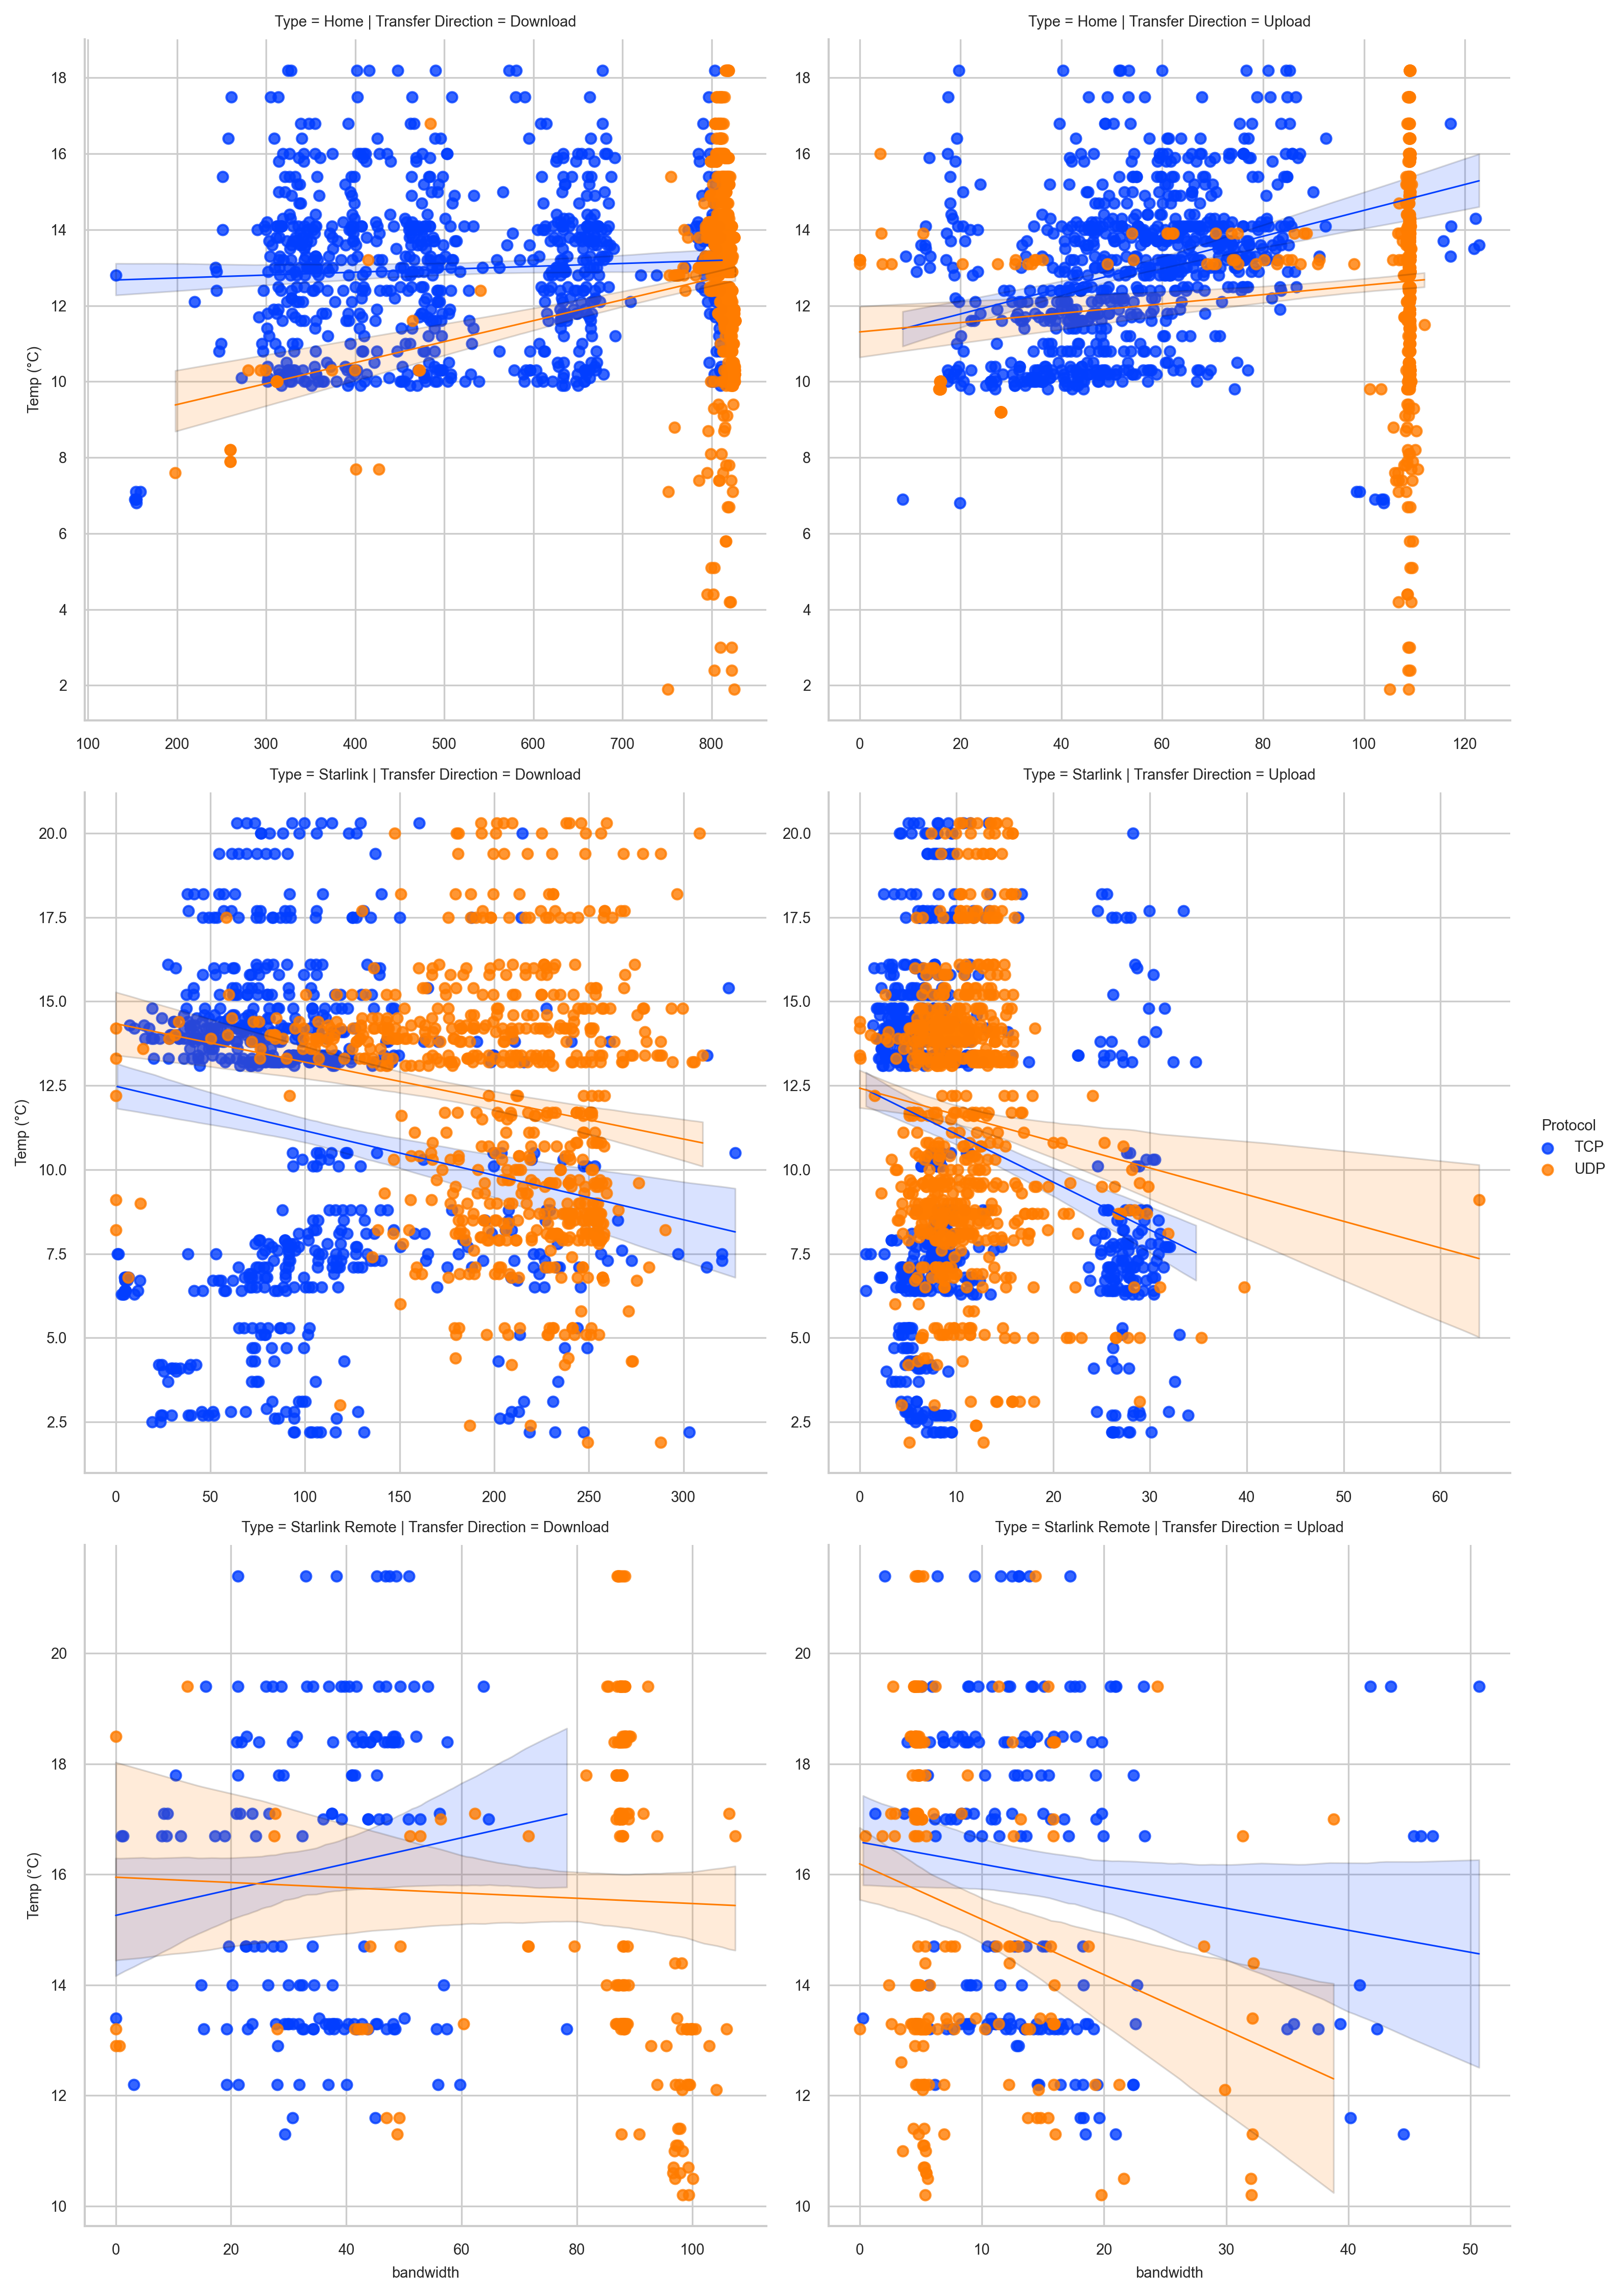

In [195]:
sns.lmplot(
    data=df_weather_iperf,
    x='bandwidth', y=TEMP,
    col=COL_TRANSF_DIR,
    row=N_TYPE,
    sharex=False,
    sharey=False,
    hue=N_PROTOCOL,
    #style=N_TYPE,
)

In [36]:
df_utc = df_regs_interp
df_utc[N_TIMESTAMP] = df_utc[N_TIMESTAMP]
print(df_utc.dtypes)
df_utc

Type                                object
Regions                             object
Protocol                            object
Protocol and Type                   object
Transfer Direction                  object
Throughput Outliers                   bool
Timestamp              datetime64[ns, UTC]
bandwidth                          float64
jitter_ms                          float64
lost_packets                       float64
packets                            float64
lost_percent                       float64
snd_cwnd                           float64
rtt                                float64
rttvar                             float64
retransmits                        float64
parallel ID                        float64
dtype: object


Type  Regions Protocol Protocol and Type Transfer Direction  \
0          Starlink  Bahrain      TCP      TCP Starlink           Download   
18         Starlink  Bahrain      TCP      TCP Starlink           Download   
39         Starlink  Bahrain      TCP      TCP Starlink           Download   
68         Starlink  Bahrain      TCP      TCP Starlink           Download   
69         Starlink  Bahrain      TCP      TCP Starlink           Download   
...             ...      ...      ...               ...                ...   
308662  Terrestrial    Tokyo      UDP   UDP Terrestrial             Upload   
308663  Terrestrial    Tokyo      UDP   UDP Terrestrial             Upload   
308826  Terrestrial    Tokyo      UDP   UDP Terrestrial             Upload   
308830  Terrestrial    Tokyo      UDP   UDP Terrestrial             Upload   
308831  Terrestrial    Tokyo      UDP   UDP Terrestrial             Upload   

        Throughput Outliers                 Timestamp  bandwidth  jitter_ms  \
0                     False 2022-01-23 08:00:00+00:00  92.946063        NaN   
18                    False 2022-01-24 02:00:00+00:00  39.449429        NaN   
39                    False 2022-01-24 23:00:00+00:00  94.192073        NaN   
68                    False 2022-01-26 04:00:00+00:00  45.862556        NaN   
69                    False 2022-01-26 05:00:00+00:00  48.957179        NaN   
...                     ...                       ...        ...        ...   
308662                 True 2022-05-28 07:00:00+00:00  15.801342   2.051565   
308663                 True 2022-05-28 08:00:00+00:00  15.991254   1.450531   
308826                 True 2022-06-04 03:00:00+00:00  26.317166   2.550009   
308830                 True 2022-06-04 07:00:00+00:00  22.371320   0.844181   
308831                 True 2022-06-04 08:00:00+00:00   0.000000   0.000000   

        lost_packets      packets  lost_percent  snd_cwnd  rtt  rttvar  \
0                NaN          NaN           NaN       NaN  NaN     NaN   
18               NaN          NaN           NaN       NaN  NaN     NaN   
39               NaN          NaN           NaN       NaN  NaN     NaN   
68               NaN          NaN           NaN       NaN  NaN     NaN   
69               NaN          NaN           NaN       NaN  NaN     NaN   
...              ...          ...           ...       ...  ...     ...   
308662      2.000000   783.000000      0.145033       NaN  NaN     NaN   
308663      0.592593  1337.222222      0.042895       NaN  NaN     NaN   
308826   1000.000000  3272.000000     30.562347       NaN  NaN     NaN   
308830   6426.038462  8285.153846     62.191128       NaN  NaN     NaN   
308831      0.000000     0.000000      0.000000       NaN  NaN     NaN   

        retransmits  parallel ID  
0               NaN          NaN  
18              NaN          NaN  
39              NaN          NaN  
68              NaN          NaN  
69              NaN          NaN  
...             ...          ...  
308662          NaN          NaN  
308663          NaN          NaN  
308826          NaN          NaN  
308830          NaN          NaN  
308831          NaN          NaN  

[11928 rows x 17 columns]

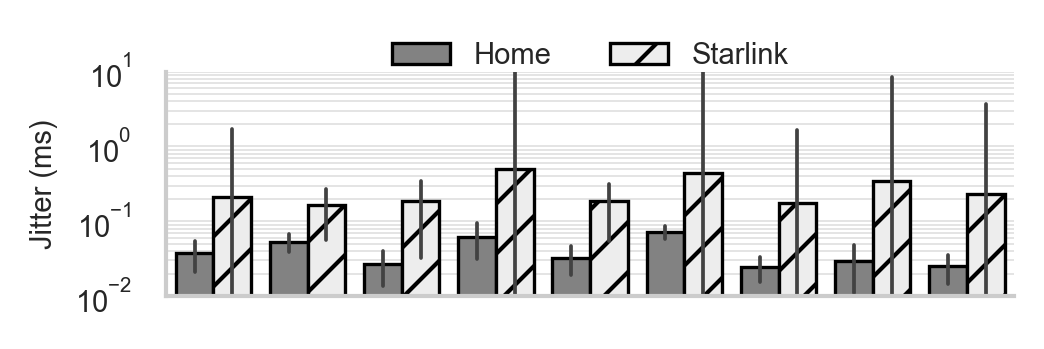

In [ ]:
#temp = df_regs.loc['2022-06-03':]
sns.set_palette('Greys')
tmp = df_outliers[(df_outliers[N_TYPE] == N_STARLINK) | (df_outliers[N_THROUGHPUT_OUTLIERS] == False)]
tmp = tmp[tmp[COL_TRANSF_DIR] == N_DOWN]
h = 1.2
aspect = 3.49 / h
g_jitter = sns.catplot(data=tmp,
                    #row=COL_TRANSF_DIR,
                    sharey=False, log=True,
                    x=N_REGIONS,
                    row_order=[N_DOWN, N_UP],
                    y='jitter_ms', 
                    hue=N_TYPE, hue_order=[N_HOME, N_STARLINK],
                    order=common.REGION_ORDER,
                    legend=False,
                    palette=['C9', 'C0'],
                    kind='bar', ci='sd',
                    height=h, aspect=aspect)

num_locs = len(tmp[N_REGIONS].unique())
hatches = itertools.cycle(['', '//'])
axes = g_jitter.axes.flatten()
for ax in axes:
    ax.grid(visible=True, which='both', axis='y', color='gray', linewidth=0.1)
    ax.set(xticks=[])
    for i, bar in enumerate(ax.patches):
        if i % num_locs == 0:
            hatch = next(hatches)
        bar.set_hatch(hatch)
        
axes[0].legend(loc='upper center', bbox_to_anchor=(0,1.05,1,0.2),
               ncol=2, 
               #mode='expand',
               fancybox=True, frameon=False)
g_jitter.set(ylim=(10**-2,10**1))
g_jitter.figure.autofmt_xdate()
g_jitter.set_titles(row_template="")
g_jitter.set(ylabel="Jitter (ms)")
g_jitter.set(xlabel="")
#g_jitter.figure.supylabel("Jitter (ms)")
g_jitter.tight_layout()

In [151]:
N_WEATHER_TIMESTAMP = 'Date/Time (LST)'
df_weather = combine_csvs(glob.glob('data/weather/*.csv'), False)
df_weather[N_WEATHER_TIMESTAMP] = pd.to_datetime(
    df_weather[N_WEATHER_TIMESTAMP]).dt.tz_localize(tz.tzlocal())
df_weather

Longitude (x)  Latitude (y)          Station Name  Climate ID  \
0          -123.12          49.3  VANCOUVER HARBOUR CS     1108446   
1          -123.12          49.3  VANCOUVER HARBOUR CS     1108446   
2          -123.12          49.3  VANCOUVER HARBOUR CS     1108446   
3          -123.12          49.3  VANCOUVER HARBOUR CS     1108446   
4          -123.12          49.3  VANCOUVER HARBOUR CS     1108446   
..             ...           ...                   ...         ...   
715        -123.12          49.3  VANCOUVER HARBOUR CS     1108446   
716        -123.12          49.3  VANCOUVER HARBOUR CS     1108446   
717        -123.12          49.3  VANCOUVER HARBOUR CS     1108446   
718        -123.12          49.3  VANCOUVER HARBOUR CS     1108446   
719        -123.12          49.3  VANCOUVER HARBOUR CS     1108446   

              Date/Time (LST)  Year  Month  Day Time (LST)  Temp (°C)  ...  \
0   2022-01-01 00:00:00-08:00  2022      1    1      00:00       -3.1  ...   
1   2022-01-01 01:00:00-08:00  2022      1    1      01:00       -3.6  ...   
2   2022-01-01 02:00:00-08:00  2022      1    1      02:00       -3.4  ...   
3   2022-01-01 03:00:00-08:00  2022      1    1      03:00       -2.8  ...   
4   2022-01-01 04:00:00-08:00  2022      1    1      04:00       -3.0  ...   
..                        ...   ...    ...  ...        ...        ...  ...   
715 2022-04-30 19:00:00-07:00  2022      4   30      19:00       11.7  ...   
716 2022-04-30 20:00:00-07:00  2022      4   30      20:00       10.4  ...   
717 2022-04-30 21:00:00-07:00  2022      4   30      21:00        9.3  ...   
718 2022-04-30 22:00:00-07:00  2022      4   30      22:00        9.6  ...   
719 2022-04-30 23:00:00-07:00  2022      4   30      23:00        9.4  ...   

     Wind Spd Flag  Visibility (km)  Visibility Flag  Stn Press (kPa)  \
0              NaN              NaN              NaN              NaN   
1              NaN              NaN              NaN              NaN   
2              NaN              NaN              NaN              NaN   
3              NaN              NaN              NaN              NaN   
4              NaN              NaN              NaN              NaN   
..             ...              ...              ...              ...   
715            NaN              NaN              NaN              NaN   
716            NaN              NaN              NaN              NaN   
717            NaN              NaN              NaN              NaN   
718            NaN              NaN              NaN              NaN   
719            NaN              NaN              NaN              NaN   

     Stn Press Flag  Hmdx  Hmdx Flag  Wind Chill  Wind Chill Flag  Weather  
0               NaN   NaN        NaN         NaN              NaN      NaN  
1               NaN   NaN        NaN         NaN              NaN      NaN  
2               NaN   NaN        NaN         NaN              NaN      NaN  
3               NaN   NaN        NaN         NaN              NaN      NaN  
4               NaN   NaN        NaN         NaN              NaN      NaN  
..              ...   ...        ...         ...              ...      ...  
715             NaN   NaN        NaN         NaN              NaN      NaN  
716             NaN   NaN        NaN         NaN              NaN      NaN  
717             NaN   NaN        NaN         NaN              NaN      NaN  
718             NaN   NaN        NaN         NaN              NaN      NaN  
719             NaN   NaN        NaN         NaN              NaN      NaN  

[5088 rows x 30 columns]

In [152]:
df_weather_power = df_watts.merge(df_weather, left_on=N_TIMESTAMP, 
                                right_on=N_WEATHER_TIMESTAMP)
df_weather_power.sort_values(N_TIMESTAMP)

Timestamp  Juuden1_1 (kWhs)  Power Consumption (Watts)  \
1094  2022-01-17 01:00:00+00:00            0.0000                        0.0   
1095  2022-01-17 02:00:00+00:00            0.0462                       46.2   
1096  2022-01-17 03:00:00+00:00            0.0456                       45.6   
1097  2022-01-17 04:00:00+00:00            0.0458                       45.8   
1098  2022-01-17 05:00:00+00:00            0.0464                       46.4   
...                         ...               ...                        ...   
4573  2022-07-26 06:00:00+00:00            0.0415                       41.5   
4574  2022-07-26 07:00:00+00:00            0.0407                       40.7   
4575  2022-07-26 08:00:00+00:00            0.0403                       40.3   
4576  2022-07-26 08:00:00+00:00            0.0178                       17.8   
4577  2022-07-26 09:00:00+00:00            0.0340                       34.0   

      Longitude (x)  Latitude (y)          Station Name  Climate ID  \
1094        -123.12          49.3  VANCOUVER HARBOUR CS     1108446   
1095        -123.12          49.3  VANCOUVER HARBOUR CS     1108446   
1096        -123.12          49.3  VANCOUVER HARBOUR CS     1108446   
1097        -123.12          49.3  VANCOUVER HARBOUR CS     1108446   
1098        -123.12          49.3  VANCOUVER HARBOUR CS     1108446   
...             ...           ...                   ...         ...   
4573        -123.12          49.3  VANCOUVER HARBOUR CS     1108446   
4574        -123.12          49.3  VANCOUVER HARBOUR CS     1108446   
4575        -123.12          49.3  VANCOUVER HARBOUR CS     1108446   
4576        -123.12          49.3  VANCOUVER HARBOUR CS     1108446   
4577        -123.12          49.3  VANCOUVER HARBOUR CS     1108446   

               Date/Time (LST)  Year  Month  ...  Wind Spd Flag  \
1094 2022-01-16 17:00:00-08:00  2022      1  ...            NaN   
1095 2022-01-16 18:00:00-08:00  2022      1  ...            NaN   
1096 2022-01-16 19:00:00-08:00  2022      1  ...            NaN   
1097 2022-01-16 20:00:00-08:00  2022      1  ...            NaN   
1098 2022-01-16 21:00:00-08:00  2022      1  ...            NaN   
...                        ...   ...    ...  ...            ...   
4573 2022-07-25 23:00:00-07:00  2022      7  ...            NaN   
4574 2022-07-26 00:00:00-07:00  2022      7  ...            NaN   
4575 2022-07-26 01:00:00-07:00  2022      7  ...            NaN   
4576 2022-07-26 01:00:00-07:00  2022      7  ...            NaN   
4577 2022-07-26 02:00:00-07:00  2022      7  ...            NaN   

     Visibility (km)  Visibility Flag  Stn Press (kPa)  Stn Press Flag  Hmdx  \
1094             NaN              NaN              NaN             NaN   NaN   
1095             NaN              NaN              NaN             NaN   NaN   
1096             NaN              NaN              NaN             NaN   NaN   
1097             NaN              NaN              NaN             NaN   NaN   
1098             NaN              NaN              NaN             NaN   NaN   
...              ...              ...              ...             ...   ...   
4573             NaN              NaN              NaN             NaN  25.0   
4574             NaN              NaN              NaN             NaN   NaN   
4575             NaN              NaN              NaN             NaN   NaN   
4576             NaN              NaN              NaN             NaN   NaN   
4577             NaN              NaN              NaN             NaN   NaN   

      Hmdx Flag  Wind Chill  Wind Chill Flag  Weather  
1094        NaN         NaN              NaN      NaN  
1095        NaN         NaN              NaN      NaN  
1096        NaN         NaN              NaN      NaN  
1097        NaN         NaN              NaN      NaN  
1098        NaN         NaN              NaN      NaN  
...         ...         ...              ...      ...  
4573        NaN         NaN              NaN      

In [ ]:
sns.relplot(

[Text(654.2319374801019, 0.5, '')]

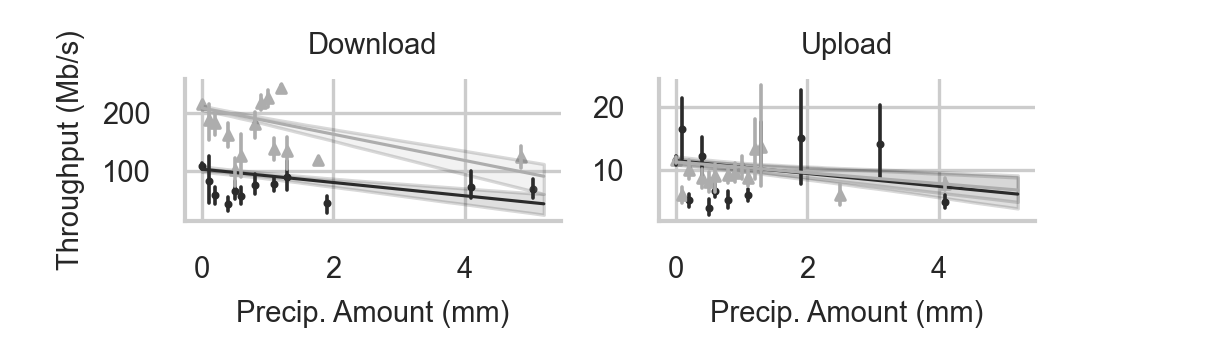

In [144]:
df_temp = df_weather_iperf[
    (df_weather_iperf[N_TYPE] == N_STARLINK)
]

h = 1.2
aspect = common.WIDTH_HALF / 2 / h
    
sns.set_palette('Greys')
g_weather_regress = sns.lmplot(
    data=df_temp,
    x='Precip. Amount (mm)', y='bandwidth',
    x_bins=80,
    #x_ci=95,
    col=COL_TRANSF_DIR, 
    #row=N_PROTOCOL, hue=N_REGIONS, hue_order=common.REGION_ORDER,
    hue=N_PROTOCOL, hue_order=[N_TCP, N_UDP],
    height=h, aspect=aspect,
    #x_estimator=np.mean,
    palette=['C11', 'C2'],
    facet_kws=dict(legend_out=True, sharey=False),
    scatter_kws=dict(s=5),
    markers=['.','^'],
    #line_kws=dict(color='r'),
)

g_weather_regress.set(ylabel="Throughput (Mb/s)")
g_weather_regress.set_titles(col_template="{col_name}", row_template='{row_name}')
sns.move_legend(g_weather_regress, loc='lower center',
               bbox_to_anchor=(.5, 0.93), ncol=2, title=None, frameon=False)
axes = g_weather_regress.axes.flatten()
axes[1].set(ylabel='')

#for label in ax.get_xticklabels():
#    label.set_rotation(45)
#    label.set_ha('right')

#ax.set_xlabel("Day of Month (2022)")
#ax.set_ylabel("Jitter (m)")

#plt.savefig(f'{args.filename}.eps', format='eps', bbox_inches='tight')

In [141]:
plt.close("all")

In [145]:
g_weather_regress.savefig(os.path.join(
    OUTPUT_FOLDER, 'iperf3_weather_corr_2022-06-05_end.pdf'), bbox_inches='tight')

In [35]:
df_temp = df_weather_iperf[
    (df_weather_iperf[N_TYPE] == N_STARLINK)
]
df_temp = df_temp.pivot_table(
    index='Precip. Amount (mm)', 
    columns=[COL_TRANSF_DIR,N_PROTOCOL], values='bandwidth').sort_index()
#df_temp[(df_temp[N_PROTOCOL] == N_UDP) & (df_temp['Precip. Amount (mm)'] == 0)]
print(df_temp)
print(df_temp[df_temp.index > 0].mean())
(df_temp[df_temp.index > 0].mean() / df_temp[df_temp.index == 0])

NameError: name 'df_weather_iperf' is not defined

In [132]:
df_weather_iperf.to_csv(f'{OUTPUT_FOLDER}/weather_iperf.csv')

In [269]:
df_weather_iperf[(df_weather_iperf[N_PROTOCOL] == N_TCP) & (df_weather_iperf[COL_TRANSF_DIR] == N_DOWN) & (df_weather_iperf['jitter_ms'] > 0)]

Type        Regions Protocol Protocol and Type Transfer Direction  \
6430  Starlink  N. California      TCP      TCP Starlink           Download   
6473  Starlink  N. California      TCP      TCP Starlink           Download   

      Throughput Outliers                  timestamp   bandwidth  jitter_ms  \
6430                False  2022-06-27 18:00:00+00:00   56.911700   0.121614   
6473                 True  2022-06-27 18:00:00+00:00  281.575814   0.134150   

      lost_packets  ...  Wind Spd Flag  Visibility (km)  Visibility Flag  \
6430   8306.583333  ...            NaN              NaN              NaN   
6473   5056.785714  ...            NaN              NaN              NaN   

      Stn Press (kPa)  Stn Press Flag  Hmdx  Hmdx Flag  Wind Chill  \
6430              NaN             NaN  26.0        NaN         NaN   
6473              NaN             NaN  26.0        NaN         NaN   

      Wind Chill Flag Weather  
6430              NaN     NaN  
6473              NaN     NaN  

[2 rows x 47 columns]

In [338]:
#df_regs_old[N_TIMESTAMP] = df_regs_old['timestamp'].values.astype('datetime64[s]')
#df_regs_old

timestamp  ...           Timestamp
0      2022-02-05 22:49:05.001078016  ... 2022-02-05 22:49:05
1      2022-02-09 23:23:34.000613888  ... 2022-02-09 23:23:34
2      2022-02-06 22:20:13.000148992  ... 2022-02-06 22:20:13
3      2022-02-09 23:23:30.000144896  ... 2022-02-09 23:23:30
4      2022-01-31 22:04:48.000264960  ... 2022-01-31 22:04:48
...                              ...  ...                 ...
361845 2022-05-28 22:09:51.000088832  ... 2022-05-28 22:09:51
361846 2022-05-29 14:10:28.000004096  ... 2022-05-29 14:10:28
361847 2022-05-28 10:01:02.000055040  ... 2022-05-28 10:01:02
361848 2022-05-30 17:09:39.000015104  ... 2022-05-30 17:09:39
361849 2022-05-28 23:09:43.000055040  ... 2022-05-28 23:09:43

[361850 rows x 12 columns]

In [149]:
#col_kwatt = 'Juuden1_1 (kWatts)'
col_kwatt = 'Juuden1_1 (kWhs)'

df_watts = df_power
df_watts[N_TIMESTAMP] = pd.to_datetime(df_watts[N_TIMESTAMP]).dt.tz_localize('UTC')
df_watts[N_POWER_WATTS] = df_watts[col_kwatt] * 1000
df_watts

Timestamp  Juuden1_1 (kWhs)  Power Consumption (Watts)
0    2022-05-01 00:00:00+00:00            0.0496                       49.6
1    2022-05-01 01:00:00+00:00            0.0496                       49.6
2    2022-05-01 02:00:00+00:00            0.0502                       50.2
3    2022-05-01 03:00:00+00:00            0.0498                       49.8
4    2022-05-01 04:00:00+00:00            0.0492                       49.2
...                        ...               ...                        ...
4572 2022-06-13 17:00:00+00:00            0.0091                        9.1
4573 2022-07-05 09:00:00+00:00            0.0200                       20.0
4574 2022-07-26 08:00:00+00:00            0.0178                       17.8
4575 2022-07-08 23:00:00+00:00            0.0056                        5.6
4576 2022-06-13 11:00:00+00:00            0.0316                       31.6

[4577 rows x 3 columns]

In [473]:
df_watts.dtypes
df_watts.max()

Timestamp                    2022-07-26 09:00:00+00:00
Juuden1_1 (kWhs)                                0.1445
Power Consumption (Watts)                        144.5
dtype: object

In [150]:
df_weather_power = df_watts.merge(df_weather, left_on=N_TIMESTAMP, 
                                right_on=N_WEATHER_TIMESTAMP)
df_weather_power.sort_values(N_TIMESTAMP)

NameError: name 'df_weather' is not defined

In [478]:
#df_weather_power.corr()
df_weather_power[df_weather_power['Precip. Amount (mm)'] > 5]

Timestamp  Juuden1_1 (kWhs)  ...  Wind Chill Flag  Weather
361   2022-05-16 01:00:00+00:00            0.0783  ...              NaN      NaN
632   2022-05-27 08:00:00+00:00            0.0783  ...              NaN      NaN
809   2022-06-03 17:00:00+00:00            0.0731  ...              NaN      NaN
4123  2022-07-07 13:00:00+00:00            0.0743  ...              NaN      NaN

[4 rows x 33 columns]

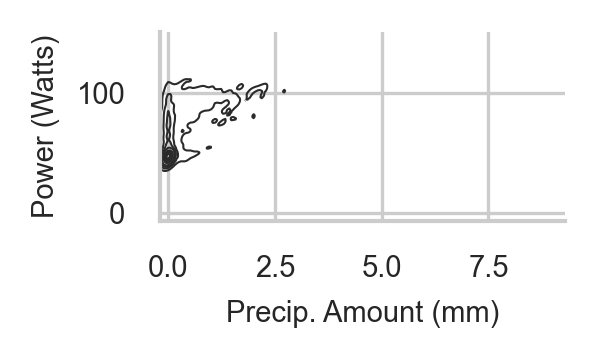

In [159]:
sns.set_palette('Greys_r')

h = 1.2
aspect = (common.WIDTH_HALF - 1.5) / h
g_watts = sns.displot(
    data=df_weather_power,
    #col=COL_TRANSF_DIR, col_order=[N_DOWN, N_UP],
    #x_bins=100,
    #x_ci='sd',
    #ci=95,
    x='Precip. Amount (mm)', y=N_POWER_WATTS,
    #hue=N_PROTOCOL, hue_order=[N_TCP, N_UDP],
    facet_kws={'sharex': False, 'sharey': True},
    #scatter_kws={'s': 5, 'linewidth': 0},
    palette=['C11', 'C2'],
    #markers='x',
    #scatter=False,
    kind='kde',
    height=h,
    aspect=aspect,
    bw_method='silverman',
    bw_adjust=.5,
)

axes = g_watts.axes.flatten()
#for ax in axes:
#    x0, x1 = ax.get_xlim()
#    y0, y1 = ax.get_ylim()
#    lims = [max(x0, y0), min(x1, y1)]
#    ax.plot(lims, lims, '-r')
#axes[1].set(yscale='log', xscale='log')
#g_scatter.set_titles(col_template="{col_name}")
g_watts.set(ylabel='Power (Watts)')
g_watts.set_titles(col_template="{col_name}", row_template="{row_name}")
g_watts.tight_layout(pad=1.1)

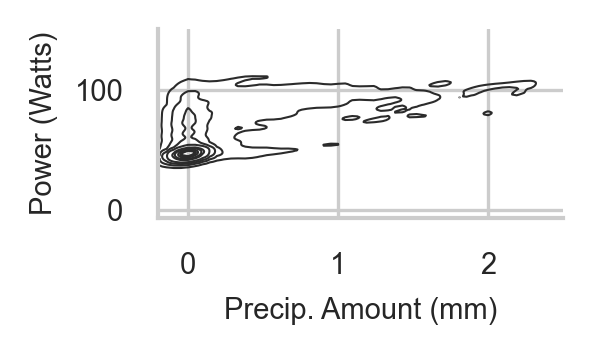

In [160]:
g_watts.set(xlim=(-0.2,2.5),)
g_watts.figure

In [161]:
g_watts.savefig(os.path.join(
    OUTPUT_FOLDER, 'precip_watts_corr_2022-06-05_end.pdf'), bbox_inches='tight')

In [432]:
#df_watts.dtypes
#df_watts[N_TIMESTAMP].astype('datetime64[s]')
df_iperf_watts = pd.merge(df_regs_interp[(df_regs_interp[N_TYPE] == N_STARLINK) & (df_regs_interp[N_THROUGHPUT_OUTLIERS] == False)], df_watts, on=N_TIMESTAMP, how='outer')
df_iperf_watts.sort_values(N_TIMESTAMP)

Type Regions  ... Juuden1_1 (kWhs) Power Consumption (Watts)
3619  NaN     NaN  ...           0.0000                       0.0
3620  NaN     NaN  ...           0.0462                      46.2
3621  NaN     NaN  ...           0.0456                      45.6
3622  NaN     NaN  ...           0.0458                      45.8
3623  NaN     NaN  ...           0.0464                      46.4
...   ...     ...  ...              ...                       ...
6978  NaN     NaN  ...           0.0415                      41.5
6979  NaN     NaN  ...           0.0407                      40.7
6980  NaN     NaN  ...           0.0403                      40.3
6981  NaN     NaN  ...           0.0178                      17.8
6982  NaN     NaN  ...           0.0340                      34.0

[6983 rows x 14 columns]

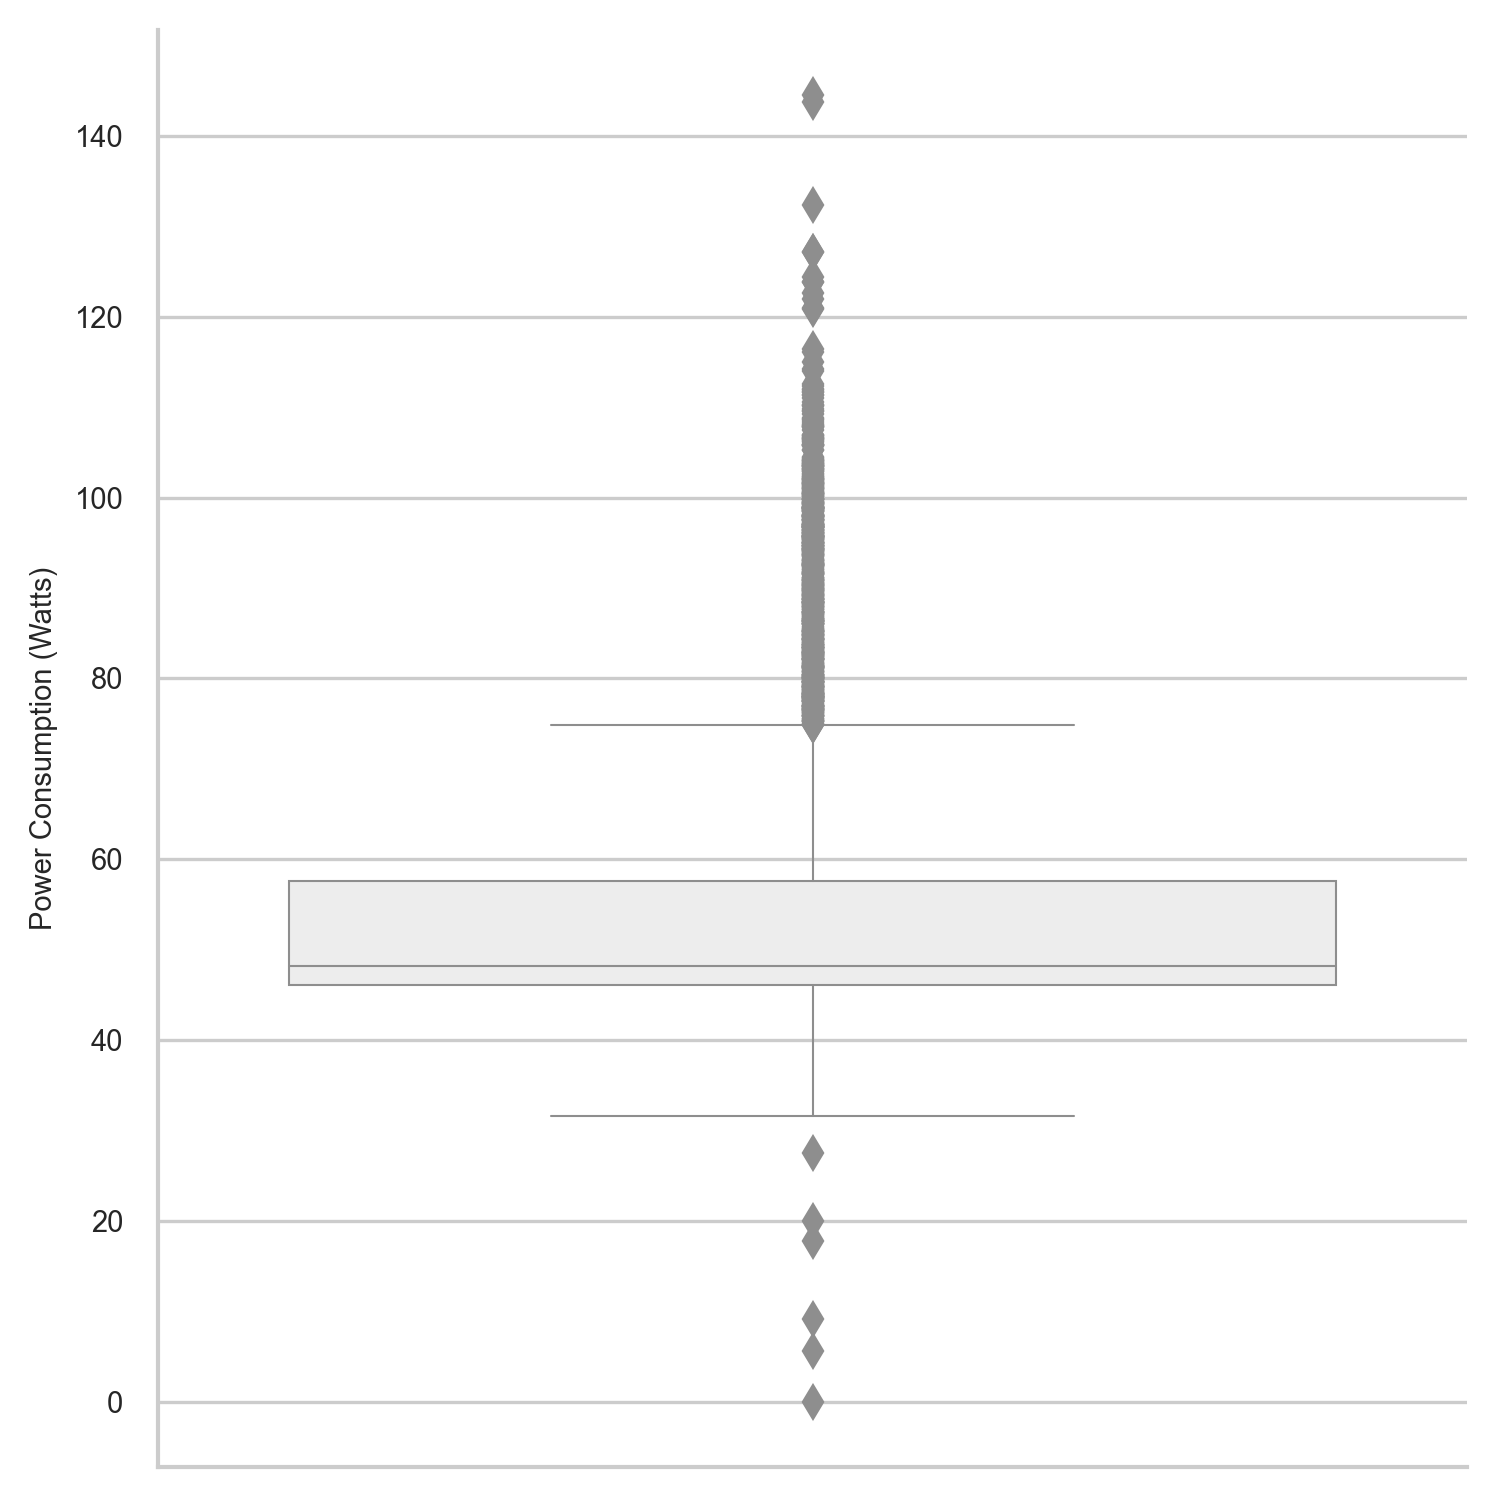

In [436]:
tmp = df_iperf_watts[df_iperf_watts['bandwidth'].isnull()]
sns.catplot(data=tmp, y=N_POWER_WATTS, kind='box')

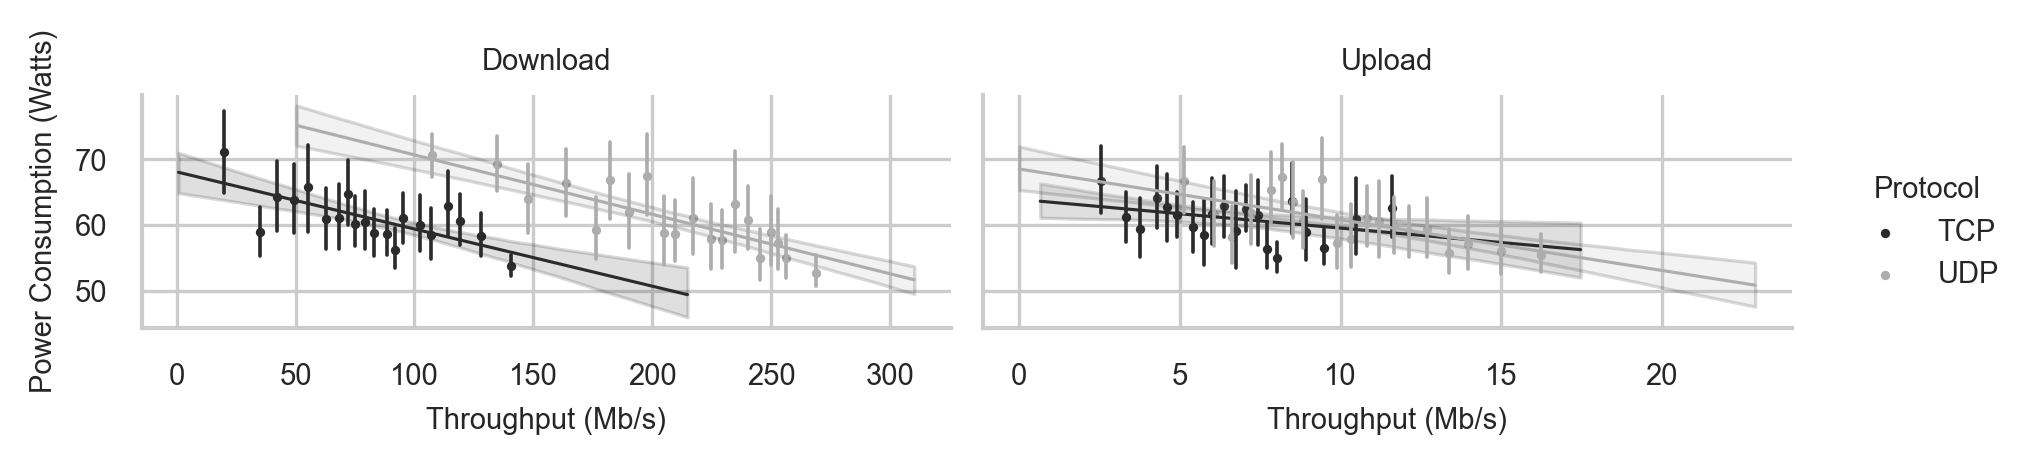

In [445]:
sns.set_palette('Greys')

h = 1.5
aspect = (common.WIDTH_FULL - 1) / 2 / h
g_watts = sns.lmplot(
    data=df_iperf_watts,
    col=COL_TRANSF_DIR, col_order=[N_DOWN, N_UP],
    x_bins=20,
    #x_ci='sd',
    #ci=95,
    x='bandwidth', y=N_POWER_WATTS,
    hue=N_PROTOCOL, hue_order=[N_TCP, N_UDP],
    facet_kws={'sharex': False, 'sharey': True},
    scatter_kws={'s': 5, 'linewidth': 0},
    palette=['C11', 'C2'],
    #markers='x',
    #scatter=False,
    height=h,
    aspect=aspect,
)

axes = g_watts.axes.flatten()
#for ax in axes:
#    x0, x1 = ax.get_xlim()
#    y0, y1 = ax.get_ylim()
#    lims = [max(x0, y0), min(x1, y1)]
#    ax.plot(lims, lims, '-r')
#axes[1].set(yscale='log', xscale='log')
#g_scatter.set_titles(col_template="{col_name}")
g_watts.set_titles(col_template="{col_name}", row_template="{row_name}")
g_watts.set(xlabel="Throughput (Mb/s)",)
g_watts.tight_layout()

In [446]:
g_watts.savefig(os.path.join(
    OUTPUT_FOLDER, 'iperf3_watts_corr_2022-06-05_end.pdf'), bbox_inches='tight')

/home/sami/.local/share/virtualenvs/starlink-plot-RhHgxjja/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


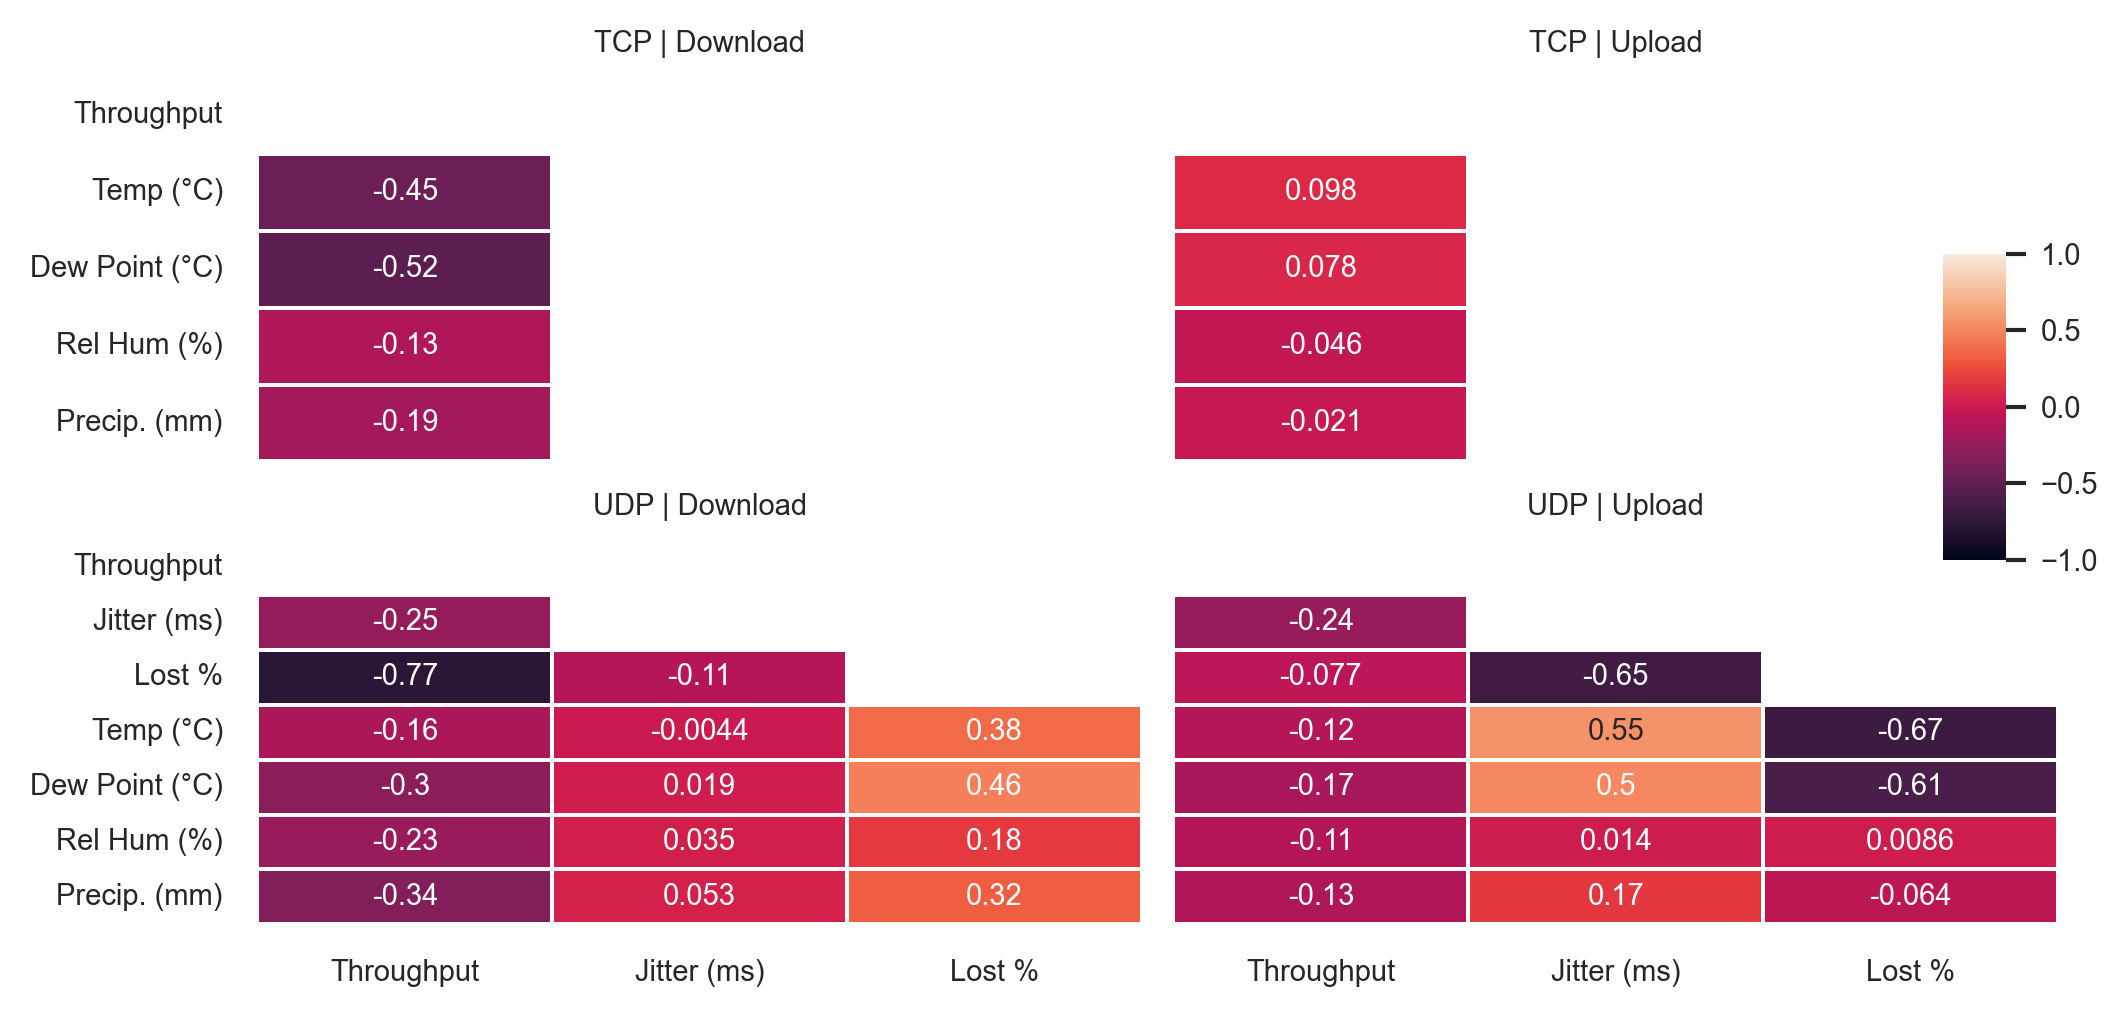

In [272]:
df_clean = df_weather_iperf.drop(df_weather_iperf[(df_weather_iperf[N_PROTOCOL] == N_TCP) & (df_weather_iperf[COL_TRANSF_DIR] == N_DOWN) & (df_weather_iperf['jitter_ms'] > 0)].index)

df_temp1 = df_clean.iloc[:,0:12]
df_temp2 = df_clean.iloc[:,21:]
df_temp = pd.concat([df_temp1, df_temp2], axis=1)
df_temp = df_temp[
    (df_clean[N_TYPE] == N_STARLINK)
].drop(['lost_packets', 'packets'], axis=1)

name_map = {
    'bandwidth': 'Throughput',
    'jitter_ms': 'Jitter (ms)',
    'lost_percent': 'Lost %',
    'Dew Point Temp (°C)': 'Dew Point (°C)',
    'Precip. Amount (mm)': 'Precip. (mm)'
}

df_temp = df_temp.rename(columns=name_map).drop(N_THROUGHPUT_OUTLIERS, axis=1)
            

keep_cols = ['Throughput', 'Jitter (ms)', 'Lost %', 'Temp (°C)',
             'Dew Point (°C)', 'Rel Hum (%)', 'Precip. (mm)']
def draw_corr(*args, **kwargs):
    df = kwargs.pop('data')
    corr = df[keep_cols].corr()
    corr = corr.drop(keep_cols[3:], axis=1)
    corr = corr.dropna(how='all')
    #corr = corr.drop(keep_cols[0], axis=0)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, **kwargs)

g_corr_map = sns.FacetGrid(
    data=df_temp,
    col=COL_TRANSF_DIR,
    row=N_PROTOCOL,
    aspect=2.05,
    height=1.7,
    sharey='row',
)
cbar_ax = g_corr_map.figure.add_axes([.93, .45, .03, .3])
g_corr_map.map_dataframe(
    draw_corr, 
    linewidths=.5,
    vmin=-1, vmax=1,
    cbar_ax=cbar_ax,
    #cbar_kws={"shrink": .5},
    annot=True,
)
axes = g_corr_map.axes.flatten()
#axes[0].set_yticklabels(keep_cols[3:])
#axes[1].set_yticklabels(keep_cols[3:])

g_corr_map.set_titles(col_template="{col_name}", row_template="{row_name}")
g_corr_map.set(ylabel='')

g_corr_map.tight_layout()

In [361]:
df_temp = df_regs.copy()
df_temp = df_temp[
    (df_temp[N_TYPE] == N_STARLINK)
].drop(['lost_packets', 'packets'], axis=1)
df_temp1 = df_temp[df_temp[COL_PARAID].isna()]
df_temp2 = df_temp[df_temp[COL_PARAID].notna()]
df_temp2 = df_temp2.groupby(['timestamp', N_PROTOCOL, COL_TRANSF_DIR]).agg(
    {
        'snd_cwnd': 'sum',
        'retransmits': 'sum',
        'bandwidth': 'mean',
        'jitter_ms': 'mean',
        'lost_percent': 'mean',
        'rtt': 'mean',
        'rttvar': 'mean',
    }
).reset_index()

df_tcp_agg = pd.concat([df_temp1, df_temp2])
df_tcp_agg.groupby(['timestamp', N_PROTOCOL, COL_TRANSF_DIR]).mean().reset_index()

timestamp Protocol Transfer Direction   bandwidth  \
0      2022-01-23 04:35:13.000114944      TCP             Upload    1.836197   
1      2022-01-23 04:35:14.000139008      TCP             Upload    2.444667   
2      2022-01-23 04:35:15.000401920      TCP             Upload    2.769705   
3      2022-01-23 04:35:16.000116224      TCP             Upload    2.229662   
4      2022-01-23 04:35:16.000148992      TCP           Download   15.578690   
...                              ...      ...                ...         ...   
319309 2022-07-08 03:18:03.000161792      UDP           Download  213.182237   
319310 2022-07-08 03:18:04.000071168      UDP             Upload    7.101021   
319311 2022-07-08 03:18:04.000098816      UDP           Download  229.594838   
319312 2022-07-08 03:18:05.000067072      UDP             Upload    8.942731   
319313 2022-07-08 03:18:06.000080128      UDP             Upload    7.112618   

        jitter_ms  lost_percent  snd_cwnd        rtt   rttvar  retransmits  \
0             NaN           NaN  237472.0  233300.75  4321.25          0.0   
1             NaN           NaN  288152.0  242250.25  4804.00          0.0   
2             NaN           NaN  296840.0  241020.25  7081.75          4.0   
3             NaN           NaN  353312.0  276806.25  7696.00          1.0   
4             NaN           NaN       NaN        NaN      NaN          NaN   
...           ...           ...       ...        ...      ...          ...   
319309   0.110901     39.417284       NaN        NaN      NaN          NaN   
319310   0.943322     89.028101       NaN        NaN      NaN          NaN   
319311   0.161055     34.412018       NaN        NaN      NaN          NaN   
319312   0.902654     83.872989       NaN        NaN      NaN          NaN   
319313   5.722875     75.400641       NaN        NaN      NaN          NaN   

        parallel ID  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4               NaN  
...             ...  
319309          NaN  
319310          NaN  
319311          NaN  
319312          NaN  
319313          NaN  

[319314 rows x 11 columns]

/home/sami/.local/share/virtualenvs/starlink-plot-RhHgxjja/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


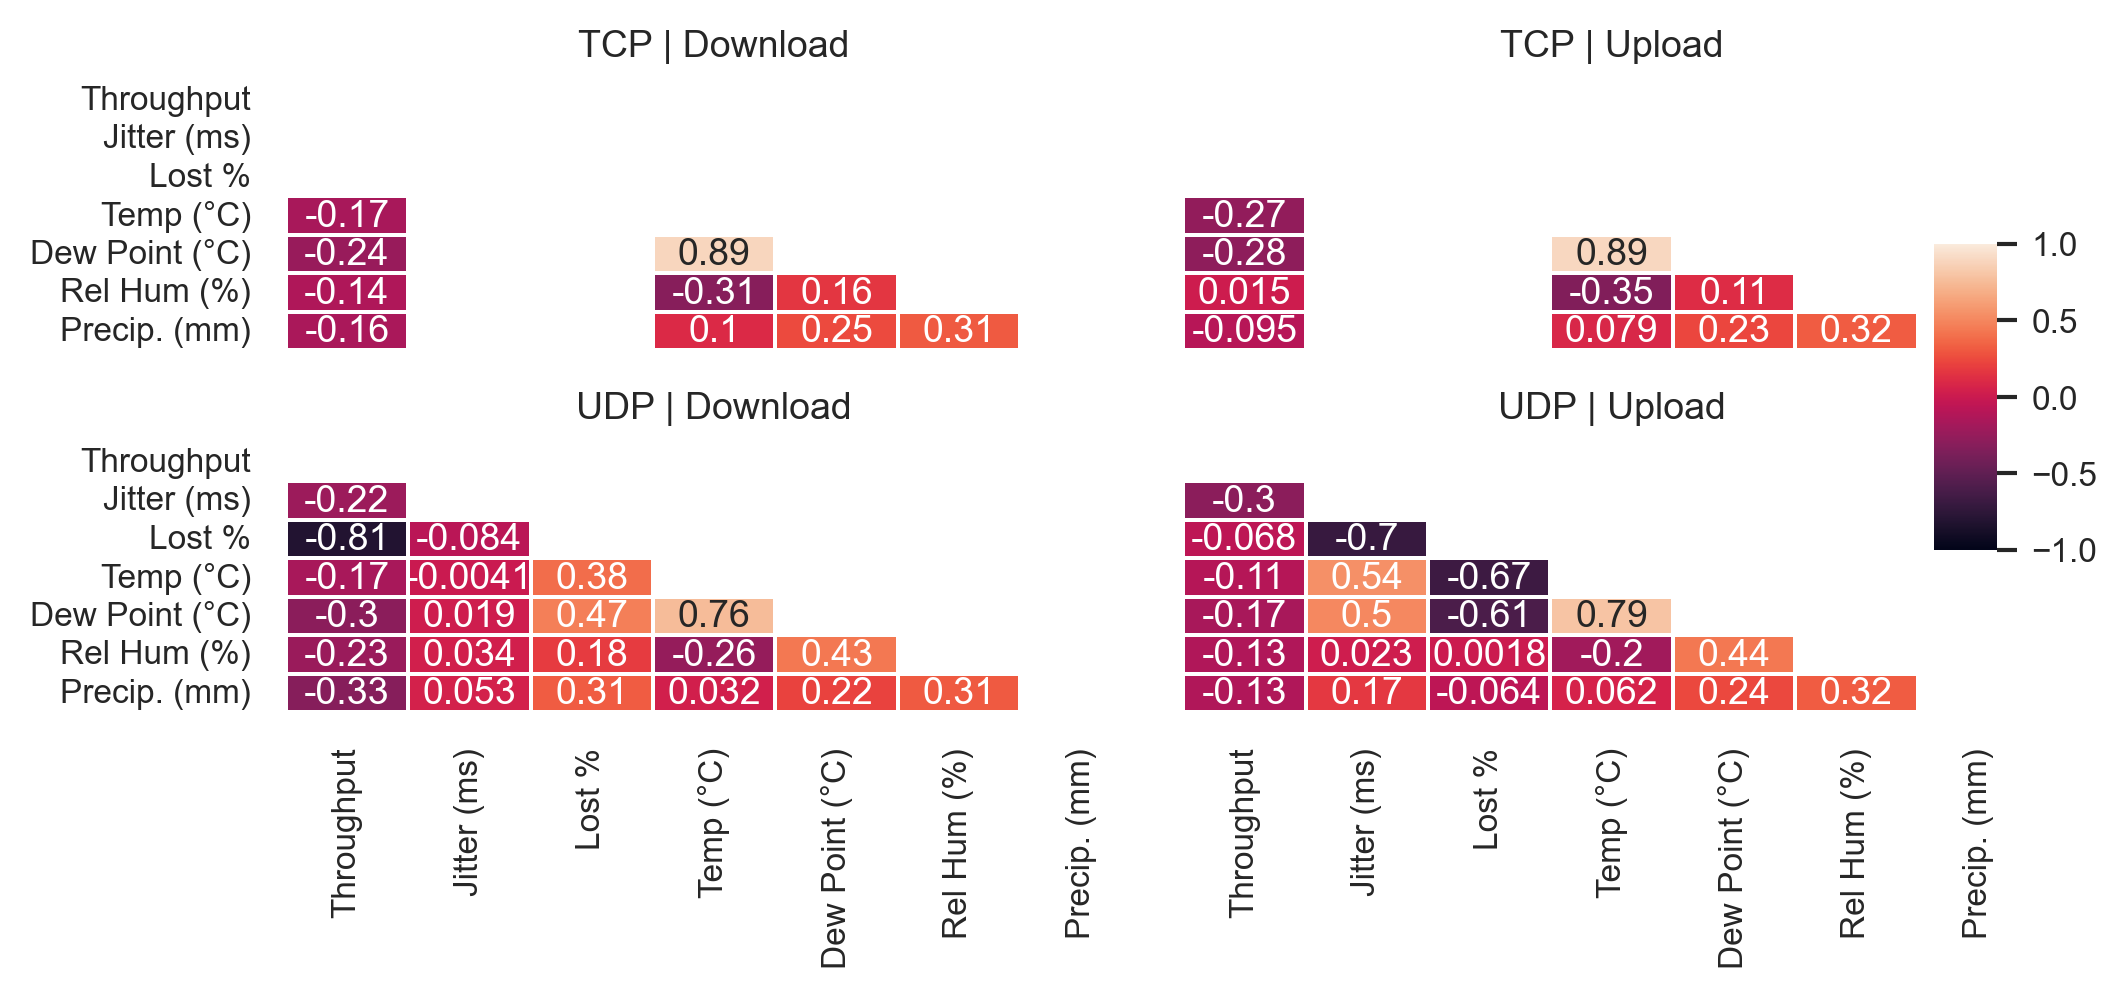

In [253]:
df_temp = df_regs.copy()
df_temp = df_temp[
    (df_temp[N_TYPE] == N_STARLINK)
].drop(['lost_packets', 'packets'], axis=1)

name_map = {
    'bandwidth': 'Throughput',
    'jitter_ms': 'Jitter (ms)',
    'lost_percent': 'Lost %',
    'Dew Point Temp (°C)': 'Dew Point (°C)',
    'Precip. Amount (mm)': 'Precip. (mm)'
}

df_temp = df_temp.rename(columns=name_map).drop(N_THROUGHPUT_OUTLIERS, axis=1)
            

keep_cols = ['Throughput', 'Jitter (ms)', 'Lost %', 'Temp (°C)',
             'Dew Point (°C)', 'Rel Hum (%)', 'Precip. (mm)']
def draw_corr(*args, **kwargs):
    df = kwargs.pop('data')
    corr = df[keep_cols].corr()
    #corr = corr.drop(keep_cols[3:], axis=1)
    #corr = corr.dropna(how='all')
    #corr = corr.drop(keep_cols[0], axis=0)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, **kwargs)

g_corr_map = sns.FacetGrid(
    data=df_temp,
    col=COL_TRANSF_DIR,
    row=N_PROTOCOL,
    aspect=2.05,
    height=1.7,
    sharey='row',
)
cbar_ax = g_corr_map.figure.add_axes([.93, .45, .03, .3])
g_corr_map.map_dataframe(
    draw_corr, 
    linewidths=.5,
    vmin=-1, vmax=1,
    cbar_ax=cbar_ax,
    #cbar_kws={"shrink": .5},
    annot=True,
)
axes = g_corr_map.axes.flatten()
#axes[0].set_yticklabels(keep_cols[3:])
#axes[1].set_yticklabels(keep_cols[3:])

g_corr_map.set_titles(col_template="{col_name}", row_template="{row_name}")
g_corr_map.set(ylabel='')

g_corr_map.tight_layout()

In [273]:
g_corr_map.savefig(f'{OUTPUT_FOLDER}/iperf3_weather_corr_heatmap_2022-06-05_end.pdf', bbox_inches='tight')

In [197]:
#df_temp[(df_temp[N_PROTOCOL] == N_TCP) & (df_temp['Jitter (ms)'] > 0)]
df_temp.columns

Index(['Type', 'Regions', 'Protocol', 'Protocol and Type',
       'Transfer Direction', 'timestamp', 'Throughput', 'Jitter (ms)',
       'Lost %', 'Temp (°C)', 'Temp Flag', 'Dew Point (°C)',
       'Dew Point Temp Flag', 'Rel Hum (%)', 'Rel Hum Flag', 'Precip. (mm)',
       'Precip. Amount Flag', 'Wind Dir (10s deg)', 'Wind Dir Flag',
       'Wind Spd (km/h)', 'Wind Spd Flag', 'Visibility (km)',
       'Visibility Flag', 'Stn Press (kPa)', 'Stn Press Flag', 'Hmdx',
       'Hmdx Flag', 'Wind Chill', 'Wind Chill Flag', 'Weather'],
      dtype='object')

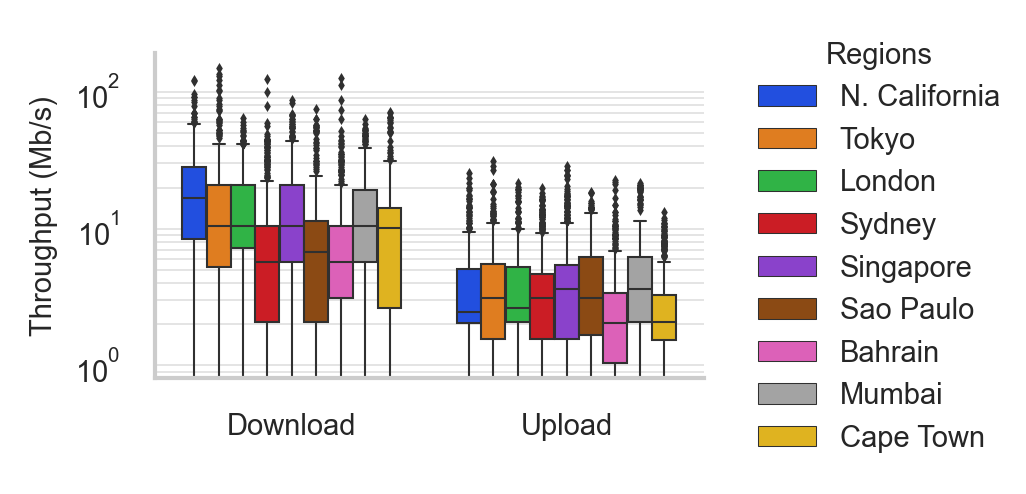

In [197]:
#fig, ax = plt.subplots(figsize=(3.5,3))
#fig, ax = plt.subplots(figsize=(20,10))

#ax.xaxis.update_units(df.index)
#y_val = df_unstacked.bandwidth
#sns.scatterplot(x=ax.xaxis.convert_units(df.timestamp), y=y_val, ax=ax)
#sns.jointplot(x=ax.xaxis.convert_units(df.timestamp), y=y_val, ax=ax)

#sns.lineplot(x=ax.xaxis.convert_units(df.index), y=y_val, ax=ax, hue=y_val.isna().cumsum(),
#        palette=["black"]*sum(y_val.isna()), markers=True, legend=False)
#sns.lineplot(data=df_regs)

temp = df_regs[df_regs[N_PROTOCOL] == 'TCP']
#temp = temp.fillna(np.inf)
#temp = temp[temp['timestamp'] > '2022-06-02']
#temp = temp[temp[N_REGIONS] == 'N. California']
#g = sns.relplot(data=temp, row=COL_TRANSF_DIR, hue=N_REGIONS,
#                style=COL_PROT_TYPE, style_order=PROT_TYPE_ORDER,
#                height=2, aspect=2.98,
#                kind='line',
#                x = 'timestamp', y='bandwidth',
#                facet_kws={'sharey': False})

#temp['Minutes'] = [(dt - pd.Timedelta(minutes=int(dt.minute % 30))).strftime('%H:%M') for dt in temp['timestamp']]

h = 1.5
aspect = (common.WIDTH_HALF - 1) / h

g = sns.catplot(data=temp, 
                #col=N_PROTOCOL,
                #row=COL_TRANSF_DIR, row_order=[N_DOWN, N_UP],
                hue=N_REGIONS, hue_order=common.REGION_ORDER,
                #style=N_PROTOCOL,
                height=h, aspect=aspect,
                kind='box',
                x=COL_TRANSF_DIR, y='bandwidth',
                order=[N_DOWN, N_UP],
                palette='bright',
                #sharey=False,
                fliersize=0.5,
                #dodge=False,
                #alpha=0.3,
               )

#g_ax = g.fig.axes
#sns.scatterplot(data=df_outage, ax=g_ax)


#g = sns.lineplot(data=df_unstacked, x='timestamp', y='bandwidth', hue=N_REGIONS, style=N_TYPE)
#g = sns.lineplot(data=df_unstacked, x=df_unstacked.index, y='bandwidth')
#ax.set(yscale='log')

#g.figure.autofmt_xdate()

axes = g.axes.flatten()
for ax in axes:
    ax.grid(visible=True, which='both', axis='y', color='gray', linewidth=0.1)

#ax.set_ylabel("Jitter (ms)")
g.set_titles(row_template="{row_name}")
g.set(
    ylabel="Throughput (Mb/s)",
     xlabel='',
     yscale='log',
     #ylim=[10**0,10**2],
     )
#g.figure.supylabel('Throughput (Mb/s)')
#g.set(yscale="log")
g.tight_layout()
#fig.tight_layout()

In [117]:
g.savefig(f'{OUTPUT_FOLDER}/2022-02-02_starlink_iperf3_mann.pdf', bbox_inches='tight')

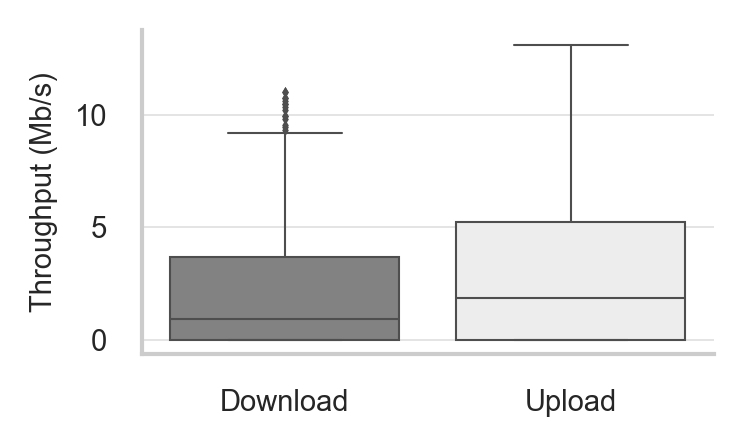

In [307]:
temp = df_regs[df_regs['parallel ID'].isnull()]

h = 1.5
aspect = (common.WIDTH_HALF - 1) / h

sns.set_palette('Greys')
g_peer = sns.catplot(data=temp, 
                #col=N_PROTOCOL,
                #row=COL_TRANSF_DIR, row_order=[N_DOWN, N_UP],
                hue=COL_TRANSF_DIR, hue_order=[N_DOWN, N_UP],
                #style=N_PROTOCOL,
                height=h, aspect=aspect,
                kind='box',
                x=COL_TRANSF_DIR, y='bandwidth',
                order=[N_DOWN, N_UP],
                palette=['C9', 'C0'],
                #sharey=False,
                fliersize=0.5,
                dodge=False,
                #alpha=0.3,
               )

#g_ax = g_peer.fig.axes
#sns.scatterplot(data=df_outage, ax=g_ax)


#g_peer = sns.lineplot(data=df_unstacked, x='timestamp', y='bandwidth', hue=N_REGIONS, style=N_TYPE)
#g_peer = sns.lineplot(data=df_unstacked, x=df_unstacked.index, y='bandwidth')
#ax.set(yscale='log')

#g_peer.figure.autofmt_xdate()

axes = g_peer.axes.flatten()
for ax in axes:
    ax.grid(visible=True, which='both', axis='y', color='gray', linewidth=0.1)

#ax.set_ylabel("Jitter (ms)")
g_peer.set_titles(row_template="{row_name}")
g_peer.set(
    ylabel="Throughput (Mb/s)",
     xlabel='',
     #yscale='log',
     #ylim=[10**0,10**2],
     )
#g_peer.figure.supylabel('Throughput (Mb/s)')
#g_peer.set(yscale="log")
g_peer.tight_layout()
#fig.tight_layout()

In [308]:
g_peer.savefig(f'{OUTPUT_FOLDER}/peer-to-peer_starlink_iperf3_2022-07-24.pdf', bbox_inches='tight')

/tmp/ipykernel_3733921/529820566.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['datenum'] = dates.date2num(temp[N_TIMESTAMP])


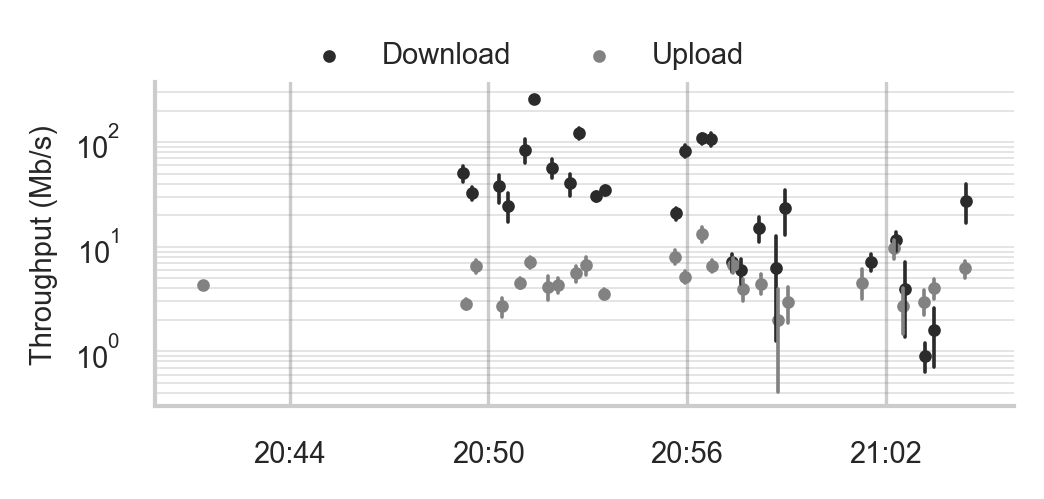

In [217]:
temp = df_regs[(df_regs[N_PROTOCOL] == 'TCP')
               & (df_regs[N_TIMESTAMP] < '2022-07-21 21:10')
              & (df_regs['parallel ID'].isnull())]

temp['datenum'] = dates.date2num(temp[N_TIMESTAMP])


@pyplot.FuncFormatter
def fake_dates(x, pos):
    """ Custom formater to turn floats into datetime"""
    return dates.num2date(x, tz=pytz.timezone('US/Pacific')).strftime('%H:%M')

h = 1.5
aspect = (common.WIDTH_HALF) / h

sns.set_palette('Greys')
g = sns.lmplot(data=temp, 
                #col=N_PROTOCOL,
                #row=COL_TRANSF_DIR, row_order=[N_DOWN, N_UP],
                hue=COL_TRANSF_DIR, hue_order=[N_DOWN, N_UP],
                #style=N_PROTOCOL,
                height=h, aspect=aspect,
                #kind='box',
                x='datenum', y='bandwidth',
                palette=['C5', 'C3'],
                #sharey=False,
                fit_reg=False,
                 scatter_kws=dict(s=5),
                x_bins=26,
               facet_kws=dict(legend_out=False),
               )

#g.figure.autofmt_xdate()

axes = g.axes.flatten()
for ax in axes:
    ax.grid(visible=True, which='both', axis='y', color='gray', linewidth=0.1)
    ax.xaxis.set_major_locator(dates.MinuteLocator(range(2,60,6)))
    ax.xaxis.set_major_formatter(fake_dates)

#ax.set_ylabel("Jitter (ms)")
g._legend.set_title('')
sns.move_legend(g, loc='lower center', bbox_to_anchor=(0,0.9,1,0), ncol=2, frameon=False)
g.set_titles(row_template="{row_name}")
g.set(
    ylabel="Throughput (Mb/s)",
     xlabel='',
     yscale='log',
     #ylim=[10**0,10**2],
     )
#g.figure.supylabel('Throughput (Mb/s)')
g.tight_layout()

In [218]:
g.savefig(f'{OUTPUT_FOLDER}/2022-02-02_starlink_iperf3_mobility.pdf', bbox_inches='tight')

In [136]:
df_star = df_regs[df_regs[N_TYPE] == N_STARLINK]
df_star[df_star[N_PROTOCOL] == N_TCP].sort_values('timestamp')
#df_regs_interp.sort_values('timestamp')

timestamp  bandwidth  jitter_ms  lost_packets  \
97058  2022-01-23 04:35:16.000116224   8.918949        NaN           NaN   
131372 2022-01-23 04:35:16.000148992  15.578690        NaN           NaN   
98171  2022-01-23 04:35:17.000197888   9.353438        NaN           NaN   
141419 2022-01-23 04:35:17.000263936  19.361028        NaN           NaN   
146501 2022-01-23 04:35:18.000048896  23.225289        NaN           NaN   
...                              ...        ...        ...           ...   
11793  2022-06-05 05:14:27.000739072   0.000000        NaN           NaN   
222200 2022-06-05 05:14:28.000099840  92.677458        NaN           NaN   
18791  2022-06-05 05:14:28.001073152   1.564906        NaN           NaN   
213915 2022-06-05 05:14:29.000040960  85.148361        NaN           NaN   
14591  2022-06-05 05:14:29.000391936   1.042649        NaN           NaN   

        packets  lost_percent    Regions Protocol Transfer Direction  \
97058       NaN           NaN     Sydney      TCP             Upload   
131372      NaN           NaN     Sydney      TCP           Download   
98171       NaN           NaN     Sydney      TCP             Upload   
141419      NaN           NaN     Sydney      TCP           Download   
146501      NaN           NaN     Sydney      TCP           Download   
...         ...           ...        ...      ...                ...   
11793       NaN           NaN  Cape Town      TCP             Upload   
222200      NaN           NaN  Cape Town      TCP           Download   
18791       NaN           NaN  Cape Town      TCP             Upload   
213915      NaN           NaN  Cape Town      TCP           Download   
14591       NaN           NaN  Cape Town      TCP             Upload   

            Type Protocol and Type  
97058   Starlink      TCP Starlink  
131372  Starlink      TCP Starlink  
98171   Starlink      TCP Starlink  
141419  Starlink      TCP Starlink  
146501  Starlink      TCP Starlink  
...          ...               ...  
11793   Starlink      TCP Starlink  
222200  Starlink      TCP Starlink  
18791   Starlink      TCP Starlink  
213915  Starlink      TCP Starlink  
14591   Starlink      TCP Starlink  

[223658 rows x 11 columns]

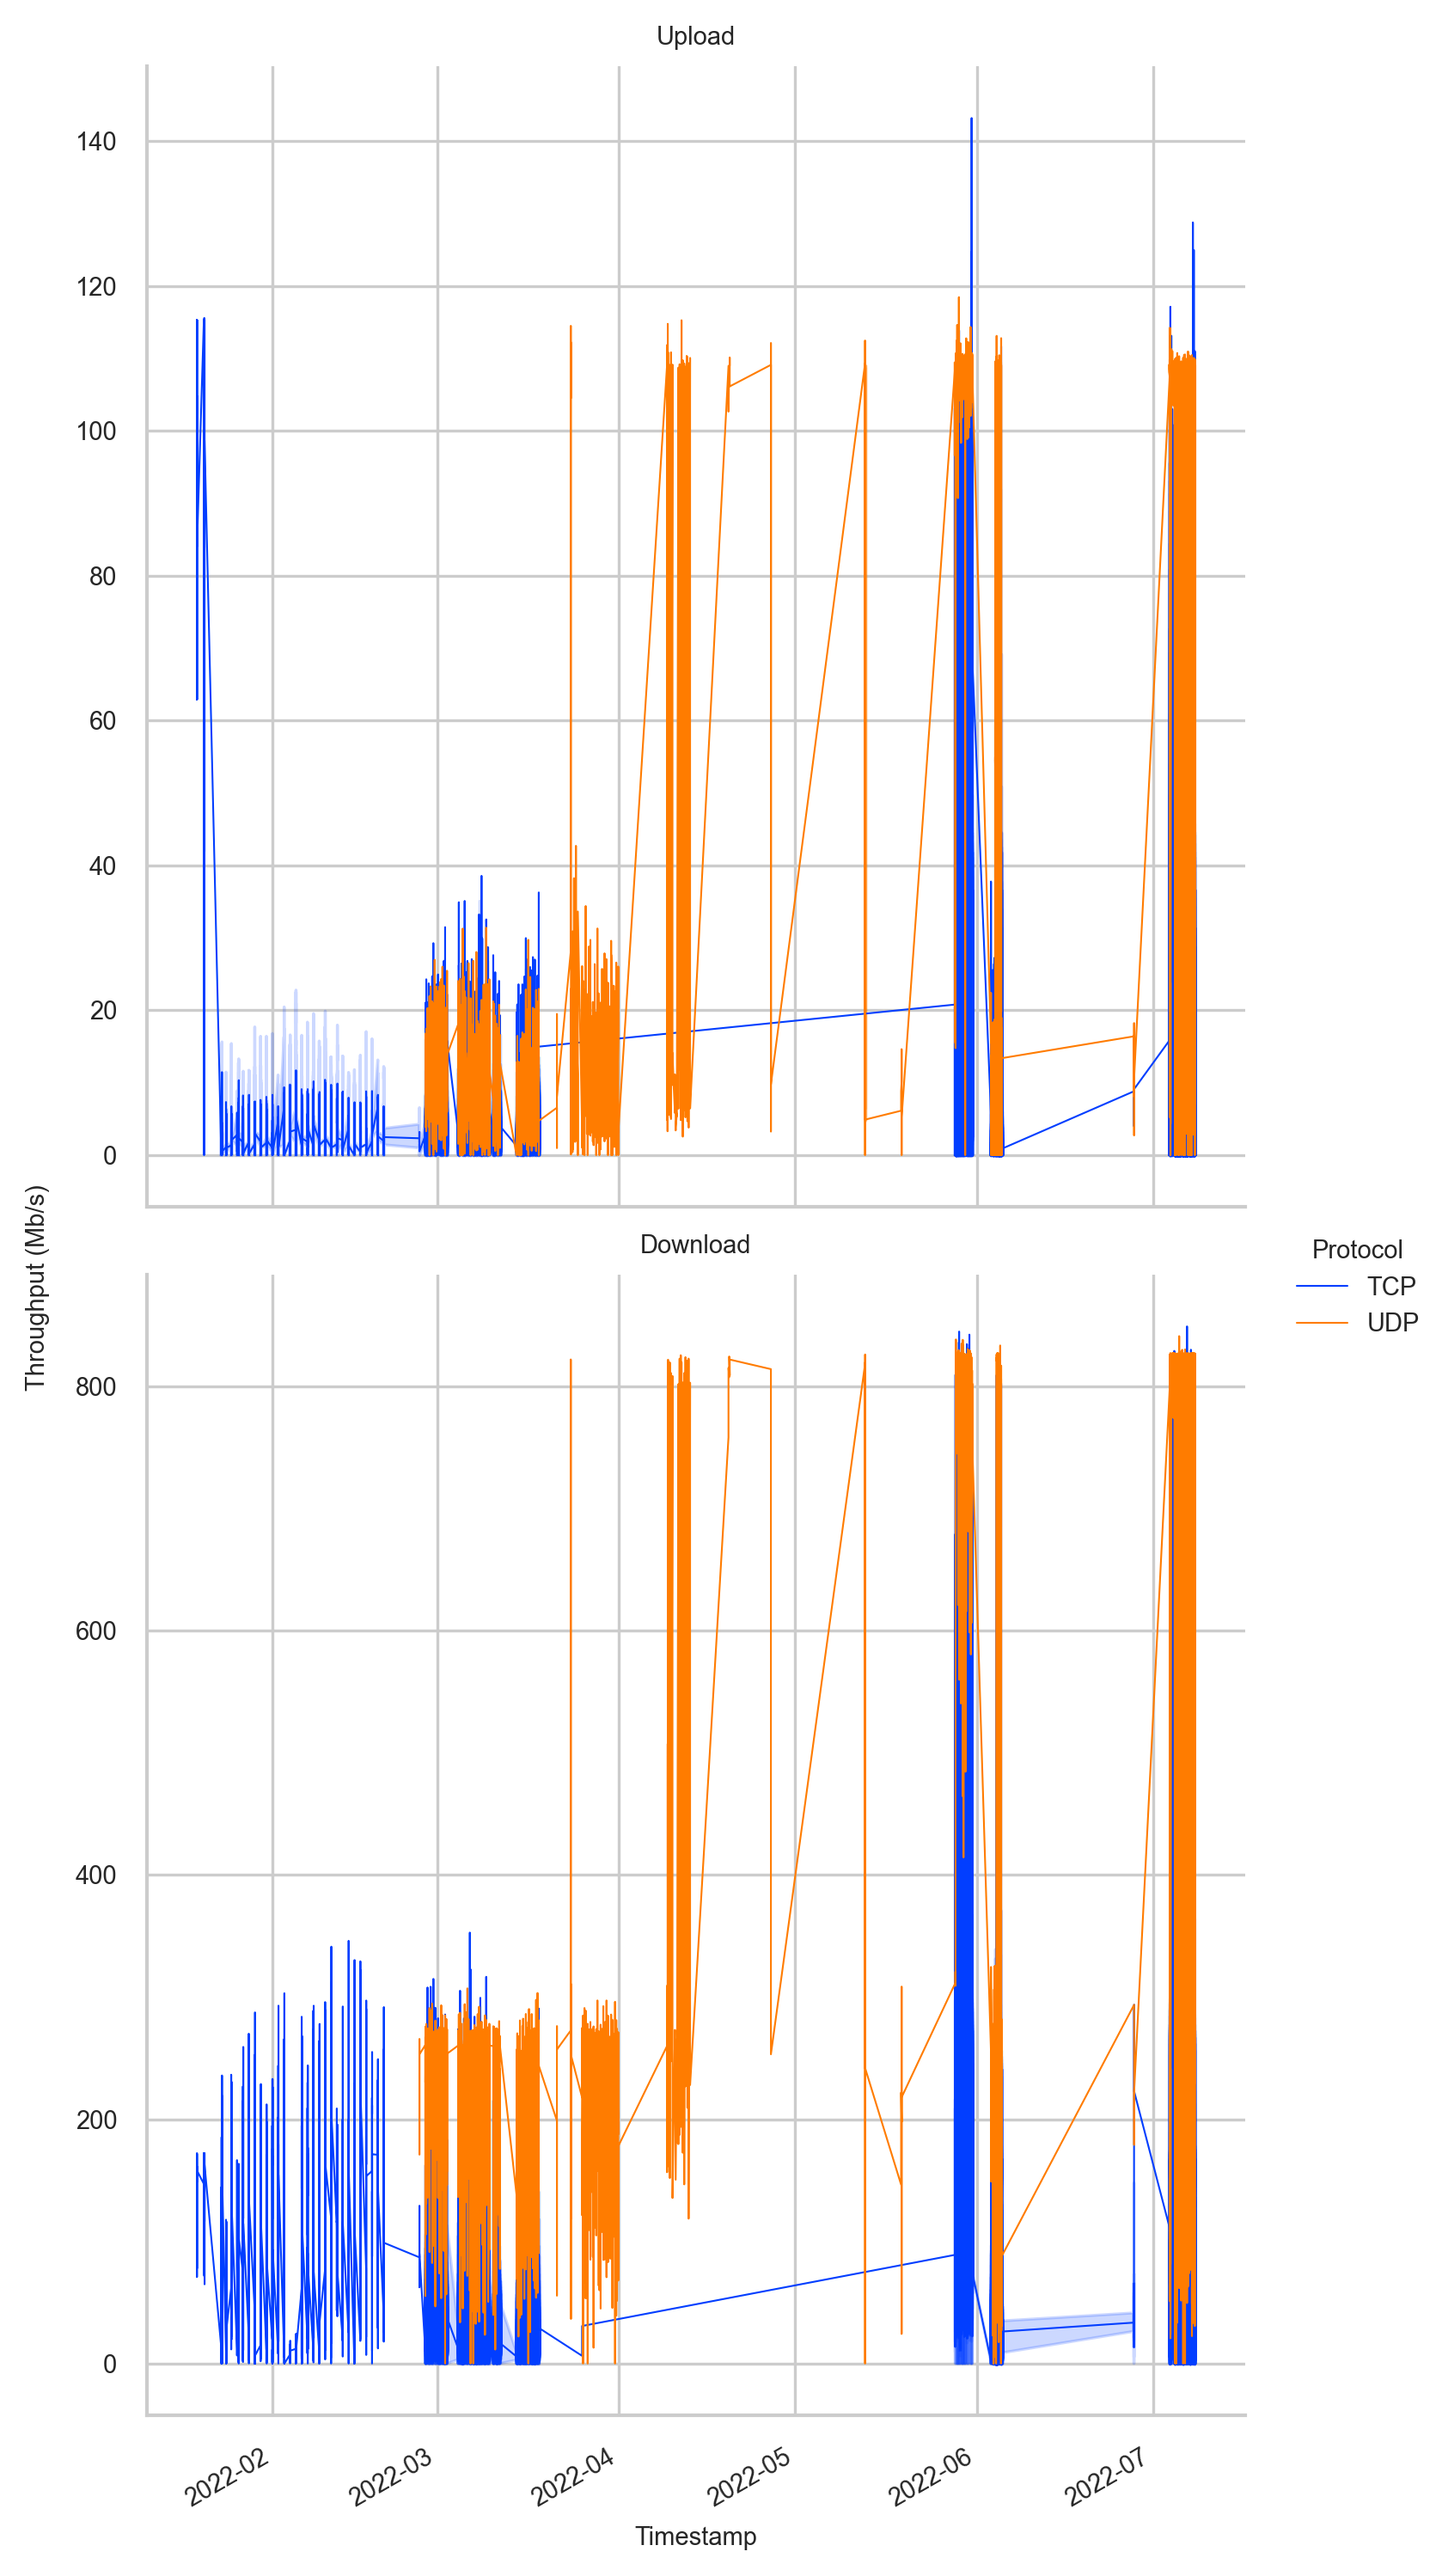

In [89]:
#temp = df_regs_interp.copy()
#temp = temp[temp['timestamp'] > '2022-06-02']
#temp = temp[temp[N_TYPE] == N_STARLINK]

#temp = temp[temp[N_PROTOCOL] == N_TCP]

#temp['Day'] = temp.timestamp.dt.day

g_pat = sns.relplot(data=df_regs_old, row=COL_TRANSF_DIR,
                    hue=N_PROTOCOL,# style=N_PROTOCOL,
                    #height=2, aspect=3.045,
                    kind='line',
                    x=N_TIMESTAMP, y='bandwidth',
                    facet_kws={'sharey': False})

g_pat.figure.autofmt_xdate()

g_pat.set_titles(row_template="{row_name}")
g_pat.set(ylabel="")
g_pat.figure.supylabel('Throughput (Mb/s)')
g_pat.tight_layout()

Day                          2         3         4           5
Transfer Direction                                            
Download            131.040393  5.222841  6.530980  109.697613
Upload                4.580027  5.607615  5.924839    4.428447


Text(0.02, 0.5, 'Throughput (Mb/s)')

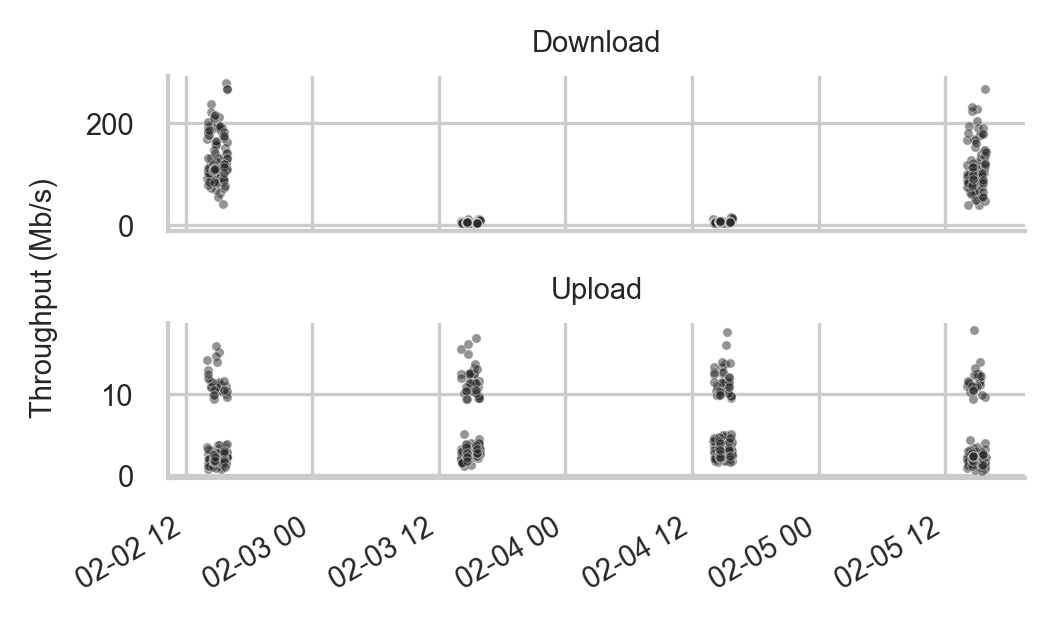

In [111]:
temp = df_regs_interp.copy()
temp = temp[(temp[N_TIMESTAMP] >= '2022-02-02') & (temp[N_TIMESTAMP] <= '2022-02-06')]
temp = temp[temp[N_TYPE] == N_STARLINK]
temp = temp[temp[N_PROTOCOL] == N_TCP]
#temp = temp[temp[COL_TRANSF_DIR] == N_DOWN]
temp['Day'] = temp[N_TIMESTAMP].dt.day
print(temp.pivot_table(index=COL_TRANSF_DIR, columns='Day', values='bandwidth'))

h = 1
aspect = common.WIDTH_HALF / h
sns.set_palette('Greys_r')
g_single = sns.relplot(data=temp, 
                       row=COL_TRANSF_DIR, row_order=[N_DOWN, N_UP],
                       #hue=N_REGIONS, hue_order=common.REGION_ORDER,
                       # style=N_PROTOCOL,
                       height=h, aspect=aspect,
                       kind='scatter', 
                       x=N_TIMESTAMP, y='bandwidth',
                       facet_kws={'sharey': False},
                       s=5,
                       alpha=0.5,
                      )

g_single.figure.autofmt_xdate()

g_single.set_titles(row_template="{row_name}")
g_single.set(ylabel="")
g_single.set(xlabel="")
g_single.figure.supylabel('Throughput (Mb/s)')


In [104]:
g_single.savefig(f'{OUTPUT_FOLDER}/2022-02-02_starlink_throughput_outage.pdf', bbox_inches='tight')

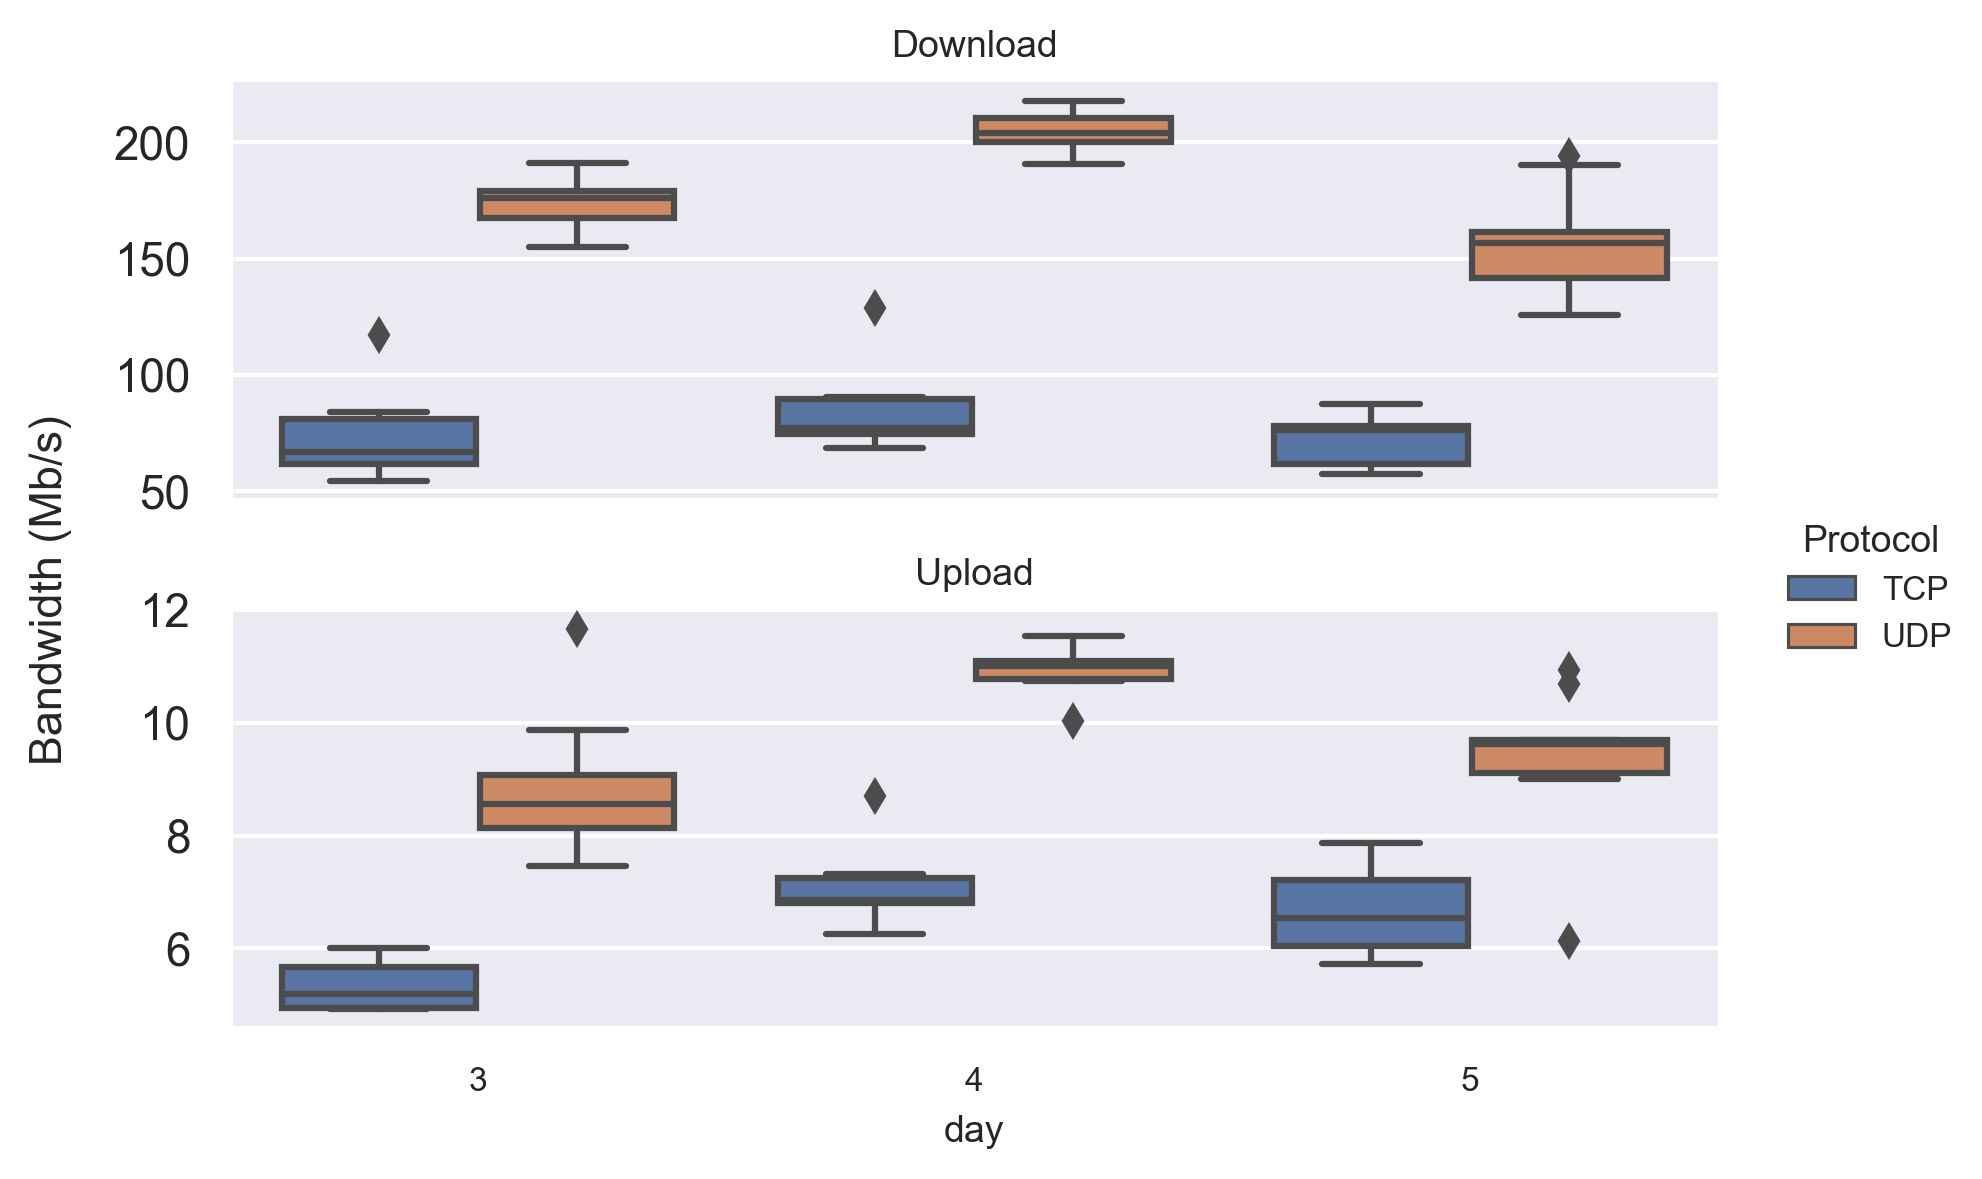

In [80]:
temp = df_regs_interp
temp = temp[temp['timestamp'] > '2022-06-02']
temp = temp[temp[N_TYPE] == N_STARLINK]
temp['day'] = temp.timestamp.dt.day

g_pat = sns.catplot(data=temp, row=COL_TRANSF_DIR,
                    hue=N_PROTOCOL,# style=N_PROTOCOL,
                    height=2, aspect=2.98,
                    kind='box', sharey=False,
                    x='day', y='bandwidth')

#g_pat.figure.autofmt_xdate()

g_pat.set_titles(row_template="{row_name}")
g_pat.set(ylabel="")
g_pat.figure.supylabel('Throughput (Mb/s)')
g_pat.tight_layout()

In [ ]:
from matplotlib.patches import Rectangle
g_bar = sns.catplot(data=df_regs,
                    col=N_PROTOCOL,
                    x=N_REGIONS, y='bandwidth',hue=N_TYPE,
                    ci='sd', 
                    kind='bar', legend=False,
                    height=2, aspect=1.79, col_wrap=2)

#g_bar.set_xticklabels(['TD', 'TU', 'UD', 'UU'])
extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
g_bar.figure.autofmt_xdate()
g_bar.set_titles(col_template="{col_name}")
g_bar.axes.flatten()[1].legend()
#g_bar.add_legend(loc='upper right')
#g_bar.figure.legend([extra, extra, extra, extra], 
#                    ('TD = TCP Download','TU = TCP Upload', 
#                     'UD = UDP Download', 'UU = UDP Upload'),
#                   frameon=False, loc='lower right')
g_bar.set(ylabel="Throughput (Mb/s)")
g_bar.tight_layout()

In [165]:
g_bar.savefig(os.path.join(OUTPUT_FOLDER, 'throughput_summary.pgf'), bbox_inches='tight')

In [219]:
df_downs_only = df_regs[df_regs[N_PROTOCOL].isin([TCP_DOWN, UDP_DOWN])]
df_downs_only[df_downs_only[[N_PROTOCOL, N_REGIONS]].agg('-'.join, axis=1)

0                TCP Down-Mumbai
1                TCP Down-Sydney
2                TCP Down-Sydney
3                TCP Down-Sydney
4                TCP Down-Sydney
                   ...          
112355    UDP Down-N. California
112356    UDP Down-N. California
112357    UDP Down-N. California
112358    UDP Down-N. California
112359    UDP Down-N. California
Length: 73091, dtype: object

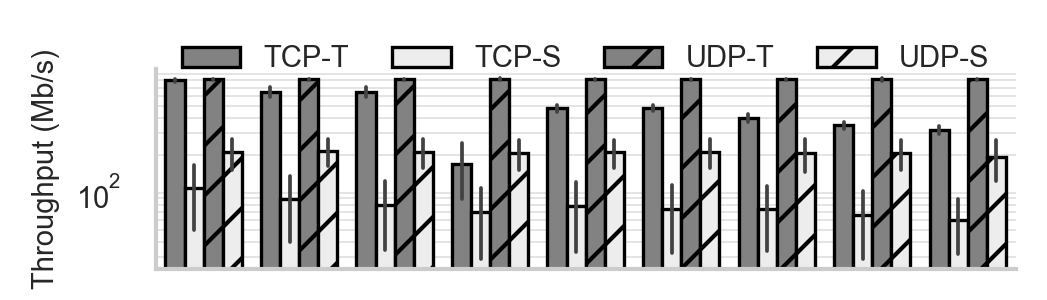

In [51]:
%matplotlib widget

#temp = df_regs.loc['2022-06-03':]
sns.set_palette('Greys')
df_dir = df_outliers
df_dir = df_dir[df_dir['parallel ID'].isna()]
df_dir = df_dir[(df_dir[COL_TRANSF_DIR] == N_DOWN) & (df_dir[N_THROUGHPUT_OUTLIERS] == False)]
labels = ['TCP-T', 'TCP-S', 'UDP-T', 'UDP-S']
df_dir["labels"] = df_dir[COL_PROT_TYPE].map(dict(zip(PROT_TYPE_ORDER, labels)))
h = 1
aspect = 3.49 / h
g_avg = sns.catplot(data=df_dir,
                    #row=COL_TRANSF_DIR,
                    #sharey=False, 
                    log=True,
                    x=N_REGIONS, y='bandwidth', 
                    #hue=COL_PROT_TYPE,
                    #hue_order=PROT_TYPE_ORDER, 
                    hue='labels',
                    hue_order=labels, 
                    row_order=[N_DOWN, N_UP],
                    order=REG_ORDER,
                    legend=False,
                    palette=['C9', 'C0', 'C9', 'C0'],
                    kind='bar', 
                    #kind='point', markers=['.', 'x', '^', 's'], markersize=10,
                    ci='sd',
                    #fliersize=0.5,
                    rasterized=True,
                    height=h, aspect=aspect)

num_locs = len(df_dir[N_REGIONS].unique())
hatches = itertools.cycle(['','', '//', '//'])
#g_avg.set(yscale='log')
axes = g_avg.axes.flatten()
for ax in axes:
    ax.grid(visible=True, which='both', axis='y', color='gray', linewidth=0.1)
    ax.set(xticks=[])
    for i, bar in enumerate(ax.patches):
        if i % num_locs == 0:
            hatch = next(hatches)
        bar.set_hatch(hatch)

axes[0].legend(loc='upper left', bbox_to_anchor=(0,1.05,1,0.2),
               ncol=4, mode='expand',
               #fancybox=True, 
               frameon=False,
              )
#g_avg.set(ylim=(10**0,10**3), yscale='log')
g_avg.figure.autofmt_xdate()
g_avg.set_titles(row_template="")
#g_avg.set(ylabel="")
g_avg.set(ylabel="Throughput (Mb/s)")
g_avg.set(xlabel="")
#g_avg.figure.supylabel("Throughput (Mb/s)")
g_avg.tight_layout()

sns.set_palette('bright')

In [52]:
g_avg.savefig(os.path.join(OUTPUT_FOLDER, '2022-07-08_end_avg_throughput_a.pdf'), bbox_inches='tight')

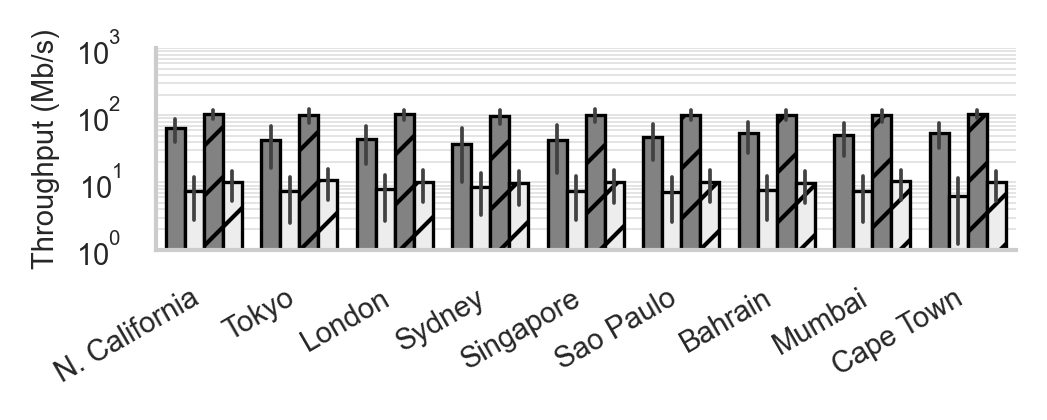

In [55]:
#temp = df_regs.loc['2022-06-03':]
sns.set_palette('Greys')
df_dir = df_outliers
df_dir = df_dir[df_dir['parallel ID'].isna()]
df_dir = df_dir[df_dir[COL_TRANSF_DIR] == N_UP]
labels = ['TCP-H', 'TCP-S', 'UDP-H', 'UDP-S']
df_dir["labels"] = df_dir[COL_PROT_TYPE].map(dict(zip(PROT_TYPE_ORDER, labels)))
h = 1.4
aspect = common.WIDTH_HALF / h
g_avg = sns.catplot(data=df_dir,
                    #row=COL_TRANSF_DIR,
                    #sharey=False, 
                    log=True,
                    x=N_REGIONS, y='bandwidth', 
                    #hue=COL_PROT_TYPE,
                    #hue_order=PROT_TYPE_ORDER, 
                    hue='labels',
                    hue_order=labels, 
                    row_order=[N_DOWN, N_UP],
                    order=REG_ORDER,
                    legend=False,
                    palette=['C9', 'C0', 'C9', 'C0'],
                    kind='bar', 
                    #kind='point', markers=['.', 'x', '^', 's'], markersize=10,
                    ci='sd',
                    rasterized=True,
                    height=h, aspect=aspect)

num_locs = len(df_dir[N_REGIONS].unique())
hatches = itertools.cycle(['','', '//', '//'])
#g_avg.set(yscale='log')
axes = g_avg.axes.flatten()
for ax in axes:
    ax.grid(visible=True, which='both', axis='y', color='gray', linewidth=0.1)
    #ax.set(xticks=[])
    for i, bar in enumerate(ax.patches):
        if i % num_locs == 0:
            hatch = next(hatches)
        bar.set_hatch(hatch)

#axes[0].legend(loc='upper left', bbox_to_anchor=(0,1.05,1,0.2),
#               ncol=4, mode='expand',
#               #fancybox=True, 
#               frameon=False,
#              )

g_avg.set(ylim=(10**0,10**3))
g_avg.figure.autofmt_xdate()
g_avg.set_titles(row_template="")
#g_avg.set(ylabel="")
g_avg.set(ylabel="Throughput (Mb/s)")
g_avg.set(xlabel="")
#g_avg.figure.supylabel("Throughput (Mb/s)")
g_avg.tight_layout()

sns.set_palette('bright')

In [56]:
g_avg.savefig(os.path.join(OUTPUT_FOLDER, '2022-07-08_end_avg_throughput_b.pdf'), bbox_inches='tight')

In [339]:
df_avg_regs = df_regs[df_regs[COL_PARAID].isna()].pivot_table(
    index=N_REGIONS, columns=[N_TYPE, N_PROTOCOL, COL_TRANSF_DIR], values=BANDWIDTH
).reindex(common.REGION_ORDER)
styler = df_avg_regs.style
styler.format(precision=2)
styler.to_latex(os.path.join(OUTPUT_FOLDER, 'all_bandwidth.tex'))
df_avg_regs

Type                      Home                                       Starlink  \
Protocol                   TCP                    UDP                     TCP   
Transfer Direction    Download     Upload    Download      Upload    Download   
Regions                                                                         
N. California       798.894281  64.212674  804.967472  104.417166  107.768868   
Tokyo               647.549223  42.693871  807.792850   99.960105   87.284981   
London              644.713961  43.981169  806.907662  103.486765   78.511829   
Sydney              238.384934  37.659416  804.546188   98.669532   70.716130   
Singapore           475.389403  43.250484  805.452512  101.023070   78.113442   
Sao Paulo           481.630750  47.675411  807.844091  103.207801   73.831435   
Bahrain             398.050652  54.072516  810.589963  103.203807   74.488319   
Mumbai              346.690810  51.345364  803.791412  101.650222   66.433163   
Cape Town           318.901913  55.623818  816.026524  105.582805   68.505973   

Type                                                 
Protocol                             UDP             
Transfer Direction    Upload    Download     Upload  
Regions                                              
N. California       6.262161  201.416215  10.410809  
Tokyo               6.243014  205.720970  11.176077  
London              6.083464  203.556060  10.164528  
Sydney              7.158693  200.083203  10.095486  
Singapore           6.333427  202.500429  10.562983  
Sao Paulo           6.126066  205.390896  10.485040  
Bahrain             6.135501  194.268068   9.897429  
Mumbai              6.292338  196.204254  10.331989  
Cape Town           6.341941  193.674441  10.065874

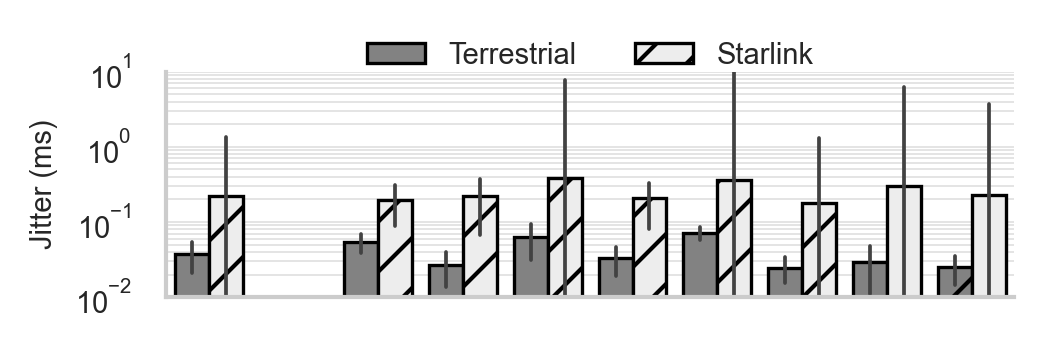

In [71]:
#temp = df_regs.loc['2022-06-03':]
sns.set_palette('Greys')
tmp = df_outliers[(df_outliers[N_TYPE] == N_STARLINK) | (df_outliers[N_THROUGHPUT_OUTLIERS] == False)]
tmp = tmp[tmp[COL_TRANSF_DIR] == N_DOWN]
h = 1.2
aspect = 3.49 / h
g_jitter = sns.catplot(data=tmp,
                    #row=COL_TRANSF_DIR,
                    sharey=False, log=True,
                    x=N_REGIONS,
                    row_order=[N_DOWN, N_UP],
                    y='jitter_ms', 
                    hue=N_TYPE, hue_order=[N_HOME, N_STARLINK],
                    order=common.REGION_ORDER,
                    legend=False,
                    palette=['C9', 'C0'],
                    kind='bar', ci='sd',
                    height=h, aspect=aspect)

num_locs = len(tmp[N_REGIONS].unique())
hatches = itertools.cycle(['', '//'])
axes = g_jitter.axes.flatten()
for ax in axes:
    ax.grid(visible=True, which='both', axis='y', color='gray', linewidth=0.1)
    ax.set(xticks=[])
    for i, bar in enumerate(ax.patches):
        if i % num_locs == 0:
            hatch = next(hatches)
        bar.set_hatch(hatch)
        
axes[0].legend(loc='upper center', bbox_to_anchor=(0,1.05,1,0.2),
               ncol=2, 
               #mode='expand',
               fancybox=True, frameon=False)
g_jitter.set(ylim=(10**-2,10**1))
g_jitter.figure.autofmt_xdate()
g_jitter.set_titles(row_template="")
g_jitter.set(ylabel="Jitter (ms)")
g_jitter.set(xlabel="")
#g_jitter.figure.supylabel("Jitter (ms)")
g_jitter.tight_layout()

In [213]:
g_jitter.savefig(os.path.join(OUTPUT_FOLDER, '2022-06-05_end_udp_jitter_avg_a.pdf'), bbox_inches='tight')

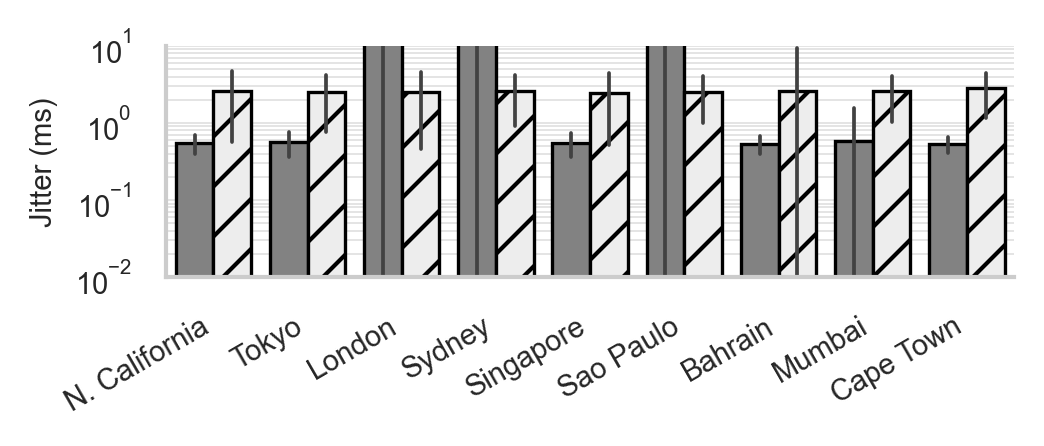

In [93]:
#temp = df_regs.loc['2022-06-03':]
sns.set_palette('Greys')
tmp = df_regs
#tmp = tmp[(tmp[N_TYPE] == N_STARLINK) | (tmp[N_THROUGHPUT_OUTLIERS] == False)]
tmp = tmp[tmp[COL_TRANSF_DIR] == N_UP]
h = 1.5
aspect = 3.49 / h
g_jitter_b = sns.catplot(data=tmp,
                    #row=COL_TRANSF_DIR,
                    sharey=False, log=True,
                    x=N_REGIONS,
                    row_order=[N_DOWN, N_UP],
                    y='jitter_ms', 
                    hue=N_TYPE, hue_order=[N_HOME, N_STARLINK],
                    order=REG_ORDER,
                    legend=False,
                    palette=['C9', 'C0'],
                    kind='bar', ci='sd',
                    height=h, aspect=aspect)

num_locs = len(tmp[N_REGIONS].unique())
hatches = itertools.cycle(['', '//'])
axes = g_jitter_b.axes.flatten()
for ax in axes:
    ax.grid(visible=True, which='both', axis='y', color='gray', linewidth=0.1)
    #ax.set(xticks=[])
    for i, bar in enumerate(ax.patches):
        if i % num_locs == 0:
            hatch = next(hatches)
        bar.set_hatch(hatch)
        
#axes[0].legend(loc='upper center', bbox_to_anchor=(0,1.05,1,0.2),
#               ncol=2, 
#               #mode='expand',
#               fancybox=True, frameon=False)
g_jitter_b.set(ylim=(10**-2,10**1))
g_jitter_b.figure.autofmt_xdate()
g_jitter_b.set_titles(row_template="")
g_jitter_b.set(ylabel="Jitter (ms)")
g_jitter_b.set(xlabel="")
#g_jitter_b.figure.supylabel("Jitter (ms)")
g_jitter_b.tight_layout()

In [91]:
g_jitter_b.savefig(os.path.join(OUTPUT_FOLDER, '2022-06-05_end_udp_jitter_avg_b.pdf'), bbox_inches='tight')

In [29]:
tmp.pivot_table(index=COL_TRANSF_DIR, columns=N_TYPE, values='jitter_ms')

Type                    Home  Starlink  Starlink Remote
Transfer Direction                                     
Download            0.041103  0.254756         0.925259
Upload              0.545534  2.715160         8.988243

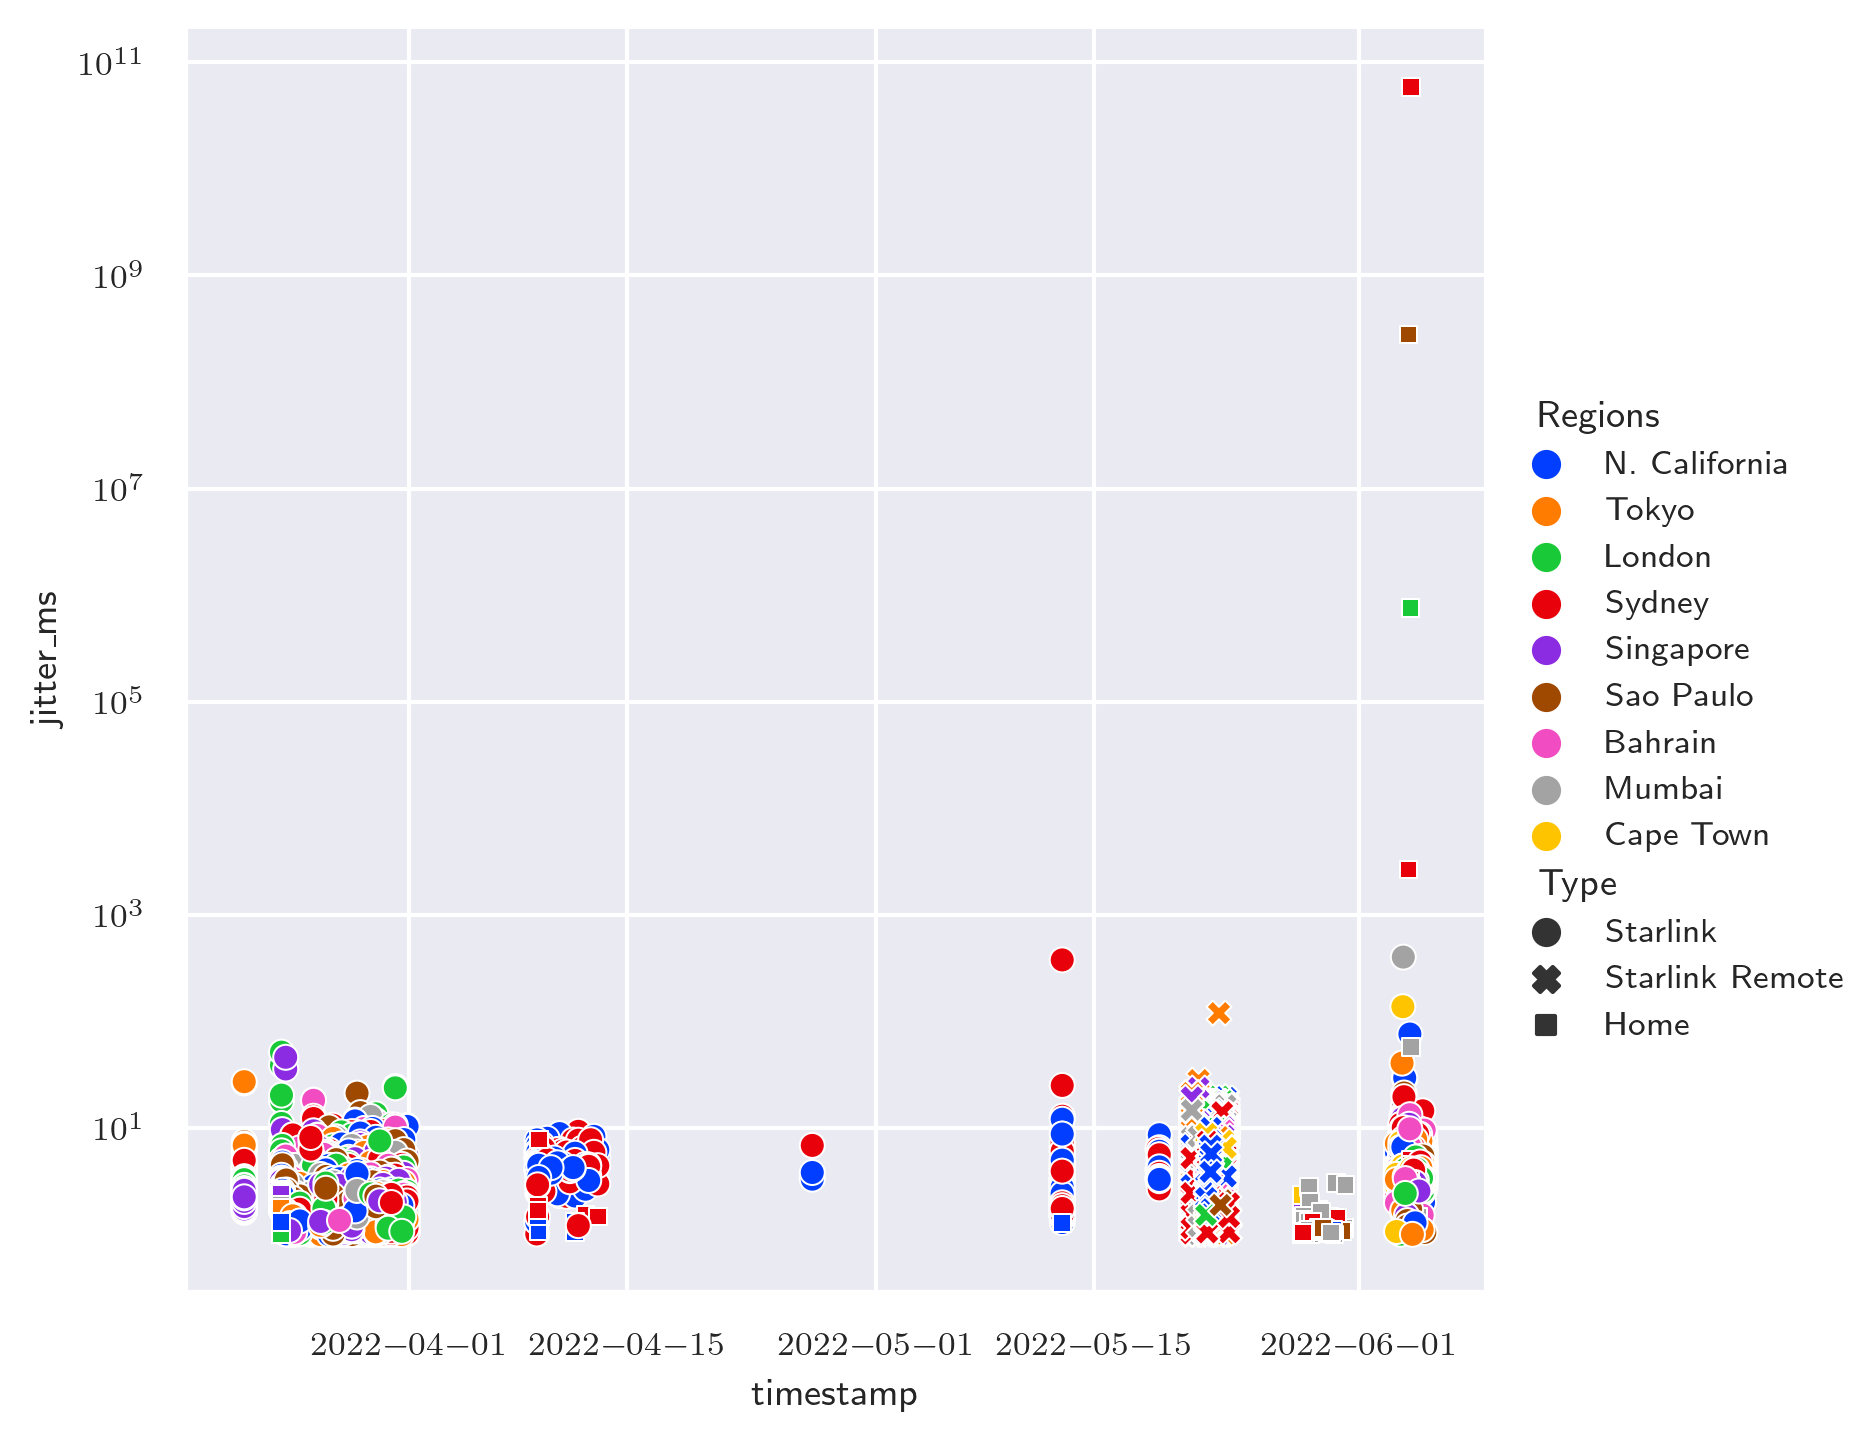

In [136]:
df_home_jitter_out = df_outliers[(df_outliers['jitter_ms'] > 1)]
g_out = sns.relplot(
    data=df_home_jitter_out,
    x='timestamp',
    y='jitter_ms',
    hue=N_REGIONS, hue_order=common.REGION_ORDER,
    style=N_TYPE,
)

g_out.set(yscale='log')

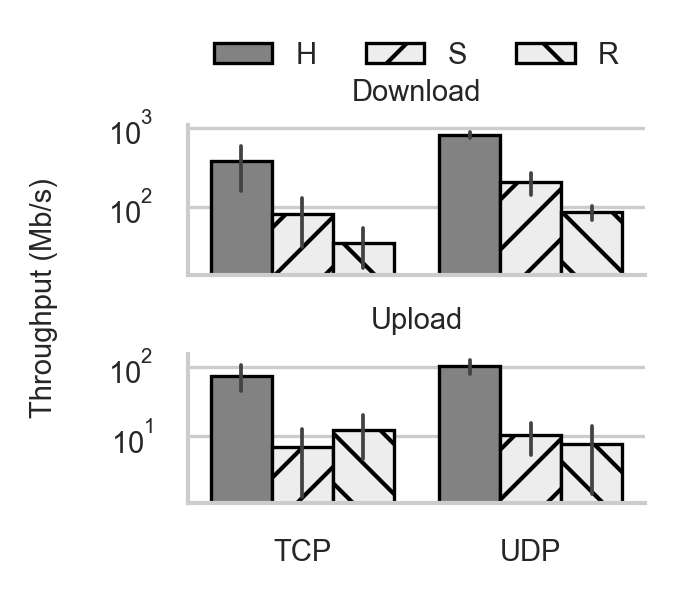

In [313]:
#temp = df_regs.loc['2022-06-03':]
sns.set_palette('Greys')
old = ['Home', 'Starlink', 'Starlink Remote']
new = ['H', 'S', 'R']
df_temp = df_regs_all
df_temp['label_type'] = df_temp[N_TYPE].map(dict(zip(old, new)))
h = 1
aspect = WIDTH_THIRD / h
g_avg_small = sns.catplot(data=df_temp, row=COL_TRANSF_DIR,
                    sharey=False, log=True,
                    x=N_PROTOCOL, y='bandwidth', hue='label_type',
                    hue_order=new,
                    #palette=['C3']*3,
                    order=[N_TCP, N_UDP], row_order=[N_DOWN, N_UP],
                          palette=['C9', 'C0', 'C0'],
                    legend=False,
                    kind='bar', ci='sd',
                    height=h, aspect=aspect)

num_locs = len(df_temp[N_PROTOCOL].unique())
axes = g_avg_small.axes.flatten()
hatches = itertools.cycle(['', '//', '\\\\'])
for ax in axes:
    #ax.grid(visible=True, which='both', axis='y', color='gray', linewidth=0.1)
    #ax.set(xticks=[])
    for i, bar in enumerate(ax.patches):
        if i % num_locs == 0:
            hatch = next(hatches)
        bar.set_hatch(hatch)

#axes[0].legend(loc='lower left', bbox_to_anchor=(1.01,0), fancybox=True, frameon=False)
axes[0].legend(loc='lower left', bbox_to_anchor=(0,1.20,1,0.2), ncol=3, mode='expand', fancybox=True, frameon=False)
#axes[0].legend(loc='lower left', bbox_to_anchor=(0,1.02,1,0.2), mode='expand', ncol=3, fancybox=True, frameon=False)
#g_avg_small.figure.autofmt_xdate()
g_avg_small.set_titles(row_template="{row_name}")
g_avg_small.set(ylabel="", xlabel="")
g_avg_small.figure.supylabel("Throughput (Mb/s)")
g_avg_small.tight_layout()

In [314]:
g_avg_small.savefig(os.path.join(OUTPUT_FOLDER, '2022-06-21_end_throughput_koeye_summary.pdf'), bbox_inches='tight')

In [13]:
sns.plotting_context()

{'font.size': 9.0,
 'axes.labelsize': 9.0,
 'axes.titlesize': 9.0,
 'xtick.labelsize': 8.0,
 'ytick.labelsize': 8.8,
 'legend.fontsize': 8.0,
 'axes.linewidth': 1.0,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.2000000000000002,
 'lines.markersize': 4.800000000000001,
 'patch.linewidth': 0.8,
 'xtick.major.width': 1.0,
 'ytick.major.width': 1.0,
 'xtick.minor.width': 0.8,
 'ytick.minor.width': 0.8,
 'xtick.major.size': 4.800000000000001,
 'ytick.major.size': 4.800000000000001,
 'xtick.minor.size': 3.2,
 'ytick.minor.size': 3.2,
 'legend.title_fontsize': 9.0}

In [332]:
def diff_table(table):
    df_perc = table.pivot_table(index=[N_PROTOCOL, N_REGIONS], columns=N_TYPE, values='bandwidth')
    df_perc['diff'] = df_perc['Home'] - df_perc['Starlink']
    return df_perc.reset_index().pivot_table(index=N_PROTOCOL, columns=N_REGIONS, values='diff')

#diff_table(df_regs)
#diff_table(df_regs.groupby([N_TYPE, N_PROTOCOL, N_REGIONS]).mean().reset_index())

#df_agg = df_regs.groupby([N_TYPE, N_PROTOCOL, N_REGIONS]).max().reset_index()

#df_agg.pivot_table(index=N_REGIONS, columns=[N_TYPE, N_PROTOCOL], values='bandwidth')
#df_agg = df_regs[df_regs[N_TYPE] == N_STARLINK]
#df_agg = df_agg[df_agg[COL_TRANSF_DIR] == N_DOWN]
#df_agg = df_agg[df_agg[N_PROTOCOL] == N_UDP]
#df_agg = df_agg[df_agg['lost_percent'] == 0]
#df_agg[df_agg['bandwidth'] < 200]

Regions      Bahrain   Cape Town      London      Mumbai  N. California  \
Protocol                                                                  
TCP        67.119171   55.834125  108.921917   57.119920     136.162616   
UDP       317.443595  335.789284  313.196314  310.319257     319.836165   

Regions    Sao Paulo   Singapore      Sydney       Tokyo  
Protocol                                                  
TCP        81.754842   73.882104   99.681519  105.193350  
UDP       317.893850  296.971091  280.048385  295.448007

In [106]:
#df_avg = df_outliers[df_outliers['bandwidth'] > 0]
#df_avg = df_avg[df_avg[N_THROUGHPUT_OUTLIERS] == False]
#df_avg = df_regs.pivot_table(index=N_REGIONS, columns=[N_TYPE, N_PROTOCOL, COL_TRANSF_DIR], values='bandwidth', aggfunc='count').reindex(common.REGION_ORDER)

df_avg = df_outliers#[df_outliers[N_REGIONS] != 'Sydney']
df_std = df_avg
df_avg = df_avg.pivot_table(
    index=COL_TRANSF_DIR, columns=[N_TYPE, N_PROTOCOL], values='bandwidth',
    aggfunc='mean'
)
df_std = df_std.pivot_table(
    index=COL_TRANSF_DIR, columns=[N_TYPE, N_PROTOCOL], values='bandwidth',
    aggfunc='std'
)
df_out = df_std / df_avg

#styler = df_avg.style
#styler.format(precision=2)
#styler.to_latex(os.path.join(OUTPUT_FOLDER, 'all_bandwidth.tex'))
df_avg
#df_scale = pd.DataFrame()
#left_comp = N_STARLINK
#right_comp = N_HOME
#df_scale[N_TCP] = df_avg[left_comp][N_TCP] / df_avg[right_comp][N_TCP]
#df_scale[N_UDP] = df_avg[left_comp][N_UDP] / df_avg[right_comp][N_UDP]
#df_scale['R_TCP / R_UDP'] = df_avg[N_STARLINK_REMOTE][N_UDP] / df_avg[N_STARLINK_REMOTE][N_TCP]
#df_scale

Type                 Remote H            
Protocol                  TCP         UDP
Transfer Direction                       
Download            13.386783  105.891006
Upload               4.097664   12.762187

In [277]:
df_outliers[
    (df_outliers[N_TYPE] == N_HOME) &
    (df_outliers[N_REGIONS] == 'Sydney') &
    (df_outliers[N_PROTOCOL] == N_TCP) &
    (df_outliers['bandwidth'] < 200)
].sort_values('timestamp')

timestamp   bandwidth Regions Protocol  \
294623 2022-01-19 01:55:24.000022016+00:00  148.455179  Sydney      TCP   
295939 2022-01-19 01:55:25.000065024+00:00  150.932930  Sydney      TCP   
302568 2022-01-19 01:55:26.000061952+00:00  159.103829  Sydney      TCP   
299166 2022-01-19 01:55:27.000076032+00:00  155.471983  Sydney      TCP   
294959    2022-01-19 01:55:28.000128+00:00  148.963180  Sydney      TCP   
...                                    ...         ...     ...      ...   
198053 2022-06-05 03:00:27.000150016+00:00   71.851434  Sydney      TCP   
211253 2022-06-05 03:00:28.000201984+00:00   83.293167  Sydney      TCP   
209498 2022-06-05 03:00:29.000119808+00:00   81.777767  Sydney      TCP   
274009 2022-06-05 03:00:30.000293888+00:00  114.843497  Sydney      TCP   
211342 2022-06-05 03:00:31.000088064+00:00   83.360980  Sydney      TCP   

       Transfer Direction  Type Protocol and Type  jitter_ms  lost_packets  \
294623           Download  Home          TCP Home        NaN           NaN   
295939           Download  Home          TCP Home        NaN           NaN   
302568           Download  Home          TCP Home        NaN           NaN   
299166           Download  Home          TCP Home        NaN           NaN   
294959           Download  Home          TCP Home        NaN           NaN   
...                   ...   ...               ...        ...           ...   
198053             Upload  Home          TCP Home        NaN           NaN   
211253             Upload  Home          TCP Home        NaN           NaN   
209498             Upload  Home          TCP Home        NaN           NaN   
274009             Upload  Home          TCP Home        NaN           NaN   
211342             Upload  Home          TCP Home        NaN           NaN   

        packets  lost_percent  Throughput Outliers  
294623      NaN           NaN                False  
295939      NaN           NaN                False  
302568      NaN           NaN                False  
299166      NaN           NaN                False  
294959      NaN           NaN                False  
...         ...           ...                  ...  
198053      NaN           NaN                False  
211253      NaN           NaN                False  
209498      NaN           NaN                False  
274009      NaN           NaN                False  
211342      NaN           NaN                False  

[25770 rows x 12 columns]

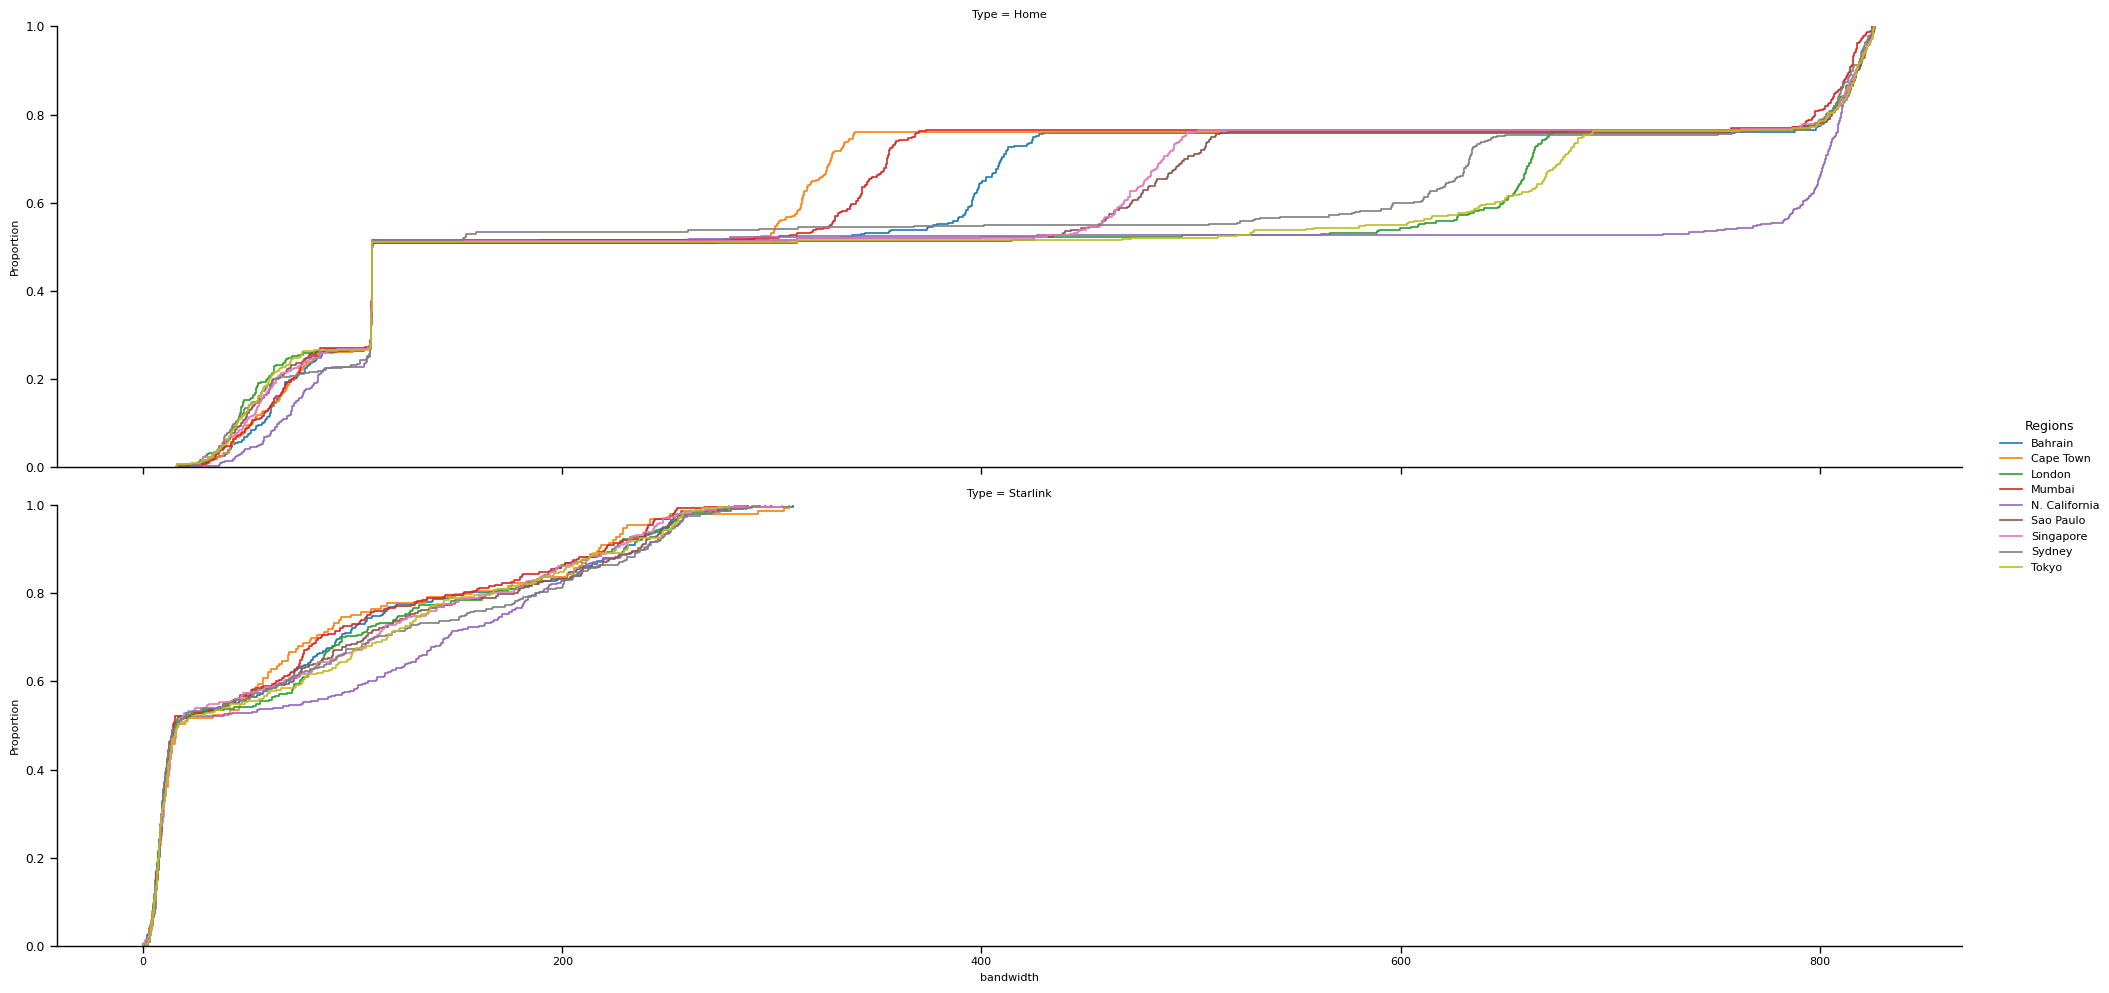

In [135]:
#fig2, ax2 = plt.subplots(figsize=(20,10))
g2 = sns.FacetGrid(data=df_unstacked, row=N_TYPE, hue=N_REGIONS, height=5, aspect=4)
g2.map(sns.ecdfplot, 'bandwidth')
g2.add_legend()
g2.tight_layout()
#fig2.tight_layout()

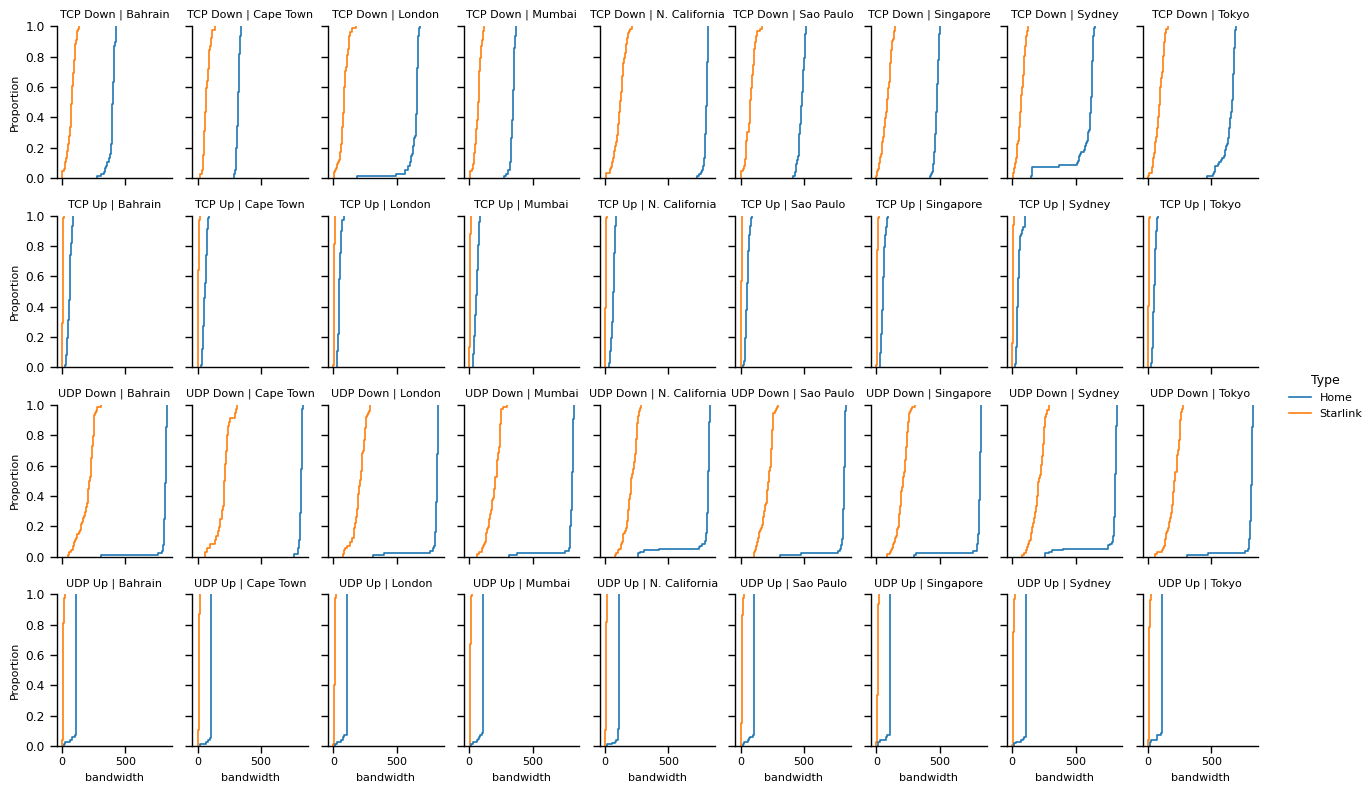

In [136]:
g_hist = sns.displot(
    data=df_unstacked, 
    x='bandwidth', col=N_REGIONS, row=N_PROTOCOL, hue=N_TYPE, kind='ecdf', height=2, aspect=0.716)
g_hist.set_titles(col_template="{col_name}", row_template="{row_name}")
g_hist.tight_layout()

In [150]:
g.savefig(f'output/throughput/throughput.pdf', bbox_inches='tight')
g2.savefig(f'output/throughput/throughput_cdf.pdf', bbox_inches='tight')
#fig.savefig(f'output/throughput/throughput.png', bbox_inches='tight')
#fig2.savefig(f'output/throughput/throughput_cdf.png', bbox_inches='tight')

In [16]:
# https://stackoverflow.com/questions/69300483/how-to-use-markers-with-ecdf-plot
def ecdf(data, array: bool=True):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    if not array:
        return pd.DataFrame({'x': x, 'y': y})
    else:
        return x, y

In [57]:
# https://stackoverflow.com/questions/25577352/plotting-cdf-of-a-pandas-series-in-python
def cdf(data, col):
    stats_df = data \
        .groupby(col) \
        [col] \
        .agg('count') \
        .pipe(pd.DataFrame) \
        .rename(columns = {col: 'frequency'})

    # PDF
    stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])

    # CDF
    stats_df['cdf'] = stats_df['pdf'].cumsum()
    stats_df = stats_df.reset_index()
    return stats_df

In [109]:
df_cdf = df_regs_interp[#(df_regs_interp[N_THROUGHPUT_OUTLIERS] == False) & 
    (df_regs_interp[COL_PARAID].isnull())
   ].dropna(how='all').groupby([N_TYPE, COL_TRANSF_DIR, N_PROTOCOL, N_REGIONS]
        )['bandwidth'].apply(ecdf, False)
#df_cdf = df_processed.value_counts().sort_index().cumsum() * 1./len(df_processed)
df_cdf = df_cdf.reset_index()
df_cdf

Type Transfer Direction Protocol  Regions  level_4           x  \
0        Starlink           Download      TCP  Bahrain        0    1.430223   
1        Starlink           Download      TCP  Bahrain        1    3.020568   
2        Starlink           Download      TCP  Bahrain        2    4.895617   
3        Starlink           Download      TCP  Bahrain        3   39.449429   
4        Starlink           Download      TCP  Bahrain        4   45.862556   
...           ...                ...      ...      ...      ...         ...   
5182  Terrestrial             Upload      UDP    Tokyo      107  109.120477   
5183  Terrestrial             Upload      UDP    Tokyo      108  109.121853   
5184  Terrestrial             Upload      UDP    Tokyo      109  109.138924   
5185  Terrestrial             Upload      UDP    Tokyo      110  109.153572   
5186  Terrestrial             Upload      UDP    Tokyo      111  109.159861   

             y  
0     0.021739  
1     0.043478  
2     0.065217  
3     0.086957  
4     0.108696  
...        ...  
5182  0.964286  
5183  0.973214  
5184  0.982143  
5185  0.991071  
5186  1.000000  

[5187 rows x 7 columns]

In [118]:
df_regs_interp[(df_regs_interp[COL_PARAID].isnull()) &
               (df_regs_interp[N_REGIONS] == 'Sydney') &
               (df_regs_interp[N_TYPE] == N_HOME) &
               (df_regs_interp[COL_TRANSF_DIR] == N_UP)
              ]

Type Regions Protocol Protocol and Type Transfer Direction  \
262982  Terrestrial  Sydney      TCP   TCP Terrestrial             Upload   
263146  Terrestrial  Sydney      TCP   TCP Terrestrial             Upload   
263150  Terrestrial  Sydney      TCP   TCP Terrestrial             Upload   
268604  Terrestrial  Sydney      UDP   UDP Terrestrial             Upload   
268605  Terrestrial  Sydney      UDP   UDP Terrestrial             Upload   
...             ...     ...      ...               ...                ...   
272731  Terrestrial  Sydney      UDP   UDP Terrestrial             Upload   
272732  Terrestrial  Sydney      UDP   UDP Terrestrial             Upload   
272772  Terrestrial  Sydney      UDP   UDP Terrestrial             Upload   
272895  Terrestrial  Sydney      UDP   UDP Terrestrial             Upload   
272899  Terrestrial  Sydney      UDP   UDP Terrestrial             Upload   

        Throughput Outliers                 Timestamp   bandwidth  \
262982                False 2022-05-28 00:00:00-07:00   54.919749   
263146                False 2022-06-03 20:00:00-07:00   41.903729   
263150                False 2022-06-04 00:00:00-07:00   13.829429   
268604                False 2022-03-23 11:00:00-07:00   28.015169   
268605                False 2022-03-23 12:00:00-07:00  109.069564   
...                     ...                       ...         ...   
272731                 True 2022-05-28 00:00:00-07:00   15.993271   
272732                 True 2022-05-28 01:00:00-07:00   15.967548   
272772                 True 2022-05-29 17:00:00-07:00    4.103209   
272895                 True 2022-06-03 20:00:00-07:00   12.602548   
272899                 True 2022-06-04 00:00:00-07:00   20.965461   

           jitter_ms  lost_packets       packets  lost_percent  snd_cwnd  rtt  \
262982           NaN           NaN           NaN           NaN       NaN  NaN   
263146           NaN           NaN           NaN           NaN       NaN  NaN   
263150           NaN           NaN           NaN           NaN       NaN  NaN   
268604  1.709762e+00      0.000000   2343.269231      0.000000       NaN  NaN   
268605  5.241885e-01   3590.740741  12709.555556     28.263929       NaN  NaN   
...              ...           ...           ...           ...       ...  ...   
272731  1.464942e+00      0.000000    791.500000      0.000000       NaN  NaN   
272732  1.182958e+00      1.407407   1337.814815      0.101792       NaN  NaN   
272772  4.803869e-01     64.750000    419.250000      3.861061       NaN  NaN   
272895  2.668571e+03     40.000000   1128.000000      3.546099       NaN  NaN   
272899  1.735960e+09   6475.147059   8182.647059     67.093401       NaN  NaN   

        rttvar  retransmits  parallel ID  
262982     NaN          NaN          NaN  
263146     NaN          NaN          NaN  
263150     NaN          NaN          NaN  
268604     NaN          NaN          NaN  
268605     NaN          NaN          NaN  
...        ...          ...          ...  
272731     NaN          NaN          NaN  
272732     NaN          NaN          NaN  
272772     NaN          NaN          NaN  
272895     NaN          NaN          NaN  
272899     NaN          NaN          NaN  

[140 rows x 17 columns]

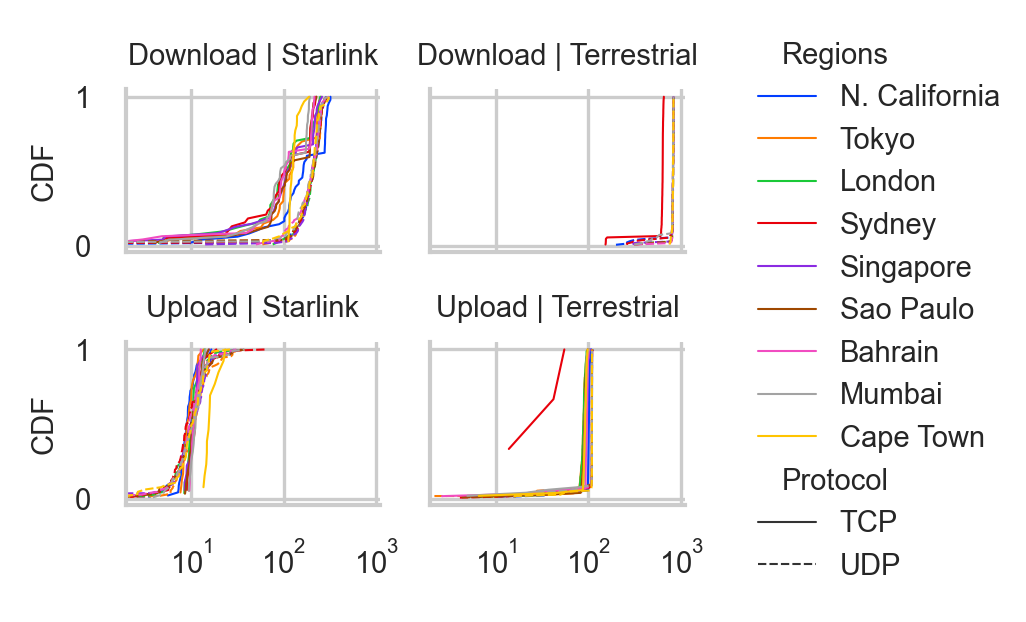

In [115]:
#fig, ax =df_sampleubplots(figsize=(3.5,2))
#fig, ax = plt.subplots(figsize=(7.16,2.5))
#fig_cdf, ax_cdf = plt.subplots(figsize=(7.16,2.5))

h = 1
aspect = (common.WIDTH_HALF - 1) / 2 / h

#g = sns.ecdfplot(data=df_unstacked, x='latency', hue='Type Region', ax=ax)
g_cdf = sns.relplot(data=df_cdf, x='x', y='y', 
                    hue=N_REGIONS,  hue_order=REG_ORDER, 
                    col=N_TYPE, col_order=[N_STARLINK, N_HOME],
                    row=COL_TRANSF_DIR,
                    style=N_PROTOCOL,
                    palette='bright',
                    kind='line',
                    facet_kws=dict(sharex=True),
                    height=h, aspect=aspect)
#g.set(xscale='log')
#g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g_cdf.set_titles(col_template='{col_name}', row_template='{row_name}')
g_cdf.set(xlabel='', ylabel='CDF', xscale='log')
g_cdf.tight_layout()

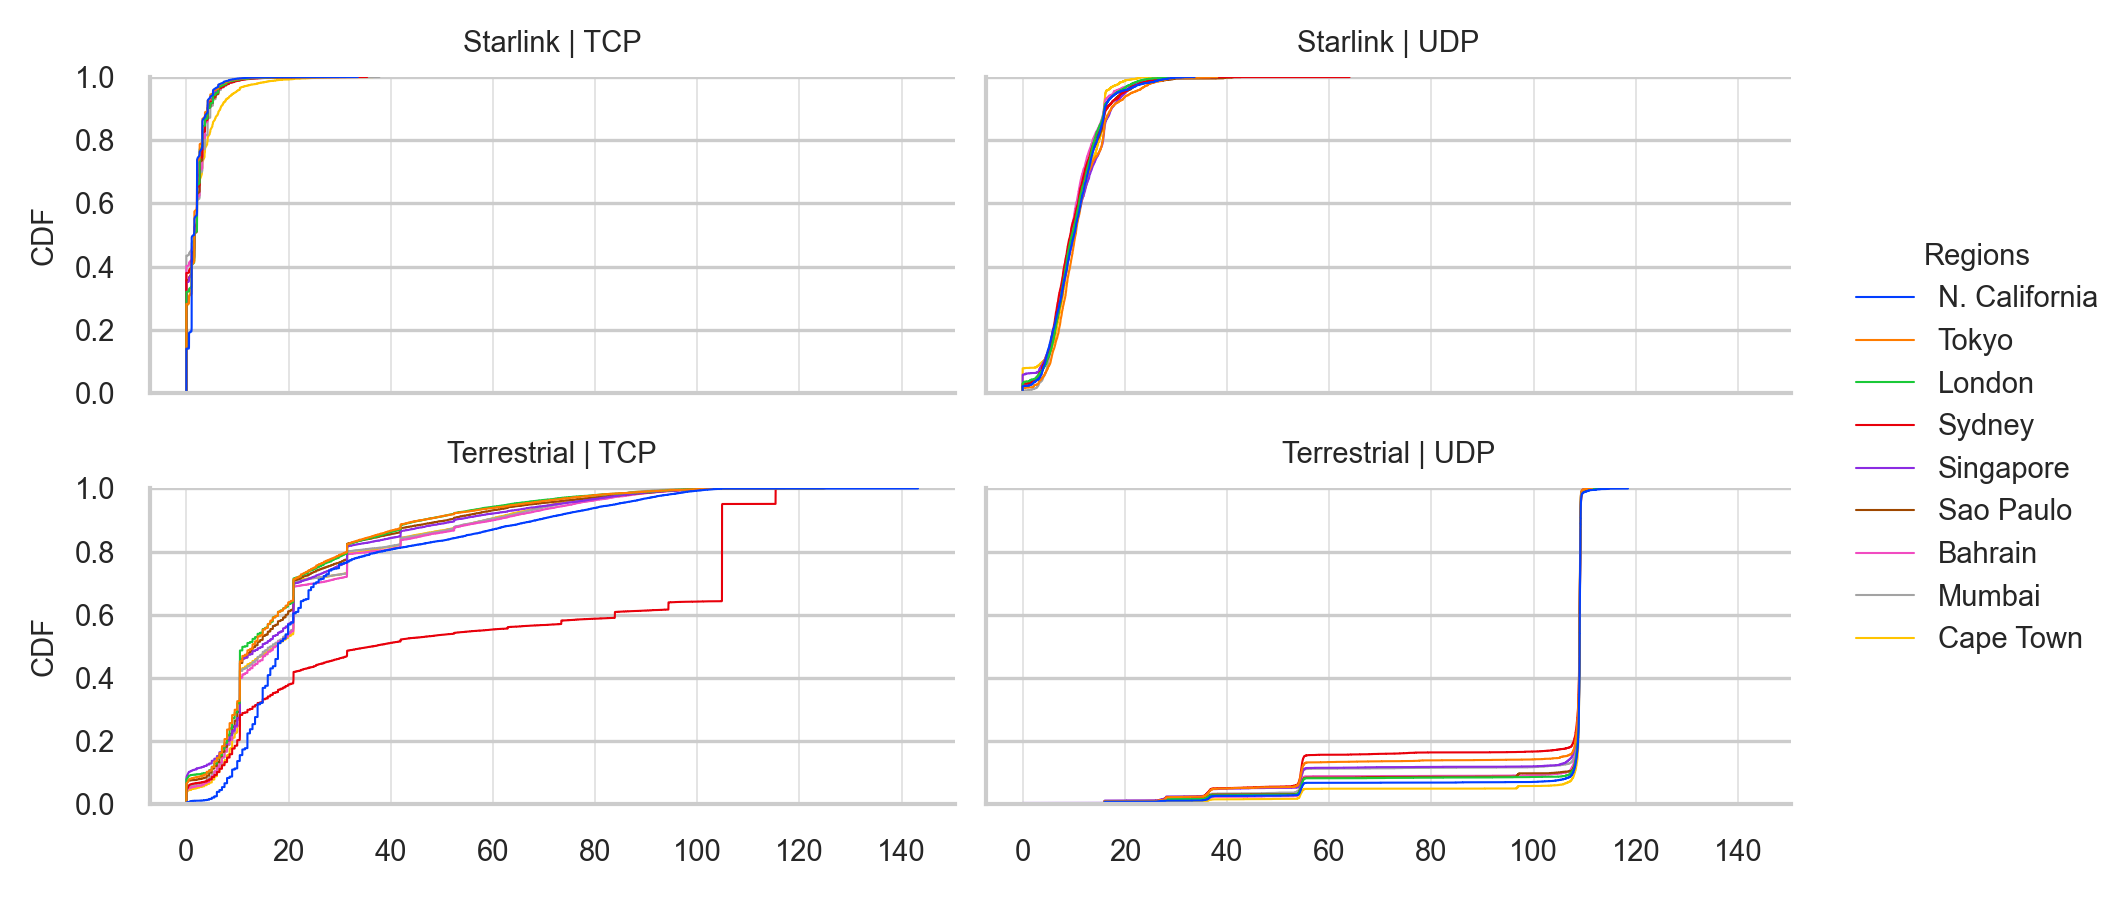

In [173]:
sns.set_palette('bright')

plots = [(N_STARLINK,N_TCP), (N_STARLINK,N_UDP), (N_HOME,N_TCP), (N_HOME,N_UDP)]

#for n_type, protocol in plots:
df_tmp = df_regs[(df_regs[COL_TRANSF_DIR] == N_UP)]
h = 1.5
aspect = (common.WIDTH_FULL - 1) / 2 / h
g_ecdf = sns.displot(
    data=df_tmp, x='bandwidth', 
    hue=N_REGIONS, hue_order=REG_ORDER,
    col=N_PROTOCOL,
    row=N_TYPE,
    kind='ecdf',
    height=h, aspect=aspect,
)

axes = g_ecdf.axes.flatten()
for ax in axes:
    ax.grid(visible=True, which='both', axis='x', color='gray', linewidth=0.1)

g_ecdf.set_titles(col_template='{col_name}', row_template='{row_name}')
g_ecdf.set(xlabel='', ylabel='CDF')
g_ecdf.tight_layout()


In [171]:
g_ecdf.savefig(f'{OUTPUT_FOLDER}/2022-07-07_end_throughput_cdf_down.pdf', bbox_inches='tight')